In [ ]:
# pip install opendatasets
# import opendatasets as od
# dataset_url = "https://www.kaggle.com/competitions/home-credit-default-risk/data"
# od.download(dataset_url)

# Problématique : Scoring

Dans un objectif d'élargir l'inclusion financière des personnes non bancarisées enfin de leur offrir une expérience d'empprunt positive
et securisée , Home credit utilise une variété de données alternatives comme des informations issues des télécommunications et des transactions pour prédire la capacité de remboursement de ses clients.

Ainsi dans la base de donnée Train on a la variable Target avec les labels:
- 1 : Le client rencontre des difficultés de remboursement (il a fait défaut)
- 0 : Autre cas


In [2]:
pip install phik

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 687.8/687.8 kB 14.4 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import phik

import warnings
warnings.filterwarnings('ignore')

from datetime import datetime

### plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly
plotly.offline.init_notebook_mode(connected=True)
import plotly.io as pio
pio.renderers.default = 'colab'

#column and row display limits
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
data_name = os.listdir('/content/drive/MyDrive/Scoring-Projet/data')

In [ ]:
# data_name

In [ ]:
# def read_data(name):
#     chemin_data = '../data/' + name
#     for enc in ['utf-8', 'ISO-8859-1', 'latin1']:
#         try:
#             data = pd.read_csv(chemin_data, encoding=enc)
#             break
#         except UnicodeDecodeError:
#             continue
#     return data


In [6]:
def load_all_tables(directory_path = '', verbose = True):

    '''
    Function to load all the tables required

    Input:
        directory_path: str, default = ''
            Path of directory in which tables are stored in
        verbose: bool, default = True
            Whether to keep verbosity or not

    '''

    if verbose:
        print("Loading all the tables...")
        start = datetime.now()

    #making all the variables global to be used anywhere in the notebook
    global application_train, application_test, bureau, bureau_balance, cc_balance, installments_payments, POS_CASH_balance, HomeCredit_columns_description, previous_application

    application_train = pd.read_csv(directory_path + 'application_train.csv')
    if verbose:
        print("Loaded 1 table.")

    application_test = pd.read_csv(directory_path + 'application_test.csv')
    if verbose:
        print("Loaded 2 tables.")

    bureau = pd.read_csv(directory_path + 'bureau.csv')
    if verbose:
        print("Loaded 3 tables.")

    bureau_balance = pd.read_csv(directory_path + 'bureau_balance.csv')
    if verbose:
        print("Loaded 4 tables.")

    cc_balance = pd.read_csv(directory_path + 'credit_card_balance.csv')
    if verbose:
        print("Loaded 5 tables.")

    installments_payments = pd.read_csv(directory_path + 'installments_payments.csv')
    if verbose:
        print("Loaded 6 tables.")

    POS_CASH_balance = pd.read_csv(directory_path + 'POS_CASH_balance.csv')
    if verbose:
        print("Loaded 7 tables.")

    HomeCredit_columns_description = pd.read_csv(directory_path +'HomeCredit_columns_description.csv', encoding='ISO-8859-1')
    if verbose:
        print("Loaded 8 tables.")

    previous_application = pd.read_csv(directory_path + 'previous_application.csv')
    if verbose:
        print("Loaded 9 tables.")
        print("Done.")
        print(f'Time Taken to load 9 tables = {datetime.now() - start}')

In [20]:
def plot_nan_percent(df, title_name, tight_layout = True, figsize = (20,8), grid = False, rotation = 90):

    '''
    Function to plot Bar Plots of NaN percentages for each Column with missing values

    Inputs:
        df:
            DataFrame of NaN percentages
        title_name:
            Name of table to be displayed in title of plot
        tight_layout: bool, default = True
            Whether to keep tight layout or not
        figsize: tuple, default = (20,8)
            Figure size of plot
        grid: bool, default = False
            Whether to draw gridlines to plot or not
        rotation: int, default = 0
            Degree of rotation for x-tick labels

    '''
    nan_percent = (round(df.isna().sum()/len(df)*100, 0)).astype(int)
    df = pd.DataFrame({'column' : nan_percent.index, 'percent' : nan_percent.values})
    df.sort_values(by = 'percent', ascending = False, inplace= True)
    #checking if there is any column with NaNs or not.
    if df.percent.sum() != 0:
        print(f"Nombre de colonnes avec des valeurs manquantes: {df[df['percent'] != 0].shape[0]} columns")

        #plotting the Bar-Plot with NaN percentages
        plt.figure(figsize = figsize, tight_layout = tight_layout)
        ax = sns.barplot(x= 'column', y = 'percent', data = df[df['percent'] > 0])
        for i, p in enumerate(ax.patches):
            height = p.get_height()
            # Décalage vertical : 0.5 si pair, 1.5 si impair (tu peux ajuster ces valeurs)
            offset = 0.5 if i % 2 == 0 else 1.5
            ax.annotate(f'{height:.1f}%',
                        (p.get_x() + p.get_width() / 2, height + offset),
                        ha='center', va='bottom', fontsize=7, color='black',
                        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.3'))

        plt.xticks(rotation = rotation)
        plt.xlabel('Noms des colonnes')
        plt.ylabel('Pourcentage de valeurs manquantes')
        plt.title(f'Pourcentage de valeurs manquantes dans {title_name}')
        if grid:
            plt.grid()
        plt.show()
    else:
        print(f"Le dataframe {title_name} ne contient pas de valeurs manquantes.")

In [8]:
class correlation_matrix:
    '''
    Class to plot heatmap of Correlation Matrix and print Top Correlated Features with Target.
    Contains three methods:
        1. init method
        2. plot_correlation_matrix method
        3. target_top_corr method
    '''

    def __init__(self, data, columns_to_drop, figsize = (25,23), mask_upper = True, tight_layout = True,
                  linewidth = 0.1, fontsize = 10, cmap = 'Blues'):
        '''
        Function to initialize the class members.

        Inputs:
            data: DataFrame
                The DataFrame from which to build correlation matrix
            columns_to_drop: list
                Columns which have to be dropped while building the correlation matrix (for example the Loan ID)
            figsize: tuple, default = (25,23)
                Size of the figure to be plotted
            mask_upper: bool, default = True
                Whether to plot only the lower triangle of heatmap or plot full.
            tight_layout: bool, default = True
                Whether to keep tight layout or not
            linewidth: float/int, default = 0.1
                The linewidth to use for heatmap
            fontsize: int, default = 10
                The font size for the X and Y tick labels
            cmap: str, default = 'Blues'
                The colormap to be used for heatmap

        Returns:
            None
        '''

        self.data = data
        self.columns_to_drop = columns_to_drop
        self.figsize = figsize
        self.mask_upper = mask_upper
        self.tight_layout = tight_layout
        self.linewidth = linewidth
        self.fontsize = fontsize
        self.cmap = cmap

    def plot_correlation_matrix(self):
        '''
        Function to plot the Correlation Matrix Heatmap

        Inputs:
            self

        Returns:
            None
        '''

        print('-' * 100)
        #building the correlation dataframe
        self.corr_data = self.data.drop(self.columns_to_drop, axis = 1).corr()

        if self.mask_upper:
            #masking the heatmap to show only lower triangle. This is to save the RAM.
            mask_array = np.ones(self.corr_data.shape)
            mask_array = np.triu(mask_array)
        else:
            mask_array = np.zeros(self.corr_data.shape)

        plt.figure(figsize = self.figsize, tight_layout = self.tight_layout)
        sns.heatmap(self.corr_data, annot = False, mask = mask_array, linewidth = self.linewidth, cmap = self.cmap)
        plt.xticks(rotation = 90, fontsize = self.fontsize)
        plt.yticks(fontsize = self.fontsize)
        plt.title("Correlation Heatmap for Numerical features")
        plt.show()
        print("-"*100)

    def target_top_corr(self, target_top_columns = 10):
        '''
        Function to return the Top Correlated features with the Target

        Inputs:
            self
            target_top_columns: int, default = 10
                The number of top correlated features with target to display

        Returns:
            Top correlated features DataFrame.
        '''
        if not hasattr(self, 'corr_data'):
            self.corr_data = self.data.drop(self.columns_to_drop, axis=1).corr()

        phik_target_arr = np.zeros(len(self.corr_data))
        #calculating the Phik-Correlation with Target
        for index, column in enumerate(self.corr_data.columns):
            phik_target_arr[index] = self.data[['TARGET', column]].phik_matrix().iloc[0,1]
        #getting the top correlated columns and their values
        top_corr_target_df = pd.DataFrame({'Column Name': self.corr_data.columns, 'Phik-Correlation' : phik_target_arr})
        top_corr_target_df = top_corr_target_df.sort_values(by = 'Phik-Correlation', ascending = False)

        return top_corr_target_df.iloc[:target_top_columns]


In [9]:
def plot_phik_matrix(data, categorical_columns, figsize = (20,20), mask_upper = True, tight_layout = True, linewidth = 0.1, fontsize = 10, cmap = 'Blues', show_target_top_corr = True, target_top_columns = 10):

    '''
    Function to Phi_k matrix for categorical features

    Inputs:
        data: DataFrame
            The DataFrame from which to build correlation matrix
        categorical_columns: list
            List of categorical columns whose PhiK values are to be plotted
        figsize: tuple, default = (25,23)
            Size of the figure to be plotted
        mask_upper: bool, default = True
            Whether to plot only the lower triangle of heatmap or plot full.
        tight_layout: bool, default = True
            Whether to keep tight layout or not
        linewidth: float/int, default = 0.1
            The linewidth to use for heatmap
        fontsize: int, default = 10
            The font size for the X and Y tick labels
        cmap: str, default = 'Blues'
            The colormap to be used for heatmap
        show_target_top_corr: bool, default = True
            Whether to show top/highly correlated features with Target.
        target_top_columns: int, default = 10
            The number of top correlated features with target to display
    '''

    #first fetching only the categorical features
    data_for_phik = data[categorical_columns].astype('object')
    phik_matrix = data_for_phik.phik_matrix()

    print('-'*100)

    if mask_upper:
        mask_array = np.ones(phik_matrix.shape)
        mask_array = np.triu(mask_array)
    else:
        mask_array = np.zeros(phik_matrix.shape)

    plt.figure(figsize = figsize, tight_layout = tight_layout)
    sns.heatmap(phik_matrix, annot = False, mask = mask_array, linewidth = linewidth, cmap = cmap)
    plt.xticks(rotation = 90, fontsize = fontsize)
    plt.yticks(rotation = 0, fontsize = fontsize)
    plt.title("Phi-K Correlation Heatmap for Categorical Features")
    plt.show()
    print("-"*100)

    if show_target_top_corr:
        #Seeing the top columns with highest correlation with the target variable in application_train
        print("Categories with highest values of Phi-K Correlation value with Target Variable are:")
        phik_df = pd.DataFrame({'Column Name' : phik_matrix.TARGET.index[1:], 'Phik-Correlation' : phik_matrix.TARGET.values[1:]})
        phik_df = phik_df.sort_values(by = 'Phik-Correlation', ascending = False)
        display(phik_df.head(target_top_columns))
        print("-"*100)

In [10]:
def plot_categorical_variables_bar(data, column_name, figsize = (18,6), percentage_display = True, plot_defaulter = True, rotation = 0, horizontal_adjust = 0, fontsize_percent = 'xx-small'):

    '''
    Function to plot Categorical Variables Bar Plots

    Inputs:
        data: DataFrame
            The DataFrame from which to plot
        column_name: str
            Column's name whose distribution is to be plotted
        figsize: tuple, default = (18,6)
            Size of the figure to be plotted
        percentage_display: bool, default = True
            Whether to display the percentages on top of Bars in Bar-Plot
        plot_defaulter: bool
            Whether to plot the Bar Plots for Defaulters or not
        rotation: int, default = 0
            Degree of rotation for x-tick labels
        horizontal_adjust: int, default = 0
            Horizontal adjustment parameter for percentages displayed on the top of Bars of Bar-Plot
        fontsize_percent: str, default = 'xx-small'
            Fontsize for percentage Display

    '''

    print(f"Total Number of unique categories of {column_name} = {len(data[column_name].unique())}")

    plt.figure(figsize = figsize, tight_layout = False)
    sns.set(style = 'whitegrid', font_scale = 1.2)

    #plotting overall distribution of category
    plt.subplot(1,2,1)
    data_to_plot = data[column_name].value_counts().sort_values(ascending = False)
    ax = sns.barplot(x = data_to_plot.index, y = data_to_plot, palette = 'Set1')
    total_datapoints = len(data[column_name].dropna())

    if percentage_display:
        for i, p in enumerate(ax.patches):
            height = p.get_height() * 100 / total_datapoints
            # Décalage vertical : 0.5 si pair, 1.5 si impair (tu peux ajuster ces valeurs)
            # offset = 0.5 if i % 2 == 0 else 1.5
            ax.annotate(f'{height:.1f}%',
                        (p.get_x() + p.get_width()/2 , p.get_height() + 0.005 * total_datapoints),
                        ha='center', va='center', fontsize=10, color='black',
                        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.3'))
        # total_datapoints = len(data[column_name].dropna())
        # for p in ax.patches:
        #     ax.text(p.get_x() + horizontal_adjust, p.get_height() + 0.005 * total_datapoints, '{:1.02f}%'.format(p.get_height() * 100 / total_datapoints), fontsize = fontsize_percent)

    plt.xlabel(column_name, labelpad = 10)
    plt.title(f'Distribution of {column_name}', pad = 20)
    plt.xticks(rotation = rotation)
    plt.ylabel('Counts')

    #plotting distribution of category for Defaulters
    if plot_defaulter:
        plt.subplot(1,2,2)
        percentage_defaulter_per_category = (data[column_name][data.TARGET == 1].value_counts() * 100 / data[column_name].value_counts()).dropna().sort_values(ascending = False)
        ax2 = sns.barplot(x = percentage_defaulter_per_category.index, y = percentage_defaulter_per_category, palette = 'Set1')
        for i_, p_ in enumerate(ax2.patches):
            ax2.annotate(f'{p_.get_height():.1f}%',
                        (p_.get_x() + p_.get_width()/2 , p_.get_height() + 0.5),
                        ha='center', va='center', fontsize=10, color='black',
                        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.3'))
        plt.ylabel('Percentage of Defaulter per category')
        plt.xlabel(column_name, labelpad = 10)
        plt.xticks(rotation = rotation)
        plt.title(f'Percentage of Defaulters for each category of {column_name}', pad = 20)
    plt.show()

In [11]:
def print_unique_categories(data, column_name, show_counts = False):

    '''
    Function to print the basic stats such as unique categories and their counts for categorical variables

        Inputs:
        data: DataFrame
            The DataFrame from which to print statistics
        column_name: str
            Column's name whose stats are to be printed
        show_counts: bool, default = False
            Whether to show counts of each category or not

    '''

    print('-'*100)
    print(f"The unique categories of '{column_name}' are:\n{data[column_name].unique()}")
    print('-'*100)

    if show_counts:
        print(f"Counts of each category are:\n{data[column_name].value_counts()}")
        print('-'*100)

In [12]:
def plot_categorical_variables_pie(data, column_name, plot_defaulter = True, hole = 0):

    '''
    Function to plot categorical variables Pie Plots

    Inputs:
        data: DataFrame
            The DataFrame from which to plot
        column_name: str
            Column's name whose distribution is to be plotted
        plot_defaulter: bool
            Whether to plot the Pie Plot for Defaulters or not
        hole: int, default = 0
            Radius of hole to be cut out from Pie Chart
    '''

    if plot_defaulter:
        cols = 2
        specs = [[{'type' : 'domain'}, {'type' : 'domain'}]]
        titles = [f'Distribution of {column_name} for all Targets', f'Percentage of Defaulters for each category of {column_name}']
    else:
        cols = 1
        specs = [[{'type': 'domain'}]]
        titles = [f'Distribution of {column_name} for all Targets']

    values_categorical = data[column_name].value_counts()
    labels_categorical = values_categorical.index

    fig = make_subplots(rows = 1, cols = cols,
                       specs = specs,
                       subplot_titles = titles)

    fig.add_trace(go.Pie(values = values_categorical, labels = labels_categorical, hole = hole,
                         textinfo = 'label+percent', textposition = 'inside'), row = 1, col = 1)

    if plot_defaulter:
        percentage_defaulter_per_category = data[column_name][data.TARGET == 1].value_counts() * 100 / data[column_name].value_counts()
        percentage_defaulter_per_category.dropna(inplace = True)
        percentage_defaulter_per_category = percentage_defaulter_per_category.round(2)

        fig.add_trace(go.Pie(values = percentage_defaulter_per_category, labels = percentage_defaulter_per_category.index,
                             hole = hole, textinfo = 'label+value', hoverinfo = 'label+value'), row = 1, col = 2)

    fig.update_layout(title = f'Distribution of {column_name}')
    fig.show()

In [13]:
def plot_cdf(data, column_name, log_scale = False, figsize = (12,8)):

    '''
    Function to plot CDF of a continuour variable

    Inputs:
        data: DataFrame
            The DataFrame from which to plot
        column_name: str
            Column's name whose CDF is to be plotted
        log_scale: bool, default = True
            Whether to use log-scale (for widely varying values) or not
        figsize: tuple, default = (12,8)
            The size of figure to be plotted

    CDF en français : c'est la fonction de distribution cumulative est un concept fondamental
    statistique et en théorie des probabilités qui décrit la probabilité qu'une variable aléatoire prenne
    une valeur inférieure ou égale à un point spécifique.
    '''


    percentile_values = data[[column_name]].dropna().sort_values(by = column_name)
    percentile_values['Percentile'] = [ele / (len(percentile_values) - 1) for ele in range(len(percentile_values))]

    plt.figure(figsize = figsize)
    if log_scale:
        plt.xscale('log')
        plt.xlabel(column_name + ' - (log-scale)')
    else:
        plt.xlabel(column_name)
    plt.plot(percentile_values[column_name], percentile_values['Percentile'], color = 'red')
    plt.ylabel('Probability')
    plt.title('CDF of {}'.format(column_name))
    plt.show()


In [14]:
def plot_continuous_variables(data, column_name, plots = ['distplot', 'CDF', 'box', 'violin'], scale_limits = None, figsize = (20,8), histogram = True, log_scale = False):

    '''
    Function to plot continuous variables distribution
    Inputs:
        data: DataFrame
            The DataFrame from which to plot.
        column_name: str
            Column's name whose distribution is to be plotted.
        plots: list, default = ['distplot', 'CDF', box', 'violin']
            List of plots to plot for Continuous Variable.
        scale_limits: tuple (left, right), default = None
            To control the limits of values to be plotted in case of outliers.
        figsize: tuple, default = (20,8)
            Size of the figure to be plotted.
        histogram: bool, default = True
            Whether to plot histogram along with distplot or not.
        log_scale: bool, default = False
            Whether to use log-scale for variables with outlying points.
    '''

    data_to_plot = data.copy()
    if scale_limits:
        #taking only the data within the specified limits
        data_to_plot[column_name] = data[column_name][(data[column_name] > scale_limits[0]) & (data[column_name] < scale_limits[1])]

    number_of_subplots = len(plots)
    plt.figure(figsize = figsize)
    sns.set_style('whitegrid')

    for i, ele in enumerate(plots):
        plt.subplot(1, number_of_subplots, i + 1)
        plt.subplots_adjust(wspace=0.25)

        if ele == 'CDF':
            #making the percentile DataFrame for both positive and negative Class Labels
            percentile_values_0 = data_to_plot[data_to_plot.TARGET == 0][[column_name]].dropna().sort_values(by = column_name)
            percentile_values_0['Percentile'] = [ele / (len(percentile_values_0)-1) for ele in range(len(percentile_values_0))]

            percentile_values_1 = data_to_plot[data_to_plot.TARGET == 1][[column_name]].dropna().sort_values(by = column_name)
            percentile_values_1['Percentile'] = [ele / (len(percentile_values_1)-1) for ele in range(len(percentile_values_1))]

            plt.plot(percentile_values_0[column_name], percentile_values_0['Percentile'], color = 'red', label = 'Non-Defaulters')
            plt.plot(percentile_values_1[column_name], percentile_values_1['Percentile'], color = 'black', label = 'Defaulters')
            plt.xlabel(column_name)
            plt.ylabel('Probability')
            plt.title('CDF of {}'.format(column_name))
            plt.legend(fontsize = 'medium')
            if log_scale:
                plt.xscale('log')
                plt.xlabel(column_name + ' - (log-scale)')

        if ele == 'distplot':
            sns.distplot(data_to_plot[column_name][data['TARGET'] == 0].dropna(),
                         label='Non-Defaulters', hist = False, color='red')
            sns.distplot(data_to_plot[column_name][data['TARGET'] == 1].dropna(),
                         label='Defaulters', hist = False, color='black')
            plt.xlabel(column_name)
            plt.ylabel('Probability Density')
            plt.legend(fontsize='medium')
            plt.title("Dist-Plot of {}".format(column_name))
            if log_scale:
                plt.xscale('log')
                plt.xlabel(f'{column_name} (log scale)')

        if ele == 'violin':
            sns.violinplot(x='TARGET', y=column_name, data=data_to_plot)
            plt.title("Violin-Plot of {}".format(column_name))
            if log_scale:
                plt.yscale('log')
                plt.ylabel(f'{column_name} (log Scale)')

        if ele == 'box':
            sns.boxplot(x='TARGET', y=column_name, data=data_to_plot)
            plt.title("Box-Plot of {}".format(column_name))
            if log_scale:
                plt.yscale('log')
                plt.ylabel(f'{column_name} (log Scale)')

    plt.show()


# EDA

Pour l'analyse des données, nous suivrons les étapes suivantes :

- Pour chaque table, nous commencerons par vérifier les statistiques de base, comme le nombre d'enregistrements, le nombre de variables (ou caractéristiques), le nombre de valeurs manquantes (NaN), etc.

- Ensuite, nous explorerons certaines caractéristiques en relation avec la variable cible pour chaque table. Nous utiliserons les visualisations suivantes :

    - Pour les variables catégorielles, nous utiliserons principalement des diagrammes en barres et des camemberts (pie charts).

    - Pour les variables continues/numériques, nous utiliserons des boîtes à moustaches (box plots), des fonctions de densité de probabilité (PDF), des fonctions de répartition cumulée (CDF), ainsi que des graphes en violon (violin plots).

- Nous tirerons des observations à partir de chaque graphique et noterons les informations clés qui en ressortent.

## Download Data

In [ ]:
# Table de données principales
# Train = read_data('application_train.csv')
# Test = read_data('application_test.csv')

# # Crédits externes (autres banques)
# bureau = read_data('bureau.csv')
# # Evolution mensuelle des crédits externes
# bureau_balance = read_data('bureau_balance.csv')

# # Cartes de crédit des clients Home credit
# credit_card_balance = read_data('credit_card_balance.csv')

# # Dictionnaire des données (descrition des variables de toutes les tables de données)
# HomeCredit_columns_description = read_data('HomeCredit_columns_description.csv')

# #Historique des paiements mensuels des clients
# installments_payments = read_data('installments_payments.csv')

# #Credit à la conso chez Home credit
# POS_CASH_balance = read_data('POS_CASH_balance.csv')

# # Ancienne demande de prêts
# previous_application = read_data('previous_application.csv')

# # Table à soumettre pour le challenge
# sample_submission = read_data('sample_submission.csv')

In [15]:
chemin_data = '/content/drive/MyDrive/Scoring-Projet/data/'

In [ ]:
# !ls

In [16]:
load_all_tables(directory_path = chemin_data)

Loading all the tables...
Loaded 1 table.
Loaded 2 tables.
Loaded 3 tables.
Loaded 4 tables.
Loaded 5 tables.
Loaded 6 tables.
Loaded 7 tables.
Loaded 8 tables.
Loaded 9 tables.
Done.
Time Taken to load 9 tables = 0:01:05.590992


In [17]:
import sys
sys.path.append('/content/drive/MyDrive/Scoring-Projet/Data_process')

from Data_process.descripe_data import DataAnalyzer

## Data Comprehension
L'idée ici est de se familiariser avec les bases de données

### application_train & aplplication_test

Description :
Le fichier application_train.csv contient des données statiques relatives aux emprunteurs, accompagnées de leurs étiquettes (cibles). Chaque ligne représente une demande de prêt.
Le fichier application_test.csv contient l'ensemble de données de test, similaire à application_train.csv, à la différence près que la colonne ***TARGET*** a été supprimée. Cette colonne doit être prédite à l'aide de modèles prédictifs statistiques et d'apprentissage automatique.

#### Basic Stats

##### Train

In [18]:
analyzer_Train = DataAnalyzer(application_train, metadata_df=HomeCredit_columns_description)
numerical, categorical_cols, booleans = analyzer_Train.data_col_type()
summary_table_Train = analyzer_Train.global_description_table(df=application_train[numerical])

In [19]:
print('-'*50,'quelques statistiques de application_train','-'*50)
display(analyzer_Train.Global_info())
print('-'*50,'quelques stats sur les colonnes numériques', '-'*50)
display(summary_table_Train.head())

-------------------------------------------------- quelques statistiques de application_train --------------------------------------------------


[{'nombre de lignes': 307511,
  'nombre de colonnes': 122,
  'nombre de doublons': 0,
  'nombre de colonnes constantes ': 0,
  'colonnes constantes': [],
  'Pourcentage de valeurs manquantes %': np.float64(24.4),
  'dtypes': {'nombre de variables catégorielles': 16,
   'nombre de variables numeriques': 73,
   'nombre de variables Booléennes': 33}}]

-------------------------------------------------- quelques stats sur les colonnes numériques --------------------------------------------------


colonne  nb_valeurs  valeurs_manquantes en %   moyenne  \
23            COMMONAREA_AVG       92646                    69.87  0.044621   
37           COMMONAREA_MODE       92646                    69.87  0.042553   
51           COMMONAREA_MEDI       92646                    69.87  0.044595   
31   NONLIVINGAPARTMENTS_AVG       93997                    69.43  0.008809   
45  NONLIVINGAPARTMENTS_MODE       93997                    69.43  0.008076   

    max  min                                    Col_Description  
23  1.0  0.0  Normalized information about building where th...  
37  1.0  0.0  Normalized information about building where th...  
51  1.0  0.0  Normalized information about building where th...  
31  1.0  0.0  Normalized information about building where th...  
45  1.0  0.0  Normalized information about building where th...

##### Test

In [ ]:
analyzer_test = DataAnalyzer(application_test, metadata_df=HomeCredit_columns_description)
numerical_test, categorical_cols_test, booleans_test = analyzer_test.data_col_type()
summary_table_test = analyzer_test.global_description_table(df=application_test[numerical_test])

In [ ]:
print('-'*50,'quelques statistiques de application_test','-'*50)
display(analyzer_test.Global_info())
print('-'*50, 'Les 5 premières lignes', '-'*50)
display(application_test.head())
print('-'*50,'quelques stats sur les colonnes numériques', '-'*50)
display(summary_table_test.head())

-------------------------------------------------- quelques statistiques de application_test --------------------------------------------------


[{'nombre de lignes': 48744,
  'nombre de colonnes': 121,
  'nombre de doublons': 0,
  'nombre de colonnes constantes ': 11,
  'colonnes constantes': ['FLAG_DOCUMENT_2',
   'FLAG_DOCUMENT_10',
   'FLAG_DOCUMENT_12',
   'FLAG_DOCUMENT_13',
   'FLAG_DOCUMENT_14',
   'FLAG_DOCUMENT_15',
   'FLAG_DOCUMENT_16',
   'FLAG_DOCUMENT_17',
   'FLAG_DOCUMENT_19',
   'FLAG_DOCUMENT_20',
   'FLAG_DOCUMENT_21'],
  'Pourcentage de valeurs manquantes %': np.float64(23.81),
  'dtypes': {'nombre de variables catégorielles': 16,
   'nombre de variables numeriques': 84,
   'nombre de variables Booléennes': 21}}]

-------------------------------------------------- Les 5 premières lignes --------------------------------------------------


SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      100001         Cash loans           F            N               Y   
1      100005         Cash loans           M            N               Y   
2      100013         Cash loans           M            Y               Y   
3      100028         Cash loans           F            N               Y   
4      100038         Cash loans           M            Y               N   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          135000.0    568800.0      20560.5         450000.0   
1             0           99000.0    222768.0      17370.0         180000.0   
2             0          202500.0    663264.0      69777.0         630000.0   
3             2          315000.0   1575000.0      49018.5        1575000.0   
4             1          180000.0    625500.0      32067.0         625500.0   

  NAME_TYPE_SUITE NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0   Unaccompanied          Working               Higher education   
1   Unaccompanied          Working  Secondary / secondary special   
2             NaN          Working               Higher education   
3   Unaccompanied          Working  Secondary / secondary special   
4   Unaccompanied          Working  Secondary / secondary special   

  NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  \
0            Married  House / apartment                    0.018850   
1            Married  House / apartment                    0.035792   
2            Married  House / apartment                    0.019101   
3            Married  House / apartment                    0.026392   
4            Married  House / apartment                    0.010032   

   DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
0      -19241          -2329            -5170.0             -812          NaN   
1      -18064          -4469            -9118.0            -1623          NaN   
2      -20038          -4458            -2175.0            -3503          5.0   
3      -13976          -1866            -2000.0            -4208          NaN   
4      -13040          -2191            -4000.0            -4262         16.0   

   FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
0           1               1                0                 1           0   
1           1               1                0                 1           0   
2           1               1                0                 1           0   
3           1               1                0                 1           1   
4           1               1                1                 1           0   

   FLAG_EMAIL     OCCUPATION_TYPE  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
0           1                 NaN              2.0                     2   
1           0  Low-skill Laborers              2.0                     2   
2           0             Drivers              2.0                     2   
3           0         Sales staff              4.0                     2   
4           0                 NaN              3.0                     2   

   REGION_RATING_CLIENT_W_CITY WEEKDAY_APPR_PROCESS_START  \
0                            2                    TUESDAY   
1                            2                     FRIDAY   
2                            2                     MONDAY   
3                            2                  WEDNESDAY   
4                            2                     FRIDAY   

   HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
0                       18                           0   
1                        9                           0   
2                       14                           0   
3                       11                           0   
4                        5                           0   

   REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
0                   

-------------------------------------------------- quelques stats sur les colonnes numériques --------------------------------------------------


colonne  nb_valeurs  valeurs_manquantes en %   moyenne  \
37           COMMONAREA_MODE       15249                    68.72  0.045223   
51           COMMONAREA_MEDI       15249                    68.72  0.047420   
23            COMMONAREA_AVG       15249                    68.72  0.047624   
31   NONLIVINGAPARTMENTS_AVG       15397                    68.41  0.009231   
59  NONLIVINGAPARTMENTS_MEDI       15397                    68.41  0.008979   

    max  min                                    Col_Description  
37  1.0  0.0  Normalized information about building where th...  
51  1.0  0.0  Normalized information about building where th...  
23  1.0  0.0  Normalized information about building where th...  
31  1.0  0.0  Normalized information about building where th...  
59  1.0  0.0  Normalized information about building where th...

Observations et Conclusions :

- application_train.csv :
    - Le fichier application_train.csv contient environ 307K enregistrements et 122 variables. Ces variables correspondent à des statistiques personnelles propres à chaque client, telles que son âge, revenu, type de prêt, caractéristiques du logement, etc.
    - Il y a 307 000 identifiants uniques (SK_ID_CURR) qui représentent chacun une demande de prêt distincte.
    Le champ TARGET représente l’état du remboursement du prêt :
        - 0 signifie que le client n’a pas fait défaut (Non-défaillant),
        - 1 signifie que le client a fait défaut (Défaillant).

- application_test.csv :
    - Le fichier application_test.csv contient environ 48.7k enregistrements et 121 variables. Ces variables sont exactement les mêmes que celles du fichier application_train.csv, à l’exception de la colonne TARGET qui est absente.
    - Il y a 48.7k identifiants uniques (SK_ID_CURR) représentant des demandes de prêt distinctes.
    - Il y'a 11 colonnes constantes ['FLAG_DOCUMENT_2','FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_12','FLAG_DOCUMENT_13','FLAG_DOCUMENT_14','FLAG_DOCUMENT_15','FLAG_DOCUMENT_16','FLAG_DOCUMENT_17','FLAG_DOCUMENT_19','FLAG_DOCUMENT_20','FLAG_DOCUMENT_21'],
    - La colonne TARGET doit être prédite à l’aide de modèles statistiques et de modèles d’apprentissage automatique.

#### Les valeurs manquantes

Nombre de colonnes avec des valeurs manquantes: 57 columns


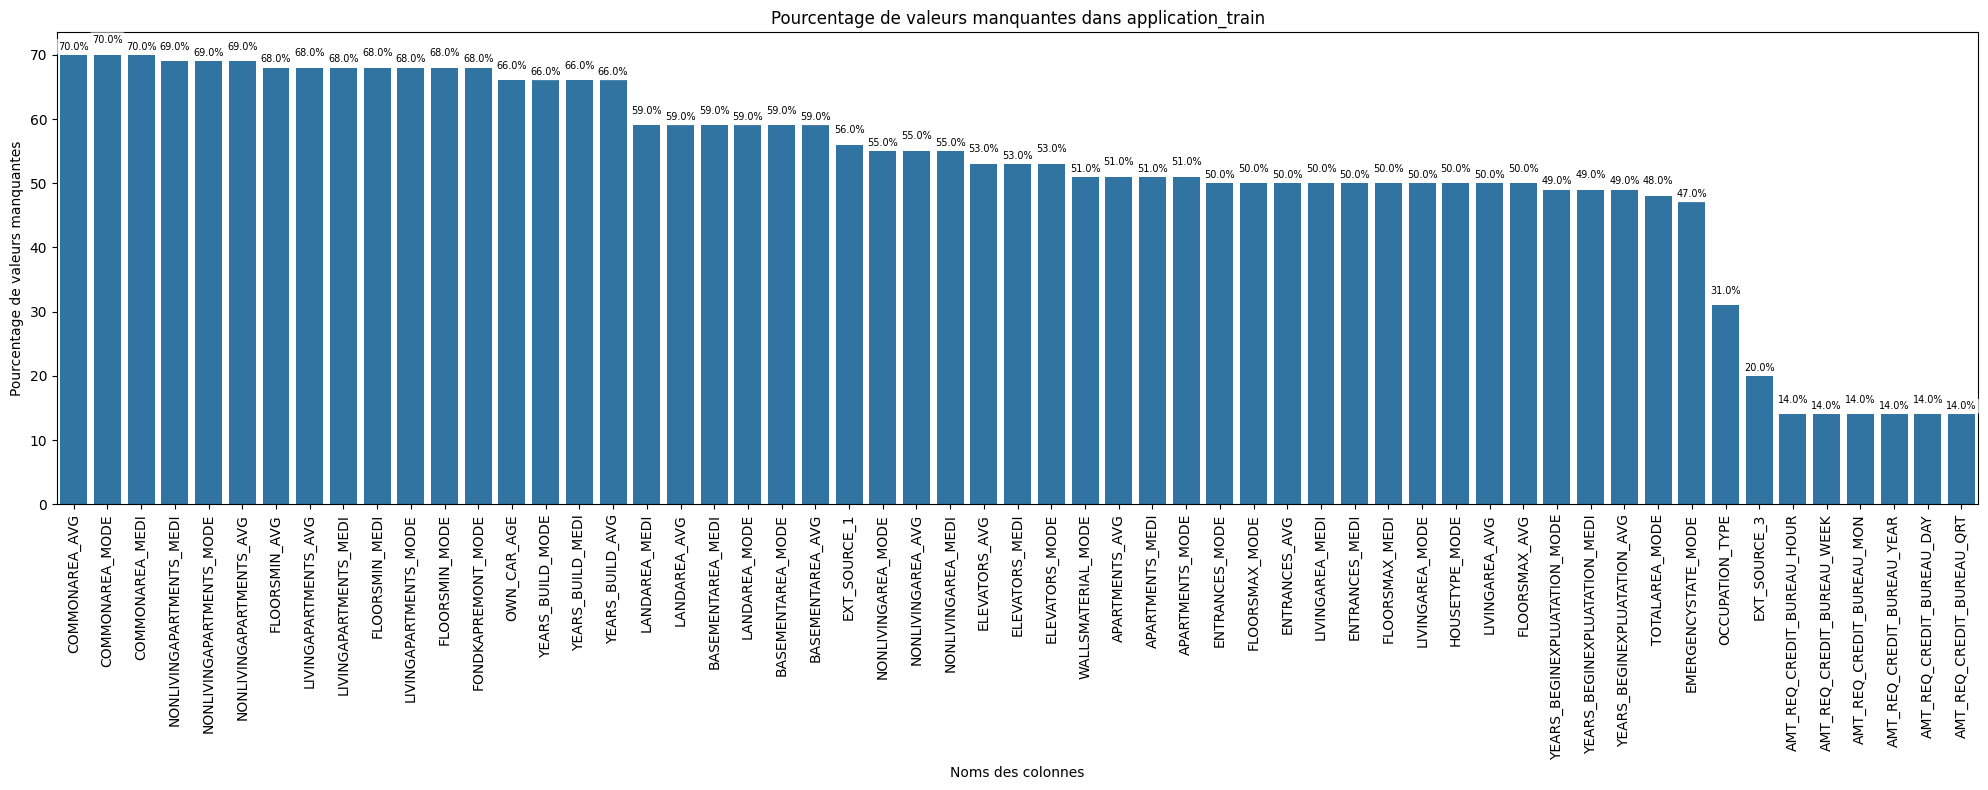

In [21]:
plot_nan_percent(application_train, 'application_train', grid = False)

Nombre de colonnes avec des valeurs manquantes: 58 columns


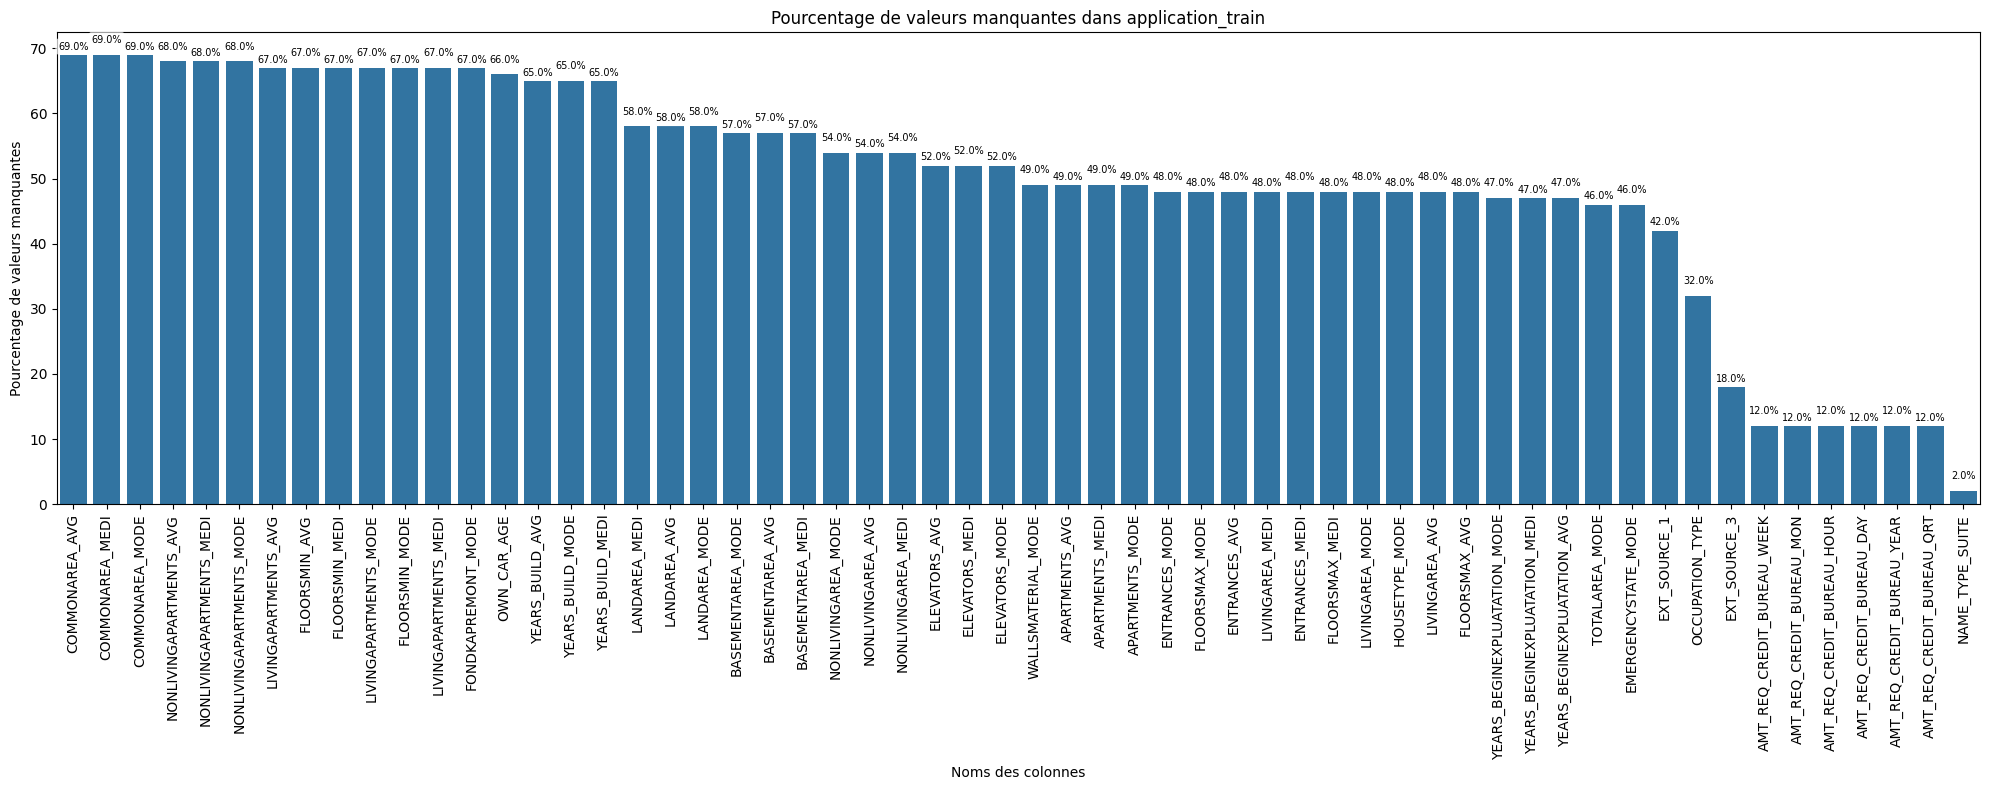

In [22]:
plot_nan_percent(application_test, 'application_train', grid = False)

Observations et Conclusions :

- application_train.csv :

    Il ressort du graphique ci-dessus qu'il y a 57 colonnes sur 122 caractéristiques qui contiennent des valeurs manquantes (NaN). Si seules une ou deux colonnes contenaient des valeurs manquantes, nous aurions pu simplement les éliminer, mais pour un tel nombre de colonnes, nous ne pouvons pas les supprimer telles quelles, car la perte d'informations pourrait être très élevée.
    Nous observons que certaines colonnes, comme celles relatives à **COMMONAREA, NONLIVINGAPARTMENT, etc.**, ont près de 70% de valeurs manquantes. Nous devrons trouver des techniques pour gérer ces nombreuses valeurs manquantes et déterminer ce qui fonctionne le mieux pour nos données.
    Un autre point à noter est que la plupart des colonnes ayant plus de 50% de valeurs manquantes sont liées aux statistiques des appartements de l'emprunteur. Il est très probable que ces valeurs n’aient pas été enregistrées lors de la saisie des données et pourraient être optionnelles.

- application_test.csv :

    Le nombre de colonnes avec des valeurs manquantes (64) est très similaire à celui de application_train.
    Les pourcentages de valeurs manquantes (NaN) sont également assez similaires à ceux présents dans l'ensemble de données d'entraînement. Cela signifie que les ensembles d'entraînement et de test ont une distribution assez similaire.

#### Distribution de la variable cible

In [24]:
target_distribution = application_train.TARGET.value_counts()
labels = ['Non-Defaulter', 'Defaulter']

fig = go.Figure(data = [
        go.Pie(values = target_distribution, labels = labels, textposition='auto',textinfo = 'label+percent+value' , pull = [0.1,0.04],
               marker=dict(colors=['#8A2BE2','#FF69B4' ]))],
         layout = go.Layout(title=dict(
                text='Repartition de la variable cible (TARGET)',
                pad=dict(t=10),  # réduit l'espace au-dessus du titre
                x=0.5  # centré horizontalement
            )
))

fig.show()


Observations et Conclusions :

D'après la distribution de la variable cible, une chose que l'on peut rapidement remarquer est le déséquilibre des données. Seuls **8,07%** des prêts totaux ont effectivement fait défaut. Cela signifie que les défaillants représentent la classe minoritaire.

En revanche, **91,9%** des prêts n'ont pas fait défaut. Ainsi, les non-défaillants constitueront notre classe majoritaire.
***Les défaillants ont été assignés*** à la variable cible avec la **valeur 1**, tandis que les ***non-défaillants*** ont été assignés à la **valeur 0**.

Pour un ensemble de données déséquilibré, lors de la construction du modèle, nous ne pouvons pas simplement fournir les données telles quelles à certains algorithmes sensibles au déséquilibre.
Il en va de même pour les indicateurs de performance. Pour un tel ensemble de données, l'exactitude (Accuracy) n'est généralement pas la bonne métrique, car elle serait biaisée en faveur de la classe majoritaire. Nous pouvons utiliser d'autres métriques telles que le ***ROC-AUC Score***, le ***Log-Loss***, le ***F1-Score*** et la ***matrice de confusion*** pour une meilleure évaluation du modèle.
Une autre chose importante à noter ici est que très peu de personnes font réellement défaut, et celles qui le font ont tendance à montrer un comportement différent. Ainsi, dans de tels cas de ***fraude***, de ***défaut*** et de ***détection d'anomalies***, nous devons aussi nous concentrer sur les ***valeurs aberrantes (outliers)***, et nous ne pouvons pas les supprimer, car elles pourraient être le facteur de différenciation entre un défaillant et un non-défaillant.

#### Phi-K matrix

----------------------------------------------------------------------------------------------------


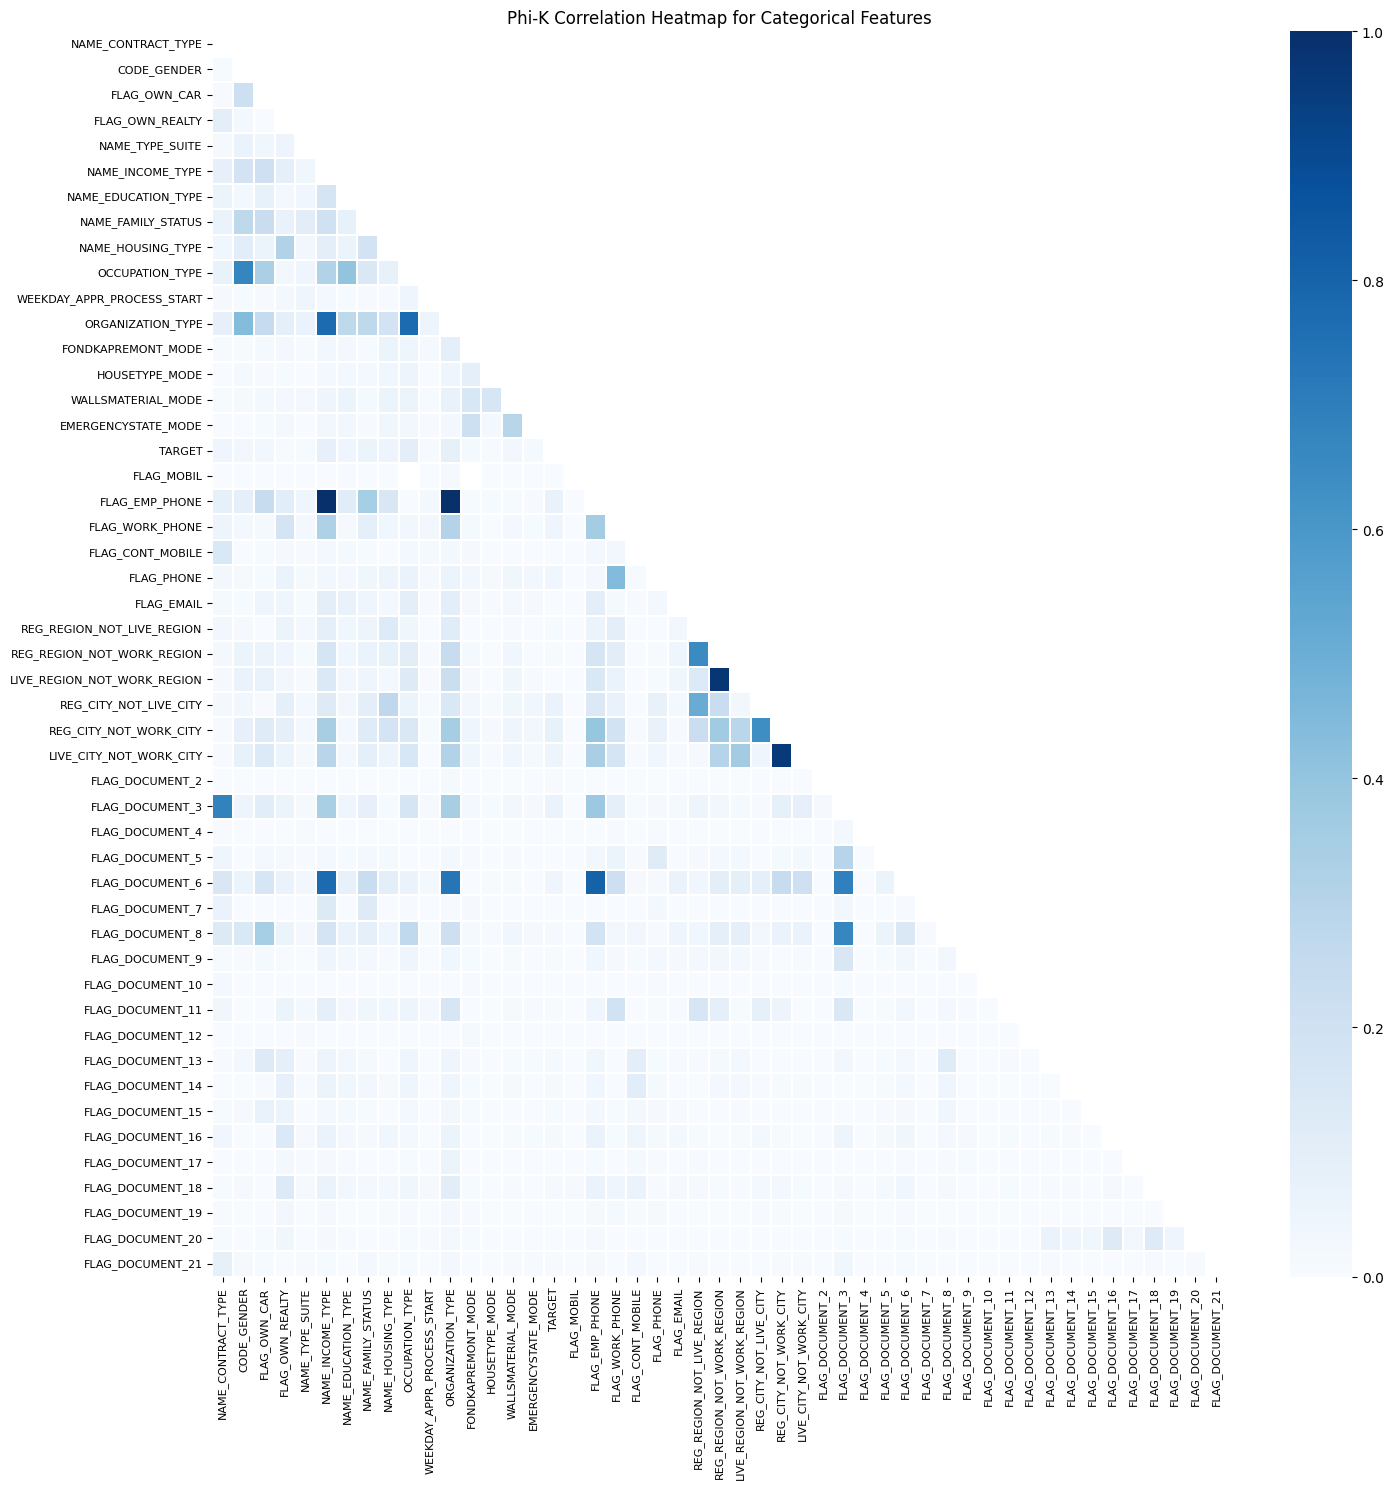

----------------------------------------------------------------------------------------------------
Categories with highest values of Phi-K Correlation value with Target Variable are:


Column Name  Phik-Correlation
15                  TARGET          1.000000
8          OCCUPATION_TYPE          0.102846
10       ORGANIZATION_TYPE          0.089164
4         NAME_INCOME_TYPE          0.084831
26  REG_CITY_NOT_WORK_CITY          0.079946
17          FLAG_EMP_PHONE          0.072087
25  REG_CITY_NOT_LIVE_CITY          0.069588
29         FLAG_DOCUMENT_3          0.069525
6       NAME_FAMILY_STATUS          0.056043
7        NAME_HOUSING_TYPE          0.051107

----------------------------------------------------------------------------------------------------


In [ ]:
plot_phik_matrix(application_train , categorical_cols + booleans, figsize = (15,15), fontsize = 8)

#### Matrice de correlation

----------------------------------------------------------------------------------------------------


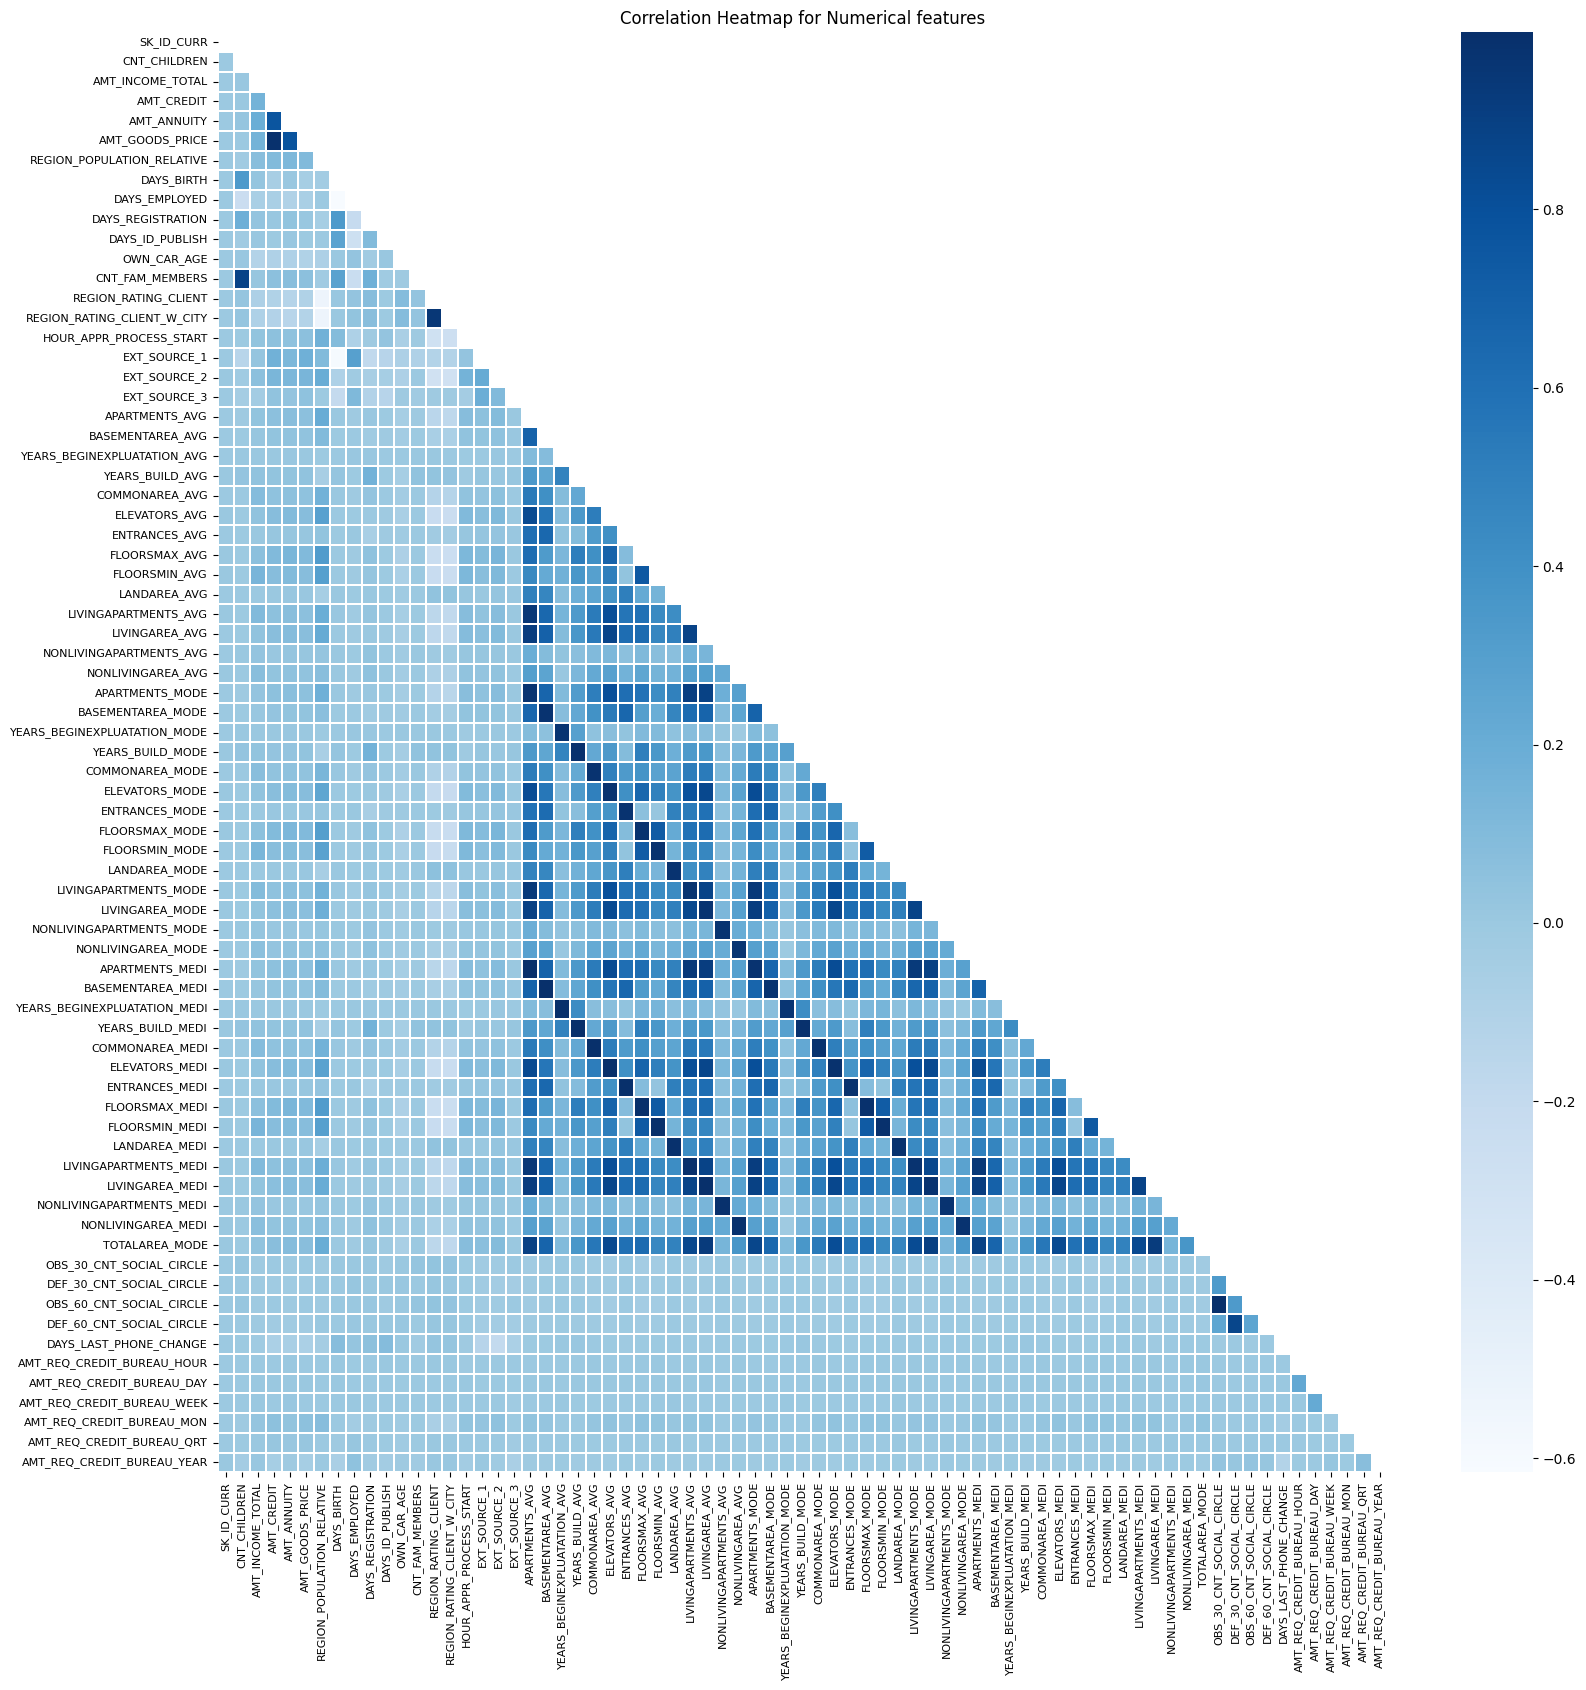

----------------------------------------------------------------------------------------------------


In [ ]:
corr_mat = correlation_matrix(application_train, categorical_cols + booleans, figsize = (17,17), fontsize = 8)#, cmap = 'inferno'
corr_mat.plot_correlation_matrix()

In [ ]:
# Top columns with highest phik-correlation with the target variable in application_train
top_corr_target_df = corr_mat.target_top_corr()
print("-" * 100)
print("Columns with highest values of Phik-correlation with Target Variable are:")
display(top_corr_target_df)
print("-"*100)

interval columns not set, guessing: ['TARGET', 'SK_ID_CURR']
interval columns not set, guessing: ['TARGET', 'CNT_CHILDREN']
interval columns not set, guessing: ['TARGET', 'AMT_INCOME_TOTAL']
interval columns not set, guessing: ['TARGET', 'AMT_CREDIT']
interval columns not set, guessing: ['TARGET', 'AMT_ANNUITY']
interval columns not set, guessing: ['TARGET', 'AMT_GOODS_PRICE']
interval columns not set, guessing: ['TARGET', 'REGION_POPULATION_RELATIVE']
interval columns not set, guessing: ['TARGET', 'DAYS_BIRTH']
interval columns not set, guessing: ['TARGET', 'DAYS_EMPLOYED']
interval columns not set, guessing: ['TARGET', 'DAYS_REGISTRATION']
interval columns not set, guessing: ['TARGET', 'DAYS_ID_PUBLISH']
interval columns not set, guessing: ['TARGET', 'OWN_CAR_AGE']
interval columns not set, guessing: ['TARGET', 'CNT_FAM_MEMBERS']
interval columns not set, guessing: ['TARGET', 'REGION_RATING_CLIENT']
interval columns not set, guessing: ['TARGET', 'REGION_RATING_CLIENT_W_CITY']
interva

Column Name  Phik-Correlation
18            EXT_SOURCE_3          0.247680
16            EXT_SOURCE_1          0.217846
17            EXT_SOURCE_2          0.213965
7               DAYS_BIRTH          0.102395
66  DAYS_LAST_PHONE_CHANGE          0.073215
8            DAYS_EMPLOYED          0.072094
10         DAYS_ID_PUBLISH          0.067769
5          AMT_GOODS_PRICE          0.059093
26           FLOORSMAX_AVG          0.058673
54          FLOORSMAX_MEDI          0.058445

----------------------------------------------------------------------------------------------------


Observations et Conclusions :

Le heatmap fait bien ressortir la valeur ou le niveau de corrélation que chaque caractéristique particulière a avec toutes les autres caractéristiques.
Il peut être observé que la plupart du heatmap contient une couleur plus claire qui indique une valeur très faible de corrélation. Cela implique que la plupart des caractéristiques ne sont effectivement pas corrélées entre elles.

Cependant, nous pouvons voir des nuances contrastées au centre du heatmap. Ces nuances représentent une forte corrélation entre les caractéristiques. Ce sont principalement les caractéristiques liées aux statistiques des appartements.

Si nous examinons les caractéristiques de application_train, nous pouvons clairement voir que les statistiques des appartements sont données en termes de moyenne, médiane et mode, il est donc prévisible que la moyenne, la médiane et le mode soient corrélés entre eux. Un autre point à noter est que les caractéristiques au sein d'une catégorie particulière, par exemple la Moyenne, sont également corrélées avec d'autres caractéristiques de moyenne, telles que le nombre d'ascenseurs, la superficie habitable, la superficie non habitée, la superficie du sous-sol, etc.
Nous observons également une forte corrélation entre AMT_GOODS_PRICE et AMT_CREDIT, ainsi qu'entre DAYS_EMPLOYED et DAYS_BIRTH.

Nous ne voudrions pas de caractéristiques hautement corrélées, car elles augmentent la complexité temporelle du modèle sans apporter une grande valeur ajoutée. Par conséquent, nous supprimerons les caractéristiques inter-corrélées.

Parmi toutes les caractéristiques, nous observons une forte corrélation pour les caractéristiques EXT_SOURCE par rapport à la variable cible. Celles-ci pourraient être importantes pour notre tâche de classification.



```
# Ce texte est au format code
```

#### Analyse des variables catégorielles

##### Distribution de NAME_CONTRACT_TYPE

In [26]:
print_unique_categories(application_train, 'NAME_CONTRACT_TYPE')

#plotting the Pie Plot for the column
plot_categorical_variables_pie(application_train, 'NAME_CONTRACT_TYPE', hole = 0.2)
print('-'*100)

----------------------------------------------------------------------------------------------------
The unique categories of 'NAME_CONTRACT_TYPE' are:
['Cash loans' 'Revolving loans']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------


Observations et Conclusions :

À partir du graphique ci-dessus, nous pouvons tirer les observations et conclusions suivantes :

À partir du premier sous-graphe, c’est-à-dire la distribution globale :
- On peut voir que la majorité des prêts contractés par les clients sont des prêts en espèces (Cash Loans).
- Seulement 9,52 % des personnes ont contracté des prêts renouvelables (Revolving Loans).

À partir du deuxième sous-graphe, c’est-à-dire le pourcentage de défaillants :
- On observe qu’un plus grand pourcentage de personnes ont fait défaut avec des prêts en espèces (8,35 %) par rapport à celles ayant fait défaut avec des prêts renouvelables (5,48 %).

#### Distribution de CODE_GENDER

In [ ]:
print_unique_categories(application_train, 'CODE_GENDER', show_counts = True)

#plotting the Pie Plot for the Column
plot_categorical_variables_pie(application_train, 'CODE_GENDER', hole = 0.5)
print('-'*100)

----------------------------------------------------------------------------------------------------
The unique categories of 'CODE_GENDER' are:
['M' 'F' 'XNA']
----------------------------------------------------------------------------------------------------
Counts of each category are:
CODE_GENDER
F      202448
M      105059
XNA         4
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------


Observations et Conclusions :

La distribution de la variable CODE_GENDER semble intéressante. Voici quelques points à retenir :

- Le premier point à observer est qu’il y a 4 lignes dans la table application_train dont le genre est 'XNA', ce qui n’a pas vraiment de sens, et peut être considéré comme des valeurs manquantes (NaN). Étant donné qu’il n’y en a que 4, et qu’elles appartiennent uniquement à la catégorie des non-défaillants, nous pouvons éliminer ces lignes sans trop d’hésitation.

- D’après le premier sous-graphe, on constate que dans l’ensemble de données, il y a plus de femmes candidates (65,8 %) que d’hommes (34,2 %).

- Cependant, contrairement à leur plus grand nombre, le deuxième graphique montre que les hommes ont un taux de défaut plus élevé (10,14 %) comparé aux femmes (7 %).

Ainsi, on peut dire que, selon cet ensemble de données, les hommes ont une plus grande tendance à faire défaut que les femmes.

##### Distribution de FLAG_EMP_PHONE

In [ ]:
print_unique_categories(application_train, 'FLAG_EMP_PHONE')

#plotting the Pie Plot for the Column
plot_categorical_variables_pie(application_train, column_name = 'FLAG_EMP_PHONE', hole = 0.5)
print('-'*100)

----------------------------------------------------------------------------------------------------
The unique categories of 'FLAG_EMP_PHONE' are:
[1 0]
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------


Cette caractéristique comporte deux catégories, à savoir si le client a fourni ou non son numéro de téléphone professionnel lors du processus d'inscription ou de demande.

D’après le premier sous-graphe, on observe que la majorité des demandeurs ne fournissent pas leur numéro de téléphone professionnel (82 %), tandis que seulement 18 % l’ont fourni.
On remarque également que la tendance au défaut de paiement est plus élevée chez ceux qui ont fourni leur numéro de téléphone professionnel que chez ceux qui ne l'ont pas fourni.
Cette caractéristique pourrait s'expliquer par le fait que les emprunteurs susceptibles de faire défaut préfèrent fournir leur numéro professionnel afin de ne pas être dérangés sur leur téléphone personnel.

##### Distribution de REGION_RATING_CLIENT_W_CITY

In [ ]:
print_unique_categories(application_train, 'REGION_RATING_CLIENT_W_CITY')

#plotting the Pie Plot for the Column
plot_categorical_variables_pie(application_train, column_name = 'REGION_RATING_CLIENT_W_CITY')
print('-'*100)


----------------------------------------------------------------------------------------------------
The unique categories of 'REGION_RATING_CLIENT_W_CITY' are:
[2 1 3]
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------


À partir des graphiques ci-dessus, nous pouvons tirer les enseignements suivants :

D’après le premier sous-graphe, on constate que la majorité des clients (74,6 %) ont une note régionale de 2. Il s’agit de la valeur moyenne attribuée à la plupart des demandeurs.
Très peu de demandeurs ont une note régionale de 1 (seulement 11,1 %), et certains ont une note de 3 (14,3 %).
Parmi les emprunteurs en défaut de paiement, on observe que la plupart d’entre eux ont une note régionale de 3 (11,4 %), ce qui est relativement plus élevé par rapport aux deux autres notes : les clients ayant une note de 1 présentent un taux de défaut de seulement 4,84 %, tandis que ceux ayant une note de 2 ont un taux de 7,92 %.
Cela montre que la note 3 pourrait constituer un attribut important dans la prise de décision concernant les caractéristiques des clients à risque de défaut.

##### Distribution de Categorical Variable NAME_EDUCAtION_TYPE

----------------------------------------------------------------------------------------------------
The unique categories of 'NAME_EDUCATION_TYPE' are:
['Secondary / secondary special' 'Higher education' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
----------------------------------------------------------------------------------------------------
Counts of each category are:
NAME_EDUCATION_TYPE
Secondary / secondary special    218391
Higher education                  74863
Incomplete higher                 10277
Lower secondary                    3816
Academic degree                     164
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
Total Number of unique categories of NAME_EDUCATION_TYPE = 5


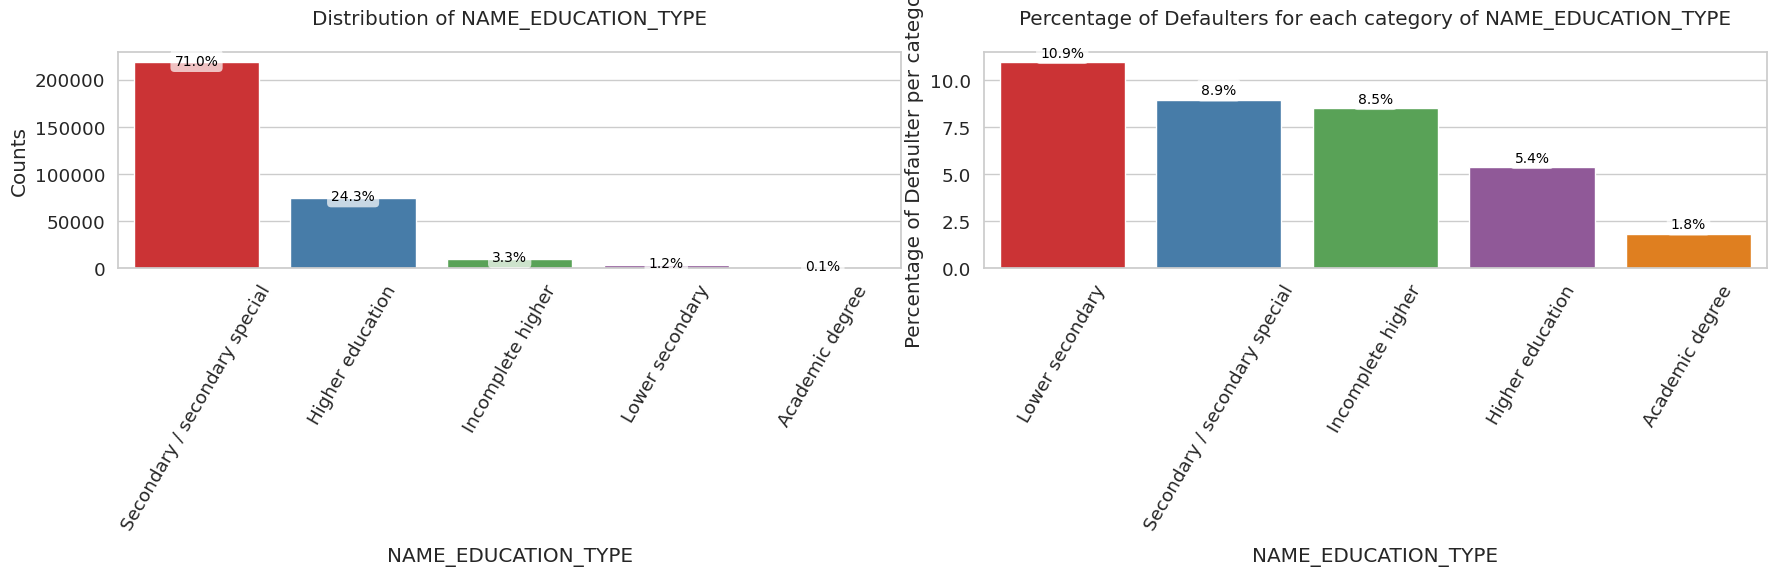

----------------------------------------------------------------------------------------------------


In [ ]:
print_unique_categories(application_train, 'NAME_EDUCATION_TYPE', show_counts = True)

#plotting the Bar Plot for the Column
plot_categorical_variables_bar(application_train, column_name = 'NAME_EDUCATION_TYPE', rotation = 60, horizontal_adjust = 0.25)
print('-'*100)

Observations et conclusions :

En observant les graphiques ci-dessus, nous pouvons conclure ce qui suit :

Environ 71 % des personnes ont un niveau d’éducation limité au secondaire ou secondaire spécialisé, tandis que 24,34 % des clients ont suivi un enseignement supérieur. Cela suggère que la majorité des clients/emprunteurs n’ont pas un niveau d’éducation élevé.
D’après le second graphique, les personnes dont le niveau d’études s’arrête au secondaire inférieur présentent les caractéristiques de défaut les plus élevées, tandis que celles ayant un niveau secondaire ou un enseignement supérieur incomplet affichent des tendances similaires au défaut.
Le groupe ayant suivi un enseignement supérieur présente une tendance au défaut relativement plus faible, ce qui est également logique. De plus, les personnes titulaires d’un diplôme académique montrent le taux de défaut le plus bas. Cependant, ce groupe est très peu représenté numériquement, ce qui limite son utilité dans l’analyse.


##### Distribution de Categorical Variable OCCUPATION_TYPE

----------------------------------------------------------------------------------------------------
The unique categories of 'OCCUPATION_TYPE' are:
['Laborers' 'Core staff' 'Accountants' 'Managers' nan 'Drivers'
 'Sales staff' 'Cleaning staff' 'Cooking staff' 'Private service staff'
 'Medicine staff' 'Security staff' 'High skill tech staff'
 'Waiters/barmen staff' 'Low-skill Laborers' 'Realty agents' 'Secretaries'
 'IT staff' 'HR staff']
----------------------------------------------------------------------------------------------------
Total Number of unique categories of OCCUPATION_TYPE = 19


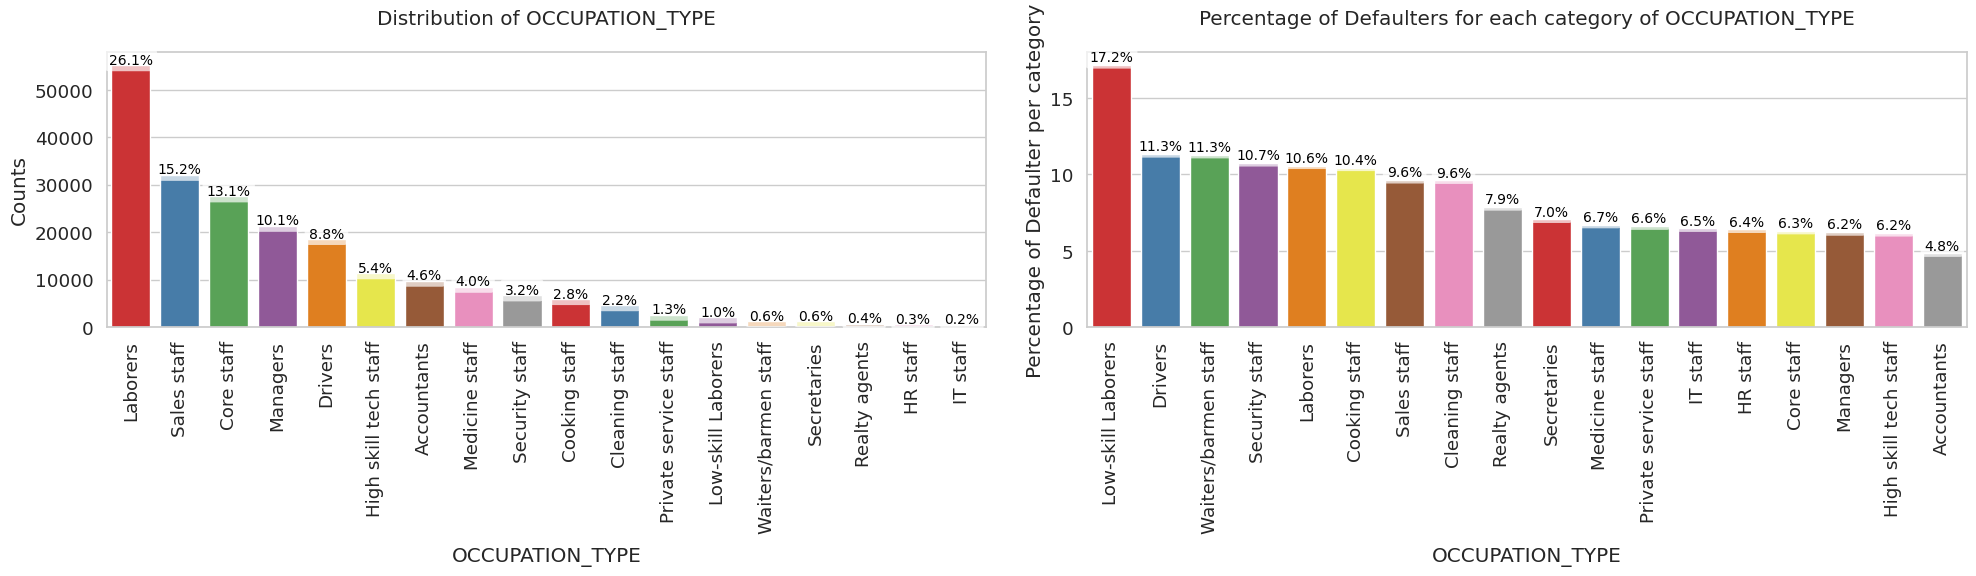

----------------------------------------------------------------------------------------------------


In [ ]:
print_unique_categories(application_train, 'OCCUPATION_TYPE')

#plotting the Bar Plot for the Column
plot_categorical_variables_bar(application_train, column_name = 'OCCUPATION_TYPE', figsize = (20,6), rotation = 90)
print('-'*100)

Observations et conclusions :

Parmi les demandeurs, le type de profession le plus courant est celui de manœuvre/ouvrier (Laborers), représentant près de 26 % des demandes. La profession suivante en fréquence est le personnel de vente, suivie par le personnel de base (Core Staff) et les cadres/dirigeants (Managers).

Le taux de défaut le plus élevé est observé chez les ouvriers peu qualifiés, avec environ 17,5 %, ce qui est supérieur à tous les autres types de professions. Viennent ensuite les chauffeurs, serveurs, agents de sécurité, ouvriers, cuisiniers, etc. — toutes des professions considérées comme peu qualifiées. Cela montre que les personnes exerçant des emplois peu qualifiés ont tendance à présenter un taux de défaut plus élevé.

À l’inverse, les taux de défaut les plus faibles sont enregistrés chez les comptables, personnel de base qualifié, cadres, techniciens qualifiés, ressources humaines, etc., qui occupent des postes de niveau moyen à élevé.

On peut donc conclure que les travailleurs occupant des emplois peu qualifiés ont une tendance au défaut de paiement plus élevée que ceux occupant des emplois de niveau moyen à élevé.

##### Distribution de ORGANIZATION_TYPE

In [ ]:
# print(f"Total Number of categories of ORGANIZATION_TYPE = {len(application_train.ORGANIZATION_TYPE.unique())}")

# plt.figure(figsize = (25,16))
# # sns.set(style = 'whitegrid', font_scale = 1.2)
# plt.subplots_adjust(wspace=0.25)

# plt.subplot(1,2,1)
# count_organization = application_train.ORGANIZATION_TYPE.value_counts().sort_values(ascending = False)
# sns.barplot(x = count_organization, y = count_organization.index)
# plt.title('Distribution of ORGANIZATION_TYPE', pad = 20)
# plt.xlabel('Counts')
# plt.ylabel('ORGANIZATION_TYPE')

# plt.subplot(1,2,2)
# percentage_default_per_organization = application_train[application_train.TARGET == 1].ORGANIZATION_TYPE.value_counts() * 100 / count_organization
# percentage_default_per_organization = percentage_default_per_organization.dropna().sort_values(ascending = False)
# sns.barplot(x = percentage_default_per_organization, y = percentage_default_per_organization.index)
# plt.title('Percentage of Defaulters for each category of ORGANIZATION_TYPE', pad = 20)
# plt.xlabel('Percentage of Defaulters per category')
# plt.ylabel('ORGANIZATION_TYPE')

# plt.show()

----------------------------------------------------------------------------------------------------
The unique categories of 'ORGANIZATION_TYPE' are:
['Business Entity Type 3' 'School' 'Government' 'Religion' 'Other' 'XNA'
 'Electricity' 'Medicine' 'Business Entity Type 2' 'Self-employed'
 'Transport: type 2' 'Construction' 'Housing' 'Kindergarten'
 'Trade: type 7' 'Industry: type 11' 'Military' 'Services'
 'Security Ministries' 'Transport: type 4' 'Industry: type 1' 'Emergency'
 'Security' 'Trade: type 2' 'University' 'Transport: type 3' 'Police'
 'Business Entity Type 1' 'Postal' 'Industry: type 4' 'Agriculture'
 'Restaurant' 'Culture' 'Hotel' 'Industry: type 7' 'Trade: type 3'
 'Industry: type 3' 'Bank' 'Industry: type 9' 'Insurance' 'Trade: type 6'
 'Industry: type 2' 'Transport: type 1' 'Industry: type 12' 'Mobile'
 'Trade: type 1' 'Industry: type 5' 'Industry: type 10' 'Legal Services'
 'Advertising' 'Trade: type 5' 'Cleaning' 'Industry: type 13'
 'Trade: type 4' 'Telecom' 'Indu

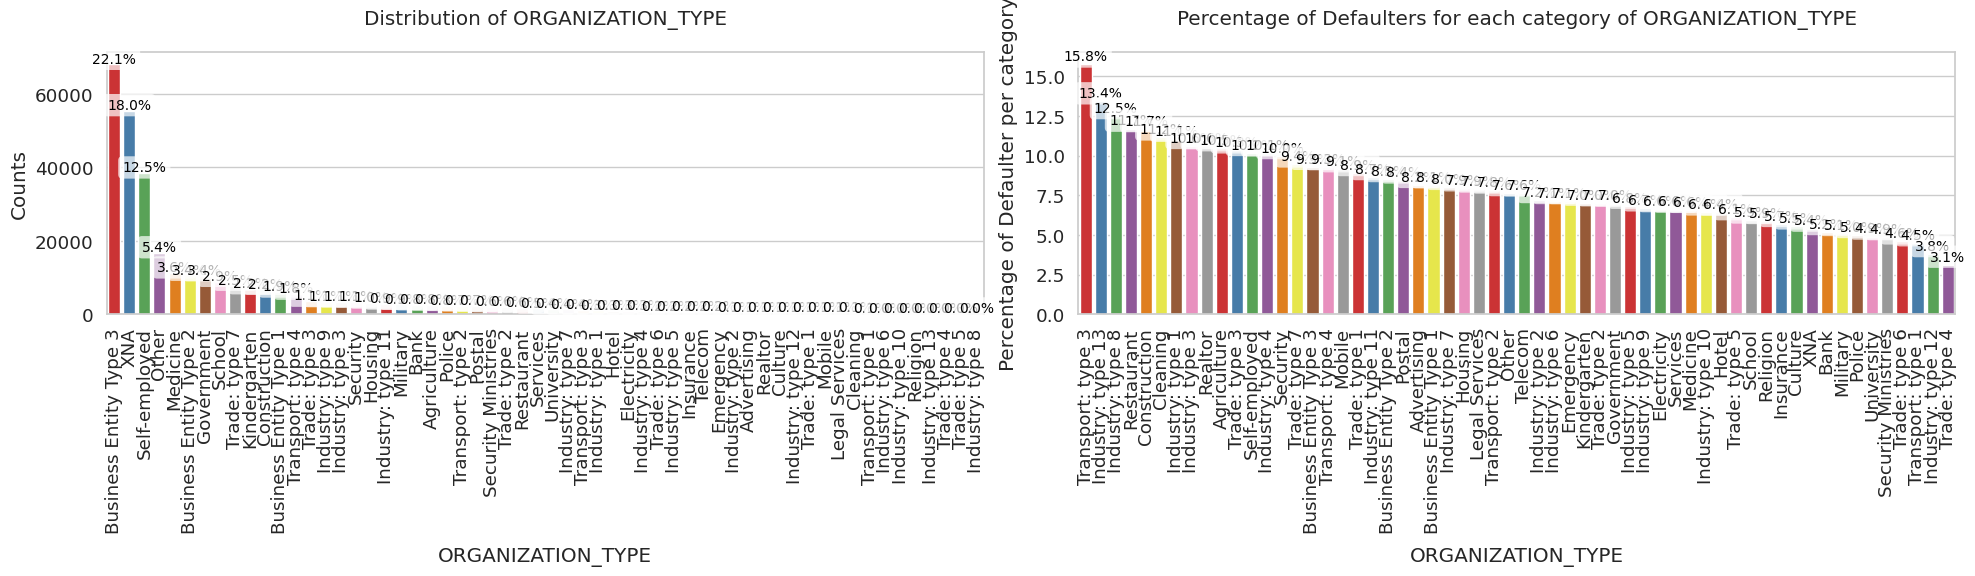

----------------------------------------------------------------------------------------------------


In [ ]:
print_unique_categories(application_train, 'ORGANIZATION_TYPE')

#plotting the Bar Plot for the Column
plot_categorical_variables_bar(application_train, column_name = 'ORGANIZATION_TYPE', figsize = (20,6), rotation = 90)
print('-'*100)

Observations et conclusions :

Il existe de nombreux types d'organisations auxquels les clients peuvent appartenir, 58 pour être précis. Les graphiques ci-dessus permettent de tirer les observations suivantes :

D’après le premier graphique, on constate que la majorité des demandeurs travaillent dans des organisations **de type « Business Entity Type 3 », « XNA » ou « Travailleur indépendant (Self Employed) ».** Le type d’organisation « XNA » pourrait probablement désigner un type d’organisation non classifié.

Le second graphique montre que les demandeurs appartenant au type « Transport : type 3 » présentent la tendance au défaut la plus élevée, comparativement aux autres. Ils sont suivis par les types d’organisation « Industry : type 13 », « Industry : type 8 », « Restaurant », « Construction », etc.

Les organisations affichant les taux de défaut les plus faibles sont « Trade : type 4 », « Industry : type 12 », etc. Ces numéros de type pourraient également fournir plus d'informations sur la nature des organisations, mais n’ayant aucune information complémentaire à ce sujet, nous nous en tiendrons aux noms qui nous ont été fournis.

##### Distribution des variables REG_CITY_NOT_LIVE_CITY, REG_CITY_NOT_WORK_CITY, LIVE_CITY_NOT_WORK_CITY

Ici, 1 indique des adresses différentes et 0 indique des adresses identiques.

----------------------------------------------------------------------------------------------------
Total Number of unique categories of REG_CITY_NOT_LIVE_CITY = 2


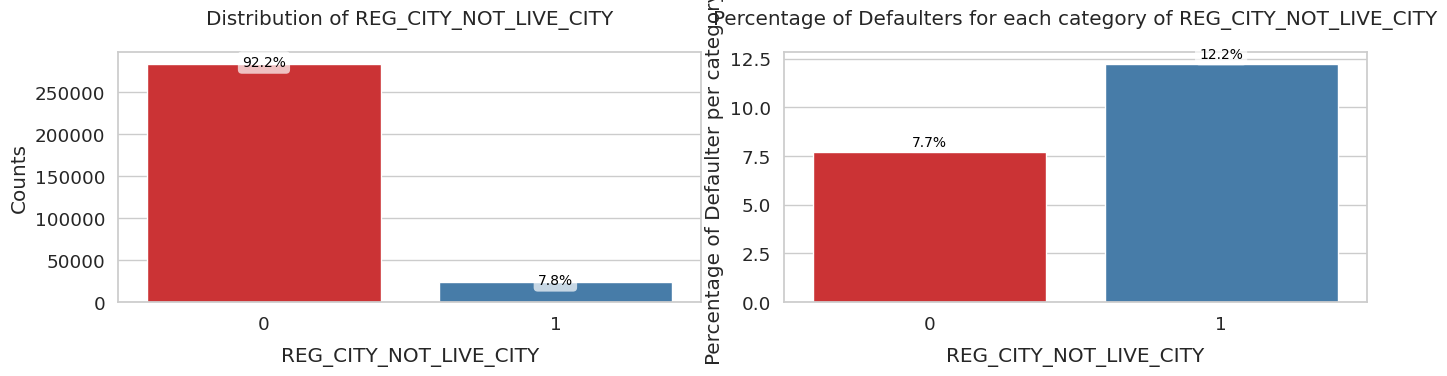

----------------------------------------------------------------------------------------------------
Total Number of unique categories of REG_CITY_NOT_WORK_CITY = 2


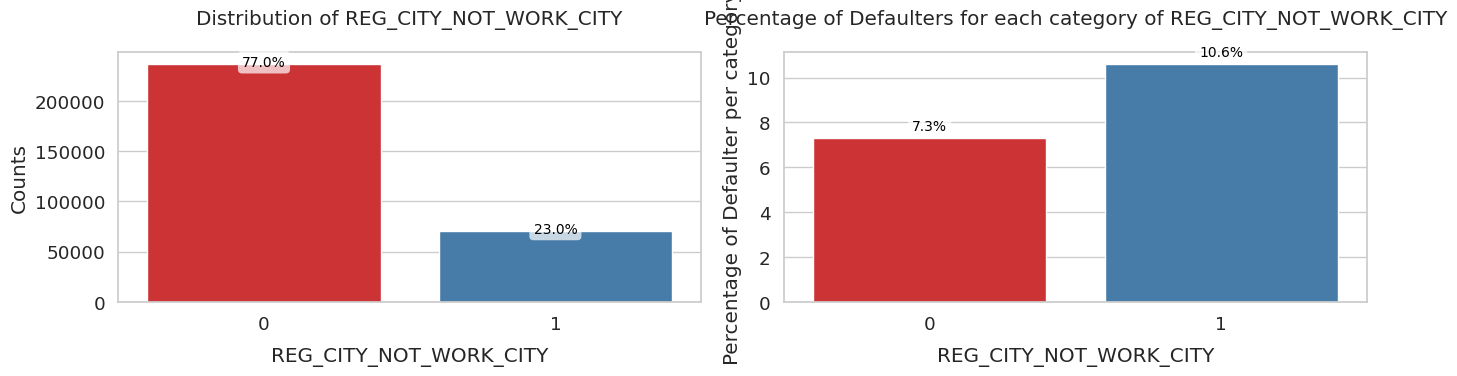

----------------------------------------------------------------------------------------------------
Total Number of unique categories of LIVE_CITY_NOT_WORK_CITY = 2


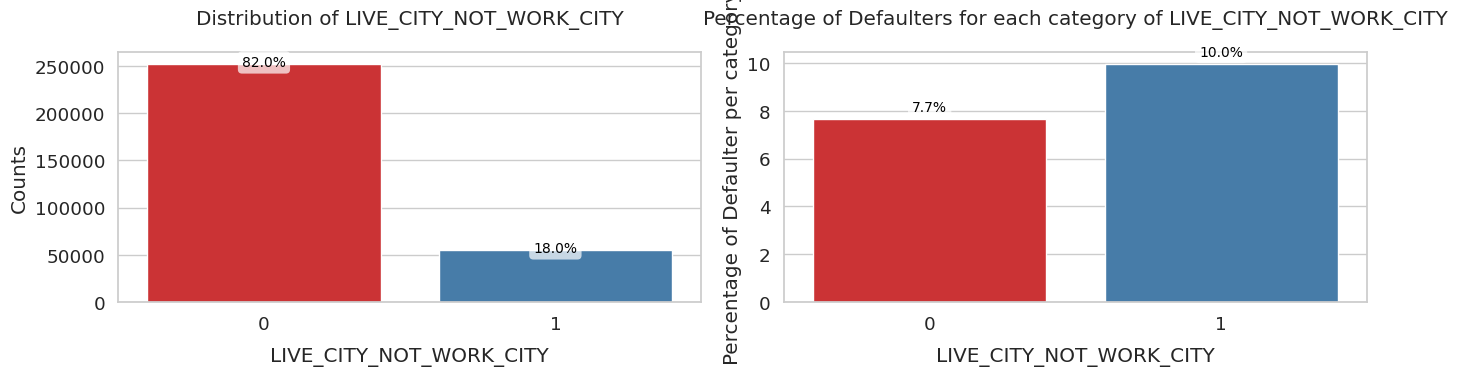

----------------------------------------------------------------------------------------------------


In [ ]:
print('-'*100)
plot_categorical_variables_bar(application_train, column_name = 'REG_CITY_NOT_LIVE_CITY', figsize = (14, 4), horizontal_adjust = 0.33)
print('-'*100)
plot_categorical_variables_bar(application_train, column_name = 'REG_CITY_NOT_WORK_CITY', figsize = (14, 4), horizontal_adjust = 0.33)
print('-'*100)
plot_categorical_variables_bar(application_train, column_name = 'LIVE_CITY_NOT_WORK_CITY', figsize = (14, 4), horizontal_adjust = 0.33)
print('-'*100)

Observations et conclusions :

À partir des trois graphiques ci-dessus, on peut tirer les enseignements suivants :

Parmi tous les demandeurs, seule une minorité présente des adresses qui ne correspondent pas.

- Premièrement, seuls **7,52 %** des personnes ont une **adresse permanente différente de leur adresse de contact au niveau régional.**
- Deuxièmement, environ **23,05 %** des personnes ont une adresse permanente différente de leur adresse professionnelle au niveau régional. Ce chiffre plus élevé peut s’expliquer par le fait qu’il est courant de travailler dans une région différente de celle de son domicile permanent.
- Enfin, environ **17,96 %** ont une **adresse permanente différente de leur adresse de contact au niveau de la ville.**

En ce qui concerne les caractéristiques des emprunteurs en défaut, on observe que la tendance au défaut est la plus élevée chez les personnes ayant une adresse permanente et une adresse de contact différentes au niveau régional, suivies par celles ayant une adresse permanente différente de l'adresse professionnelle, puis par celles avec une adresse différente au niveau de la ville.

Dans tous les cas, il est clair que les personnes ayant des adresses différentes présentent une tendance au défaut plus élevée que celles dont les adresses sont identiques. Cela laisse penser que cette différence d'adresse pourrait être un indicateur de risque de défaut.

##### Distribution de FLAG_DOCUMENT_3

In [ ]:
plot_categorical_variables_pie(application_train, column_name = 'FLAG_DOCUMENT_3', hole = 0.2)

Observations et conclusions :
À partir du graphique ci-dessus, on peut observer ce qui suit :

D’après le premier sous-graphe, la majorité des clients n’ont pas fourni ce document (environ 71 %), tandis que seulement 29 % l’ont fourni.

Selon le deuxième sous-graphe, les personnes n’ayant pas fourni le Document_3 présentent un taux de défaut plus élevé (8,84 %) que celles qui l’ont fourni (6,18 %).
Cela suggère que les demandeurs ayant fourni le Document_3 sont en moyenne moins susceptibles de faire défaut que ceux qui ne l’ont pas fourni.

#### Plot Continuous Variables

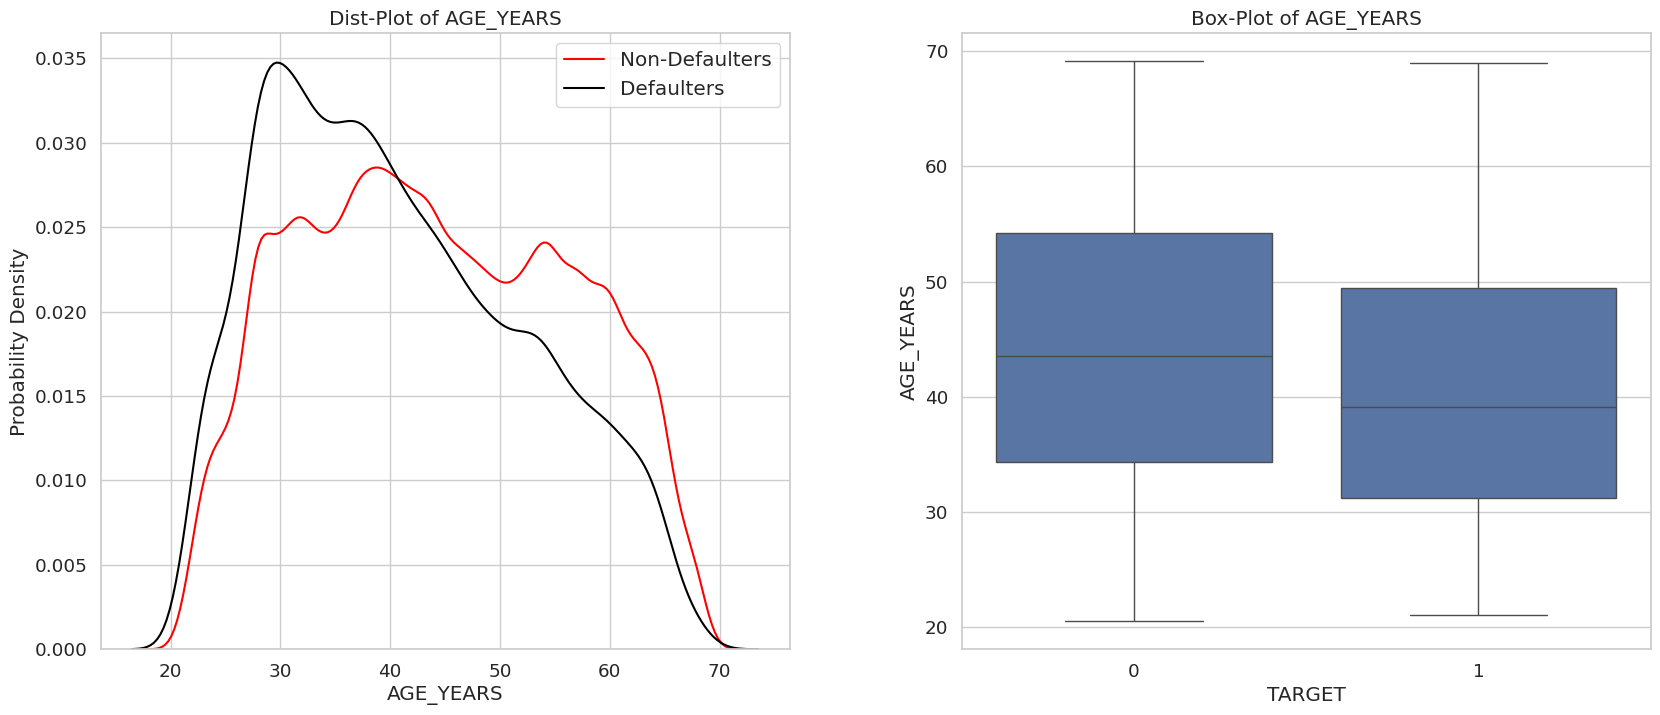

In [ ]:
application_train['AGE_YEARS'] = application_train['DAYS_BIRTH'] * -1 / 365
plot_continuous_variables(application_train, 'AGE_YEARS', plots = ['distplot','box'])
_ = application_train.pop('AGE_YEARS')

Observations et conclusions :
À partir des deux graphiques ci-dessus, nous pouvons tirer quelques enseignements importants.

À partir du distplot, nous pouvons observer que le pic d'âge des personnes en défaut se situe près de 30 ans. De plus, à ce point, la fonction de densité de probabilité (PDF) des Non-Défautants est relativement plus faible. Il est également à noter que la PDF des âges des Défaillants commence légèrement à gauche de celle des Non-Défautants et reste plus uniforme tout au long de la plage d'âges. Cela signifie que les Défaillants sont généralement plus jeunes que les Non-Défautants.

Dans le CDF, nous constatons également que la probabilité de défaut est plus élevée chez les jeunes.
Le box-plot montre également la même chose de manière plus claire. L'âge des Défaillants est généralement inférieur à celui des Non-Défautants. Tous les quantiles des âges des Défaillants sont inférieurs à ceux des Non-Défautants. Le 75e percentile des Non-Défautants se situe autour de 54 ans, tandis que pour les Défaillants, il est près de 49 ans.

Ces observations suggèrent que les Défaillants sont généralement plus jeunes que les Non-Défautants.

In [ ]:
application_train['DAYS_BIRTH'].loc[:5]

0    -9461
1   -16765
2   -19046
3   -19005
4   -19932
5   -16941
Name: DAYS_BIRTH, dtype: int64

##### DAYS_EMPLOYED

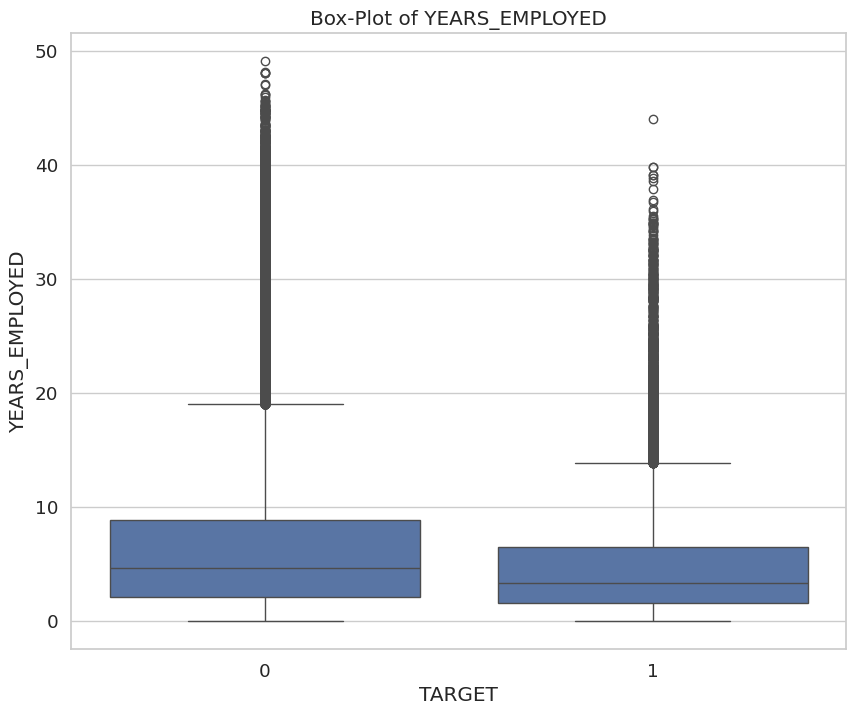

In [ ]:
application_train['YEARS_EMPLOYED'] = application_train.DAYS_EMPLOYED * -1 / 365
plot_continuous_variables(application_train, 'YEARS_EMPLOYED', plots = ['box'], scale_limits = [0,70], figsize = (10,8))
_ = application_train.pop('YEARS_EMPLOYED')

Nous observons que la colonne DAYS_EMPLOYED contient des données erronées avec des valeurs de 365243. Cela semble correspondre à des valeurs erronées ou non pertinentes.
D’après le box plot, nous constatons que les Défaillants semblent avoir un nombre d'années d'emploi inférieur par rapport aux Non-Défautants. Les quantiles 25e, 50e et 75e des Défaillants sont tous inférieurs à ceux des Non-Défautants.

##### Distribution de EXT_SOURCES

----------------------------------------------------------------------------------------------------


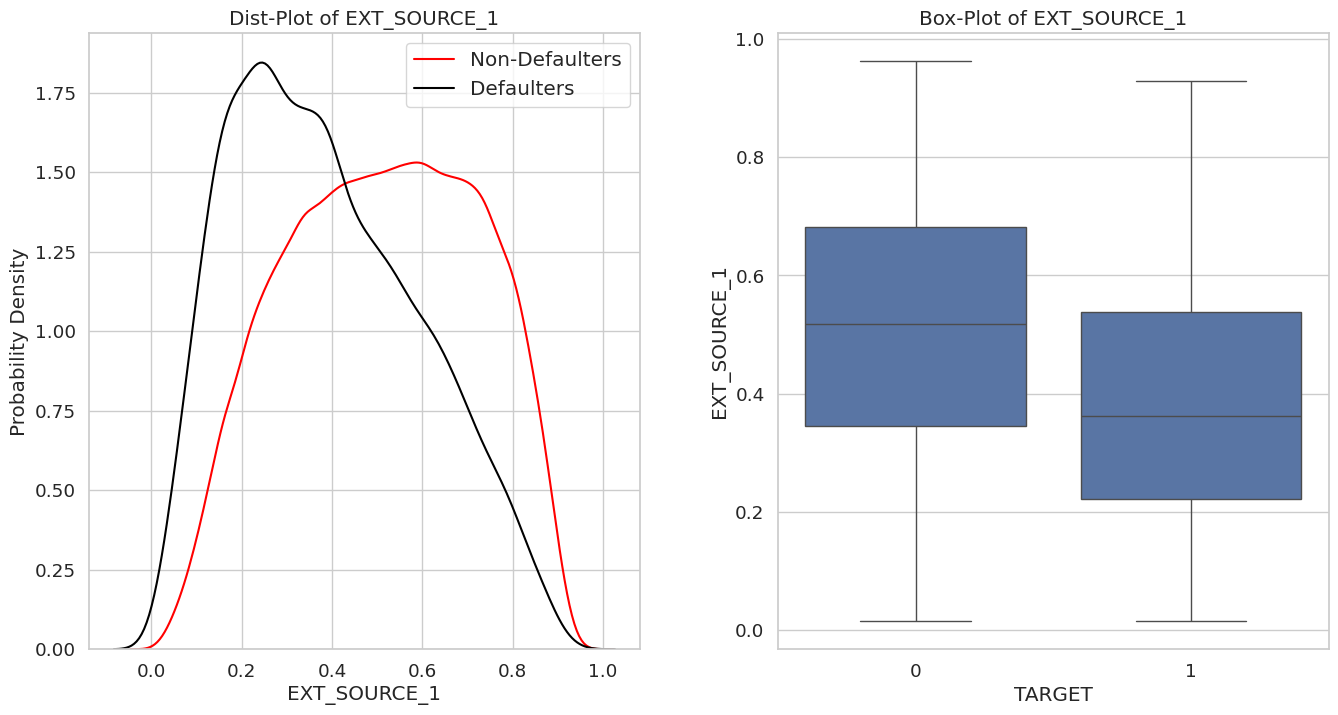

----------------------------------------------------------------------------------------------------


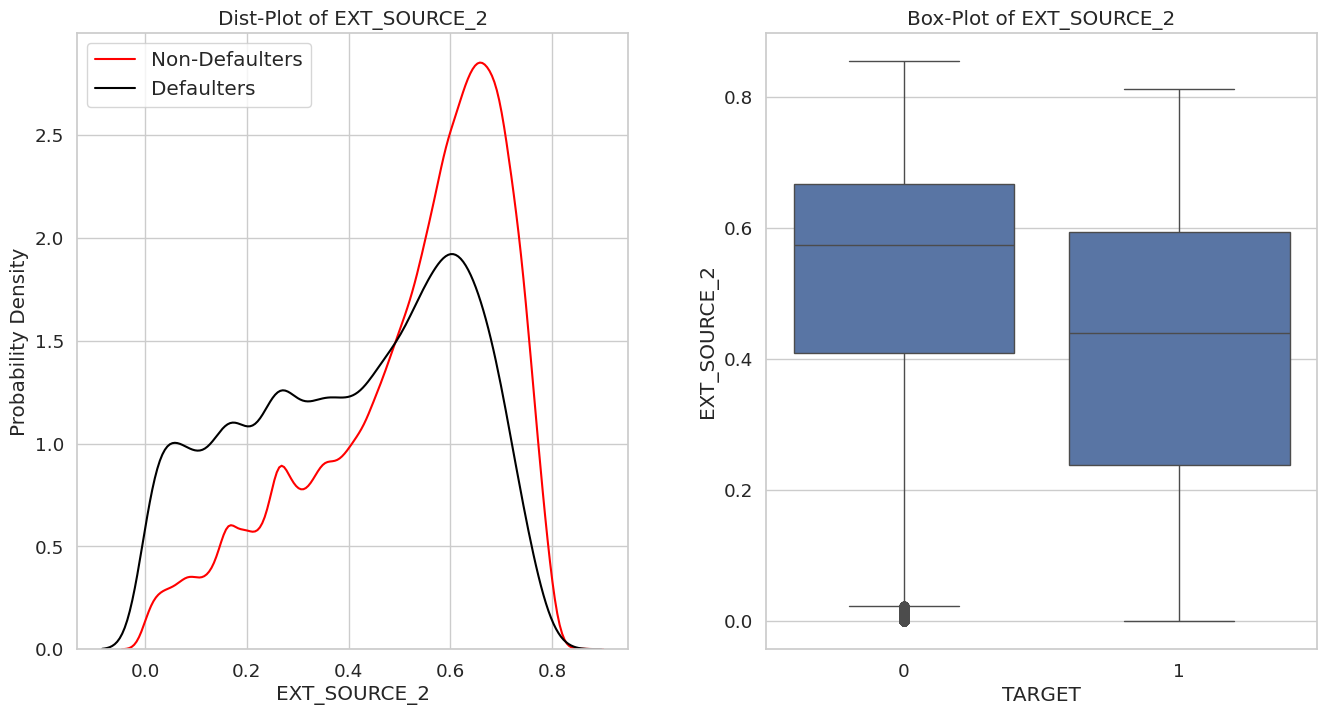

----------------------------------------------------------------------------------------------------


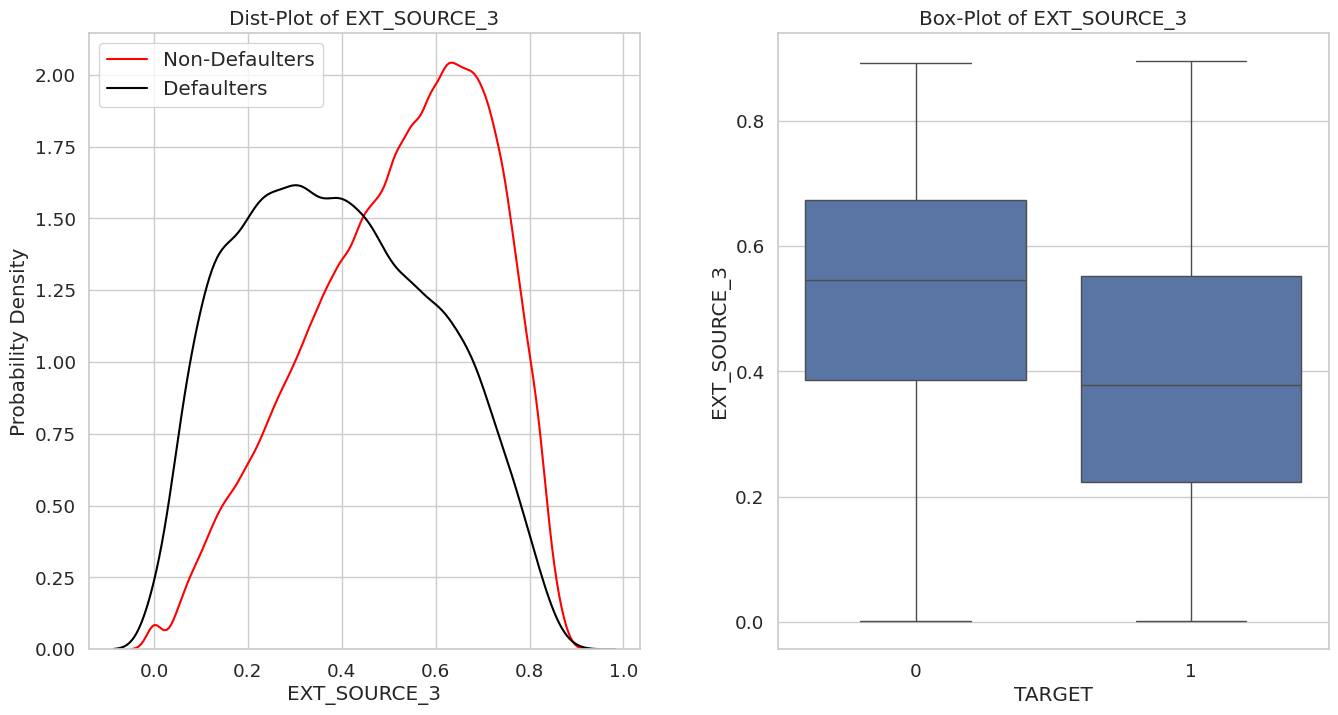

----------------------------------------------------------------------------------------------------


In [ ]:
print('-'*100)
plot_continuous_variables(application_train, 'EXT_SOURCE_1', plots = ['distplot', 'box'], figsize = (16,8))
print('-'*100)
plot_continuous_variables(application_train, 'EXT_SOURCE_2', plots = ['distplot', 'box'], figsize = (16,8))
print('-'*100)
plot_continuous_variables(application_train, 'EXT_SOURCE_3', plots = ['distplot', 'box'], figsize = (16,8))
print('-'*100)

Observations et conclusions :

À partir des trois graphiques ci-dessus, nous pouvons tirer les conclusions suivantes :

En observant les box-plots, on remarque clairement une tendance similaire pour les trois colonnes EXT_SOURCE : les Défaillants ont tendance à avoir des valeurs nettement plus faibles.
Cette tendance se retrouve également dans les PDF (fonctions de densité de probabilité). Les Non-Défautants présentent un pic plus élevé pour des valeurs élevées des EXT_SOURCE, tandis que les densités de probabilité sont très faibles pour les faibles valeurs. Cela signifie que les Non-Défautants ont généralement des scores EXT_SOURCE élevés.
Il est intéressant de noter que la valeur médiane des Défaillants est presque égale ou inférieure au 25e percentile des Non-Défautants.
Les colonnes EXT_SOURCE_1 et EXT_SOURCE_3 semblent offrir une meilleure capacité de discrimination/séparation que EXT_SOURCE_2.
Ces trois variables semblent être les plus efficaces jusqu’à présent pour séparer de manière linéaire les Défaillants des Non-Défautants.

##### Distribution de FLOORSMAX_AVG et FLOORSMIN_MODE

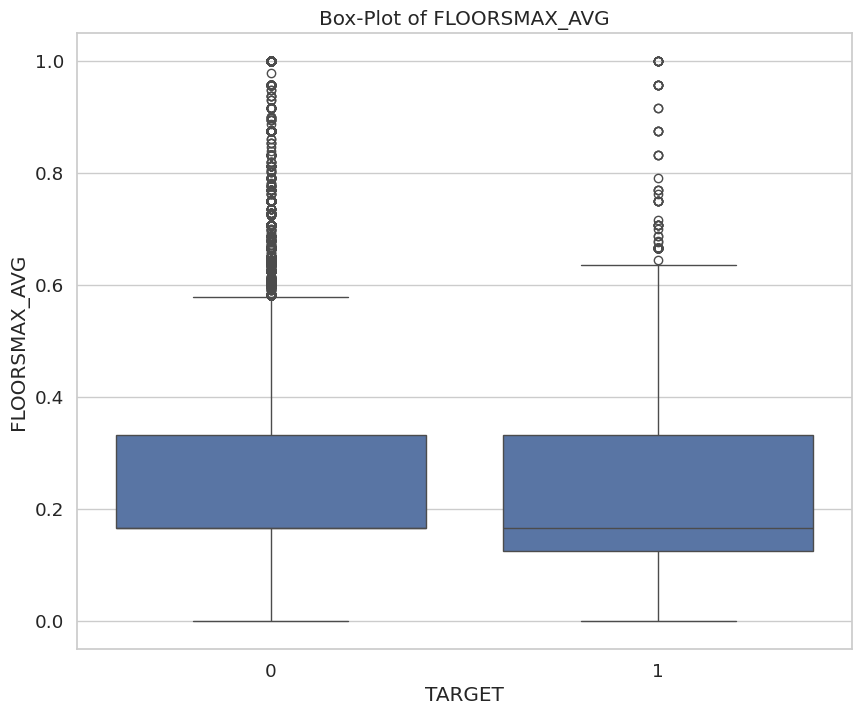

In [ ]:
plot_continuous_variables(application_train, 'FLOORSMAX_AVG', plots = ['box'], figsize = (10,8))

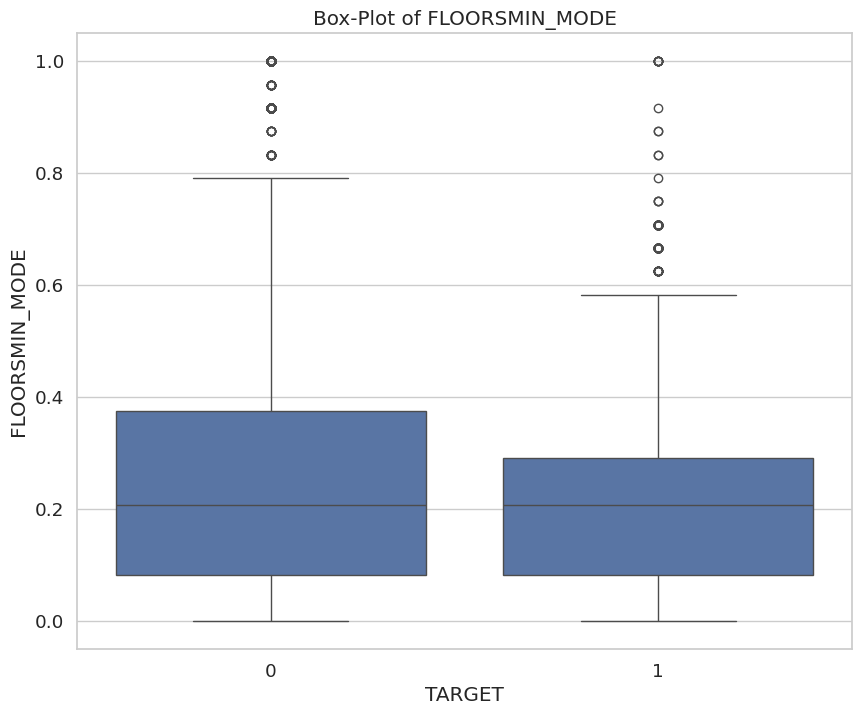

In [ ]:
plot_continuous_variables(application_train, 'FLOORSMIN_MODE', plots = ['box'], figsize = (10,8))

Observations et conclusions:

À partir du graphique ci-dessus, nous pouvons tirer les enseignements suivants :

Les Défaillants présentent une valeur médiane plus faible de la variable **FLOORSMAX_AVG** par rapport aux Non-Défautants. Bien que le 75e percentile soit globalement similaire pour les deux groupes, le 25e percentile des Non-Défautants est presque supérieur à la médiane des Défaillants, ce qui suggère que cette variable pourrait être un indicateur important.

Les Non-Défautants ont également tendance à présenter des valeurs plus élevées pour la variable **FLOORSMIN_MODE** par rapport aux Défaillants. Le 75e percentile des Non-Défautants est nettement supérieur à celui des Défaillants.

#### Bureau

In [ ]:
print(f'La taille du fichier bureau.csv is: {bureau.shape}')
print('-'*100)
print(f'Le nombre d\'identifiants uniques SK_ID_BUREAU dans bureau.csv est: {len(bureau.SK_ID_BUREAU.unique())}')
print(f'Le nombre d\'identifiants uniques SK_ID_CURR in bureau.csv est: {len(bureau.SK_ID_CURR.unique())}')
print(f'Le nombre d\'identifiants SK_ID_CURR communs entre application_train.csv et bureau.csv est: {len(set(application_train.SK_ID_CURR.unique()).intersection(set(bureau.SK_ID_CURR.unique())))}')
print(f'Le nombre d\'identifiants SK_ID_CURR communs entre application_test.csv et bureau.csv est: {len(set(application_test.SK_ID_CURR.unique()).intersection(set(bureau.SK_ID_CURR.unique())))}')
print('-'*100)
print(f'Nombre de doublons: {bureau.shape[0] - bureau.duplicated().shape[0]}')
print('-'*100)
display(bureau.head(5))

La taille du fichier bureau.csv is: (1716428, 17)
----------------------------------------------------------------------------------------------------
Le nombre d'identifiants uniques SK_ID_BUREAU dans bureau.csv est: 1716428
Le nombre d'identifiants uniques SK_ID_CURR in bureau.csv est: 305811
Le nombre d'identifiants SK_ID_CURR communs entre application_train.csv et bureau.csv est: 263491
Le nombre d'identifiants SK_ID_CURR communs entre application_test.csv et bureau.csv est: 42320
----------------------------------------------------------------------------------------------------
Nombre de doublons: 0
----------------------------------------------------------------------------------------------------


SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0      215354       5714462        Closed      currency 1         -497   
1      215354       5714463        Active      currency 1         -208   
2      215354       5714464        Active      currency 1         -203   
3      215354       5714465        Active      currency 1         -203   
4      215354       5714466        Active      currency 1         -629   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0               -153.0             -153.0   
1                   0               1075.0                NaN   
2                   0                528.0                NaN   
3                   0                  NaN                NaN   
4                   0               1197.0                NaN   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                     NaN                   0         91323.0   
1                     NaN                   0        225000.0   
2                     NaN                   0        464323.5   
3                     NaN                   0         90000.0   
4                 77674.5                   0       2700000.0   

   AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                  0.0                   NaN                     0.0   
1             171342.0                   NaN                     0.0   
2                  NaN                   NaN                     0.0   
3                  NaN                   NaN                     0.0   
4                  NaN                   NaN                     0.0   

       CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0  Consumer credit                -131          NaN  
1      Credit card                 -20          NaN  
2  Consumer credit                 -16          NaN  
3      Credit card                 -16          NaN  
4  Consumer credit                 -21          NaN

Observations et Conclusions :

Le fichier bureau.csv contient environ 1,7 million de points de données, répartis sur 17 caractéristiques. Parmi ces 17 caractéristiques, deux sont SK_ID_CURR et SK_ID_BUREAU.
SK_ID_BUREAU correspond à l’identifiant du prêt précédent du client auprès d’autres institutions financières. Il peut y avoir plusieurs prêts antérieurs associés à un seul SK_ID_CURR, ce qui dépend du comportement d'emprunt du client.

    - SK_ID_CURR est l’identifiant du prêt actuel du client auprès de Home Credit.
    - Les autres caractéristiques contiennent diverses statistiques telles que DAYS_CREDIT, AMT_CREDIT_SUM, CREDIT_TYPE, etc.

Il y a 305 000 identifiants uniques SK_ID_CURR dans le fichier bureau, parmi lesquels :

- 263 000 SK_ID_CURR présents dans bureau figurent également dans application_train, sur un total de 307 000 identifiants uniques dans application_train. Cela signifie que certains demandeurs de prêt actuels auprès de Home Credit Group n'ont aucun historique de crédit avec le Bureau de Crédit.

- De même, 42 300 SK_ID_CURR présents dans bureau figurent dans application_test, sur un total de 48 000 identifiants uniques dans application_test.

##### Bilan des valeurs manquantes

Number of columns With NaN values: 6 columns


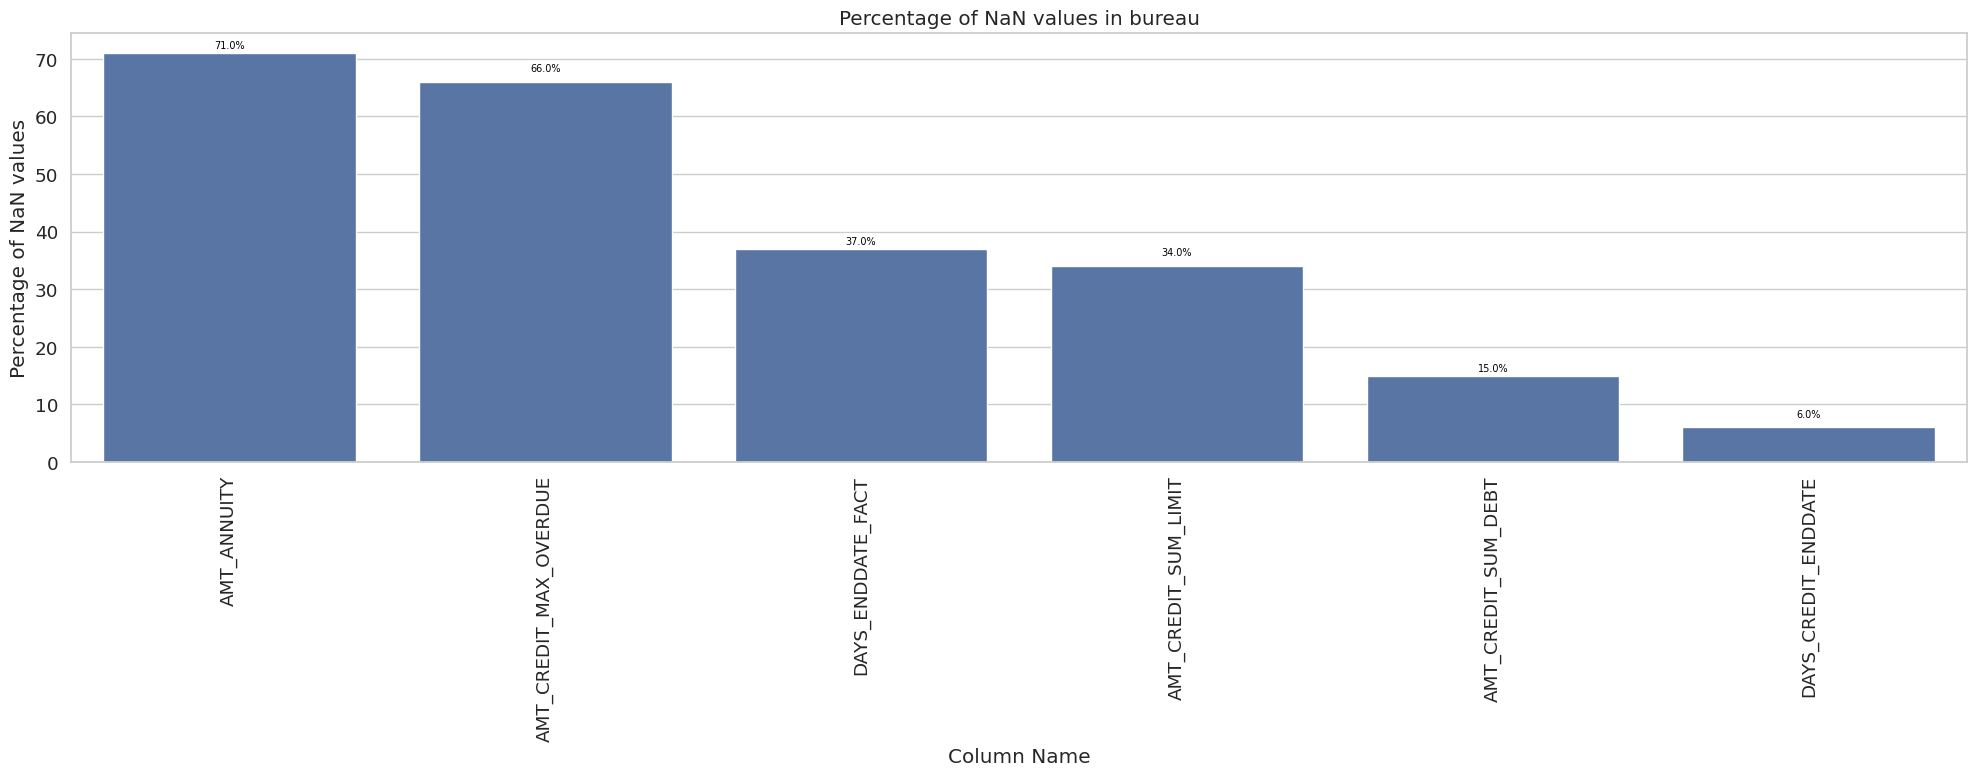

In [ ]:
plot_nan_percent(bureau, 'bureau', grid = False)

Observations et Conclusions :

Parmi les 17 caractéristiques, 7 contiennent des valeurs manquantes (NaN).

La plus grande proportion de valeurs manquantes se trouve dans la colonne AMT_ANNUITY, avec plus de 70 % de valeurs absentes.

In [ ]:
print("-"*100)
print("Merging TARGET with bureau Table")
bureau_merged = application_train.iloc[:,:2].merge(bureau, on = 'SK_ID_CURR', how = 'left')
print("-"*100)

----------------------------------------------------------------------------------------------------
Merging TARGET with bureau Table
----------------------------------------------------------------------------------------------------


##### Basic Stats Bureau

In [ ]:
analyzer_bureau = DataAnalyzer(bureau, metadata_df=HomeCredit_columns_description)
numerical_bureau, categorical_bureau , booleans_bureau= analyzer_bureau.data_col_type()
summary_table_bureau = analyzer_bureau.global_description_table(df=bureau[numerical_bureau])

In [ ]:
print('-'*50,'quelques statistiques de Bureau','-'*50)
display(analyzer_bureau.Global_info())
print('-'*50,'quelques stats sur les colonnes numériques', '-'*50)
display(summary_table_bureau.head())

-------------------------------------------------- quelques statistiques de Bureau --------------------------------------------------


[{'nombre de lignes': 1716428,
  'nombre de colonnes': 17,
  'nombre de doublons': 0,
  'nombre de colonnes constantes ': 0,
  'colonnes constantes': [],
  'Pourcentage de valeurs manquantes %': np.float64(13.5),
  'dtypes': {'nombre de variables catégorielles': 3,
   'nombre de variables numeriques': 14,
   'nombre de variables Booléennes': 0}}]

-------------------------------------------------- quelques stats sur les colonnes numériques --------------------------------------------------


colonne  nb_valeurs  valeurs_manquantes en %  \
13             AMT_ANNUITY      489637                    71.47   
6   AMT_CREDIT_MAX_OVERDUE      591940                    65.51   
5        DAYS_ENDDATE_FACT     1082775                    36.92   
10    AMT_CREDIT_SUM_LIMIT     1124648                    34.48   
9      AMT_CREDIT_SUM_DEBT     1458759                    15.01   

          moyenne           max          min  \
13   15712.757700  1.184534e+08        0.000   
6     3825.417661  1.159872e+08        0.000   
5    -1017.437148  0.000000e+00   -42023.000   
10    6229.514980  4.705600e+06  -586406.115   
9   137085.119952  1.701000e+08 -4705600.320   

                                      Col_Description  
13                                       Loan annuity  
6   Maximal amount overdue on the Credit Bureau cr...  
5   Days since CB credit ended at the time of appl...  
10  Current credit limit of credit card reported i...  
9                Current debt on Credit Bureau credit

In [ ]:
analyzer_bureau.global_description_table(df=bureau[categorical_bureau])

colonne  nb_valeurs  valeurs_manquantes en %  \
0    CREDIT_ACTIVE     1716428                      0.0   
1  CREDIT_CURRENCY     1716428                      0.0   
2      CREDIT_TYPE     1716428                      0.0   

   nb_catégories_distinctes  \
0                         4   
1                         4   
2                        15   

                                 top_catégories en %  \
0  Closed (62.88), Active (36.74), Sold (0.38), B...   
1  currency 1 (99.92), currency 2 (0.07), currenc...   
2  Consumer credit (72.92), Credit card (23.43), ...   

                                     Col_Description  
0  Status of the Credit Bureau (CB) reported credits  
1       Recoded currency of the Credit Bureau credit  
2       Type of Credit Bureau credit (Car, cash,...)

##### PhiK Matrix

----------------------------------------------------------------------------------------------------


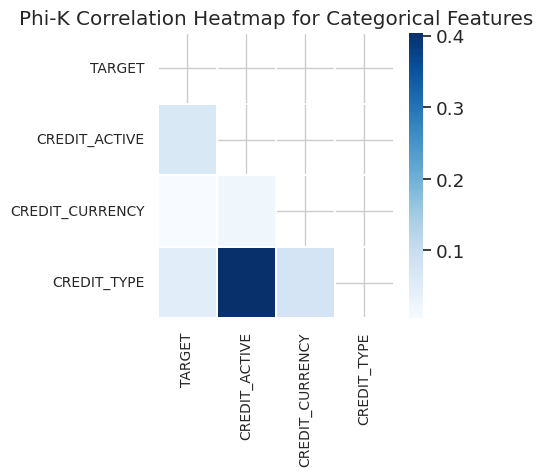

----------------------------------------------------------------------------------------------------
Categories with highest values of Phi-K Correlation value with Target Variable are:


Column Name  Phik-Correlation
0    CREDIT_ACTIVE          0.064481
2      CREDIT_TYPE          0.049954
1  CREDIT_CURRENCY          0.004993

----------------------------------------------------------------------------------------------------


In [ ]:
cols_for_phik = ['TARGET'] + categorical_bureau
plot_phik_matrix(bureau_merged, cols_for_phik,  figsize = (5,5))

le heatmap ci-dessus montre les valeurs de corrélation Phi-K entre les variables catégorielles.

D'après le coefficient de corrélation Phi-K, on observe que la variable CREDIT_TYPE présente une certaine association avec la variable CREDIT_ACTIVE.
On remarque également que les variables catégorielles n'ont pas vraiment de forte association avec la variable TARGET, en particulier la variable CREDIT_CURRENCY.

##### La matrice de corrélation

----------------------------------------------------------------------------------------------------


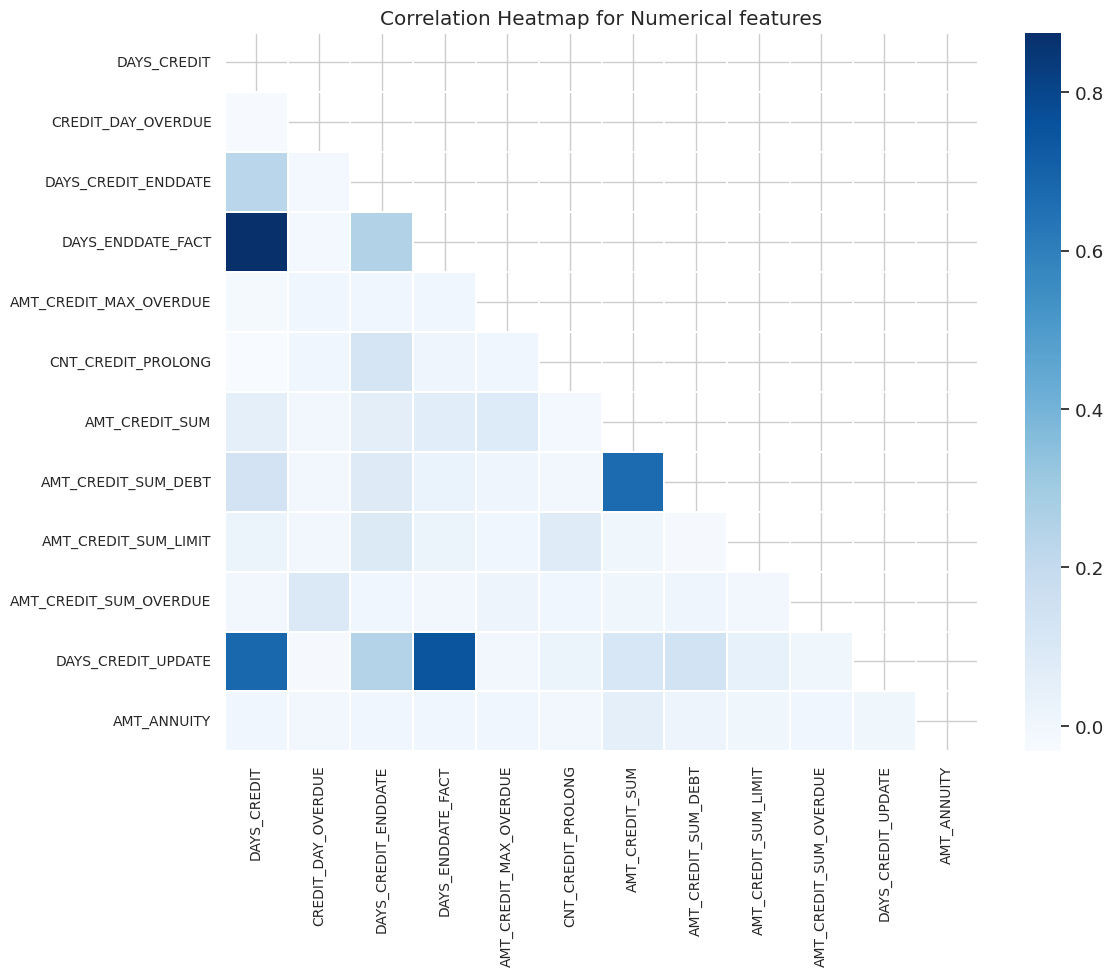

----------------------------------------------------------------------------------------------------


In [ ]:
corr_mat = correlation_matrix(bureau_merged, ['SK_ID_CURR','SK_ID_BUREAU'] + cols_for_phik , cmap = 'Blues', figsize = (12,10))
corr_mat.plot_correlation_matrix()

In [ ]:
top_corr_target_df = corr_mat.target_top_corr()
print("-" * 100)
print("Columns with highest values of Phik-correlation with Target Variable are:")
display(top_corr_target_df)
print("-"*100)

interval columns not set, guessing: ['TARGET', 'DAYS_CREDIT']
interval columns not set, guessing: ['TARGET', 'CREDIT_DAY_OVERDUE']
interval columns not set, guessing: ['TARGET', 'DAYS_CREDIT_ENDDATE']
interval columns not set, guessing: ['TARGET', 'DAYS_ENDDATE_FACT']
interval columns not set, guessing: ['TARGET', 'AMT_CREDIT_MAX_OVERDUE']
interval columns not set, guessing: ['TARGET', 'CNT_CREDIT_PROLONG']
interval columns not set, guessing: ['TARGET', 'AMT_CREDIT_SUM']
interval columns not set, guessing: ['TARGET', 'AMT_CREDIT_SUM_DEBT']
interval columns not set, guessing: ['TARGET', 'AMT_CREDIT_SUM_LIMIT']
interval columns not set, guessing: ['TARGET', 'AMT_CREDIT_SUM_OVERDUE']
interval columns not set, guessing: ['TARGET', 'DAYS_CREDIT_UPDATE']
interval columns not set, guessing: ['TARGET', 'AMT_ANNUITY']
----------------------------------------------------------------------------------------------------
Columns with highest values of Phik-correlation with Target Variable are:


Column Name  Phik-Correlation
0              DAYS_CREDIT          0.088648
2      DAYS_CREDIT_ENDDATE          0.018997
9   AMT_CREDIT_SUM_OVERDUE          0.005654
8     AMT_CREDIT_SUM_LIMIT          0.005107
4   AMT_CREDIT_MAX_OVERDUE          0.004280
5       CNT_CREDIT_PROLONG          0.003862
1       CREDIT_DAY_OVERDUE          0.002528
10      DAYS_CREDIT_UPDATE          0.002158
7      AMT_CREDIT_SUM_DEBT          0.001695
6           AMT_CREDIT_SUM          0.000670

----------------------------------------------------------------------------------------------------


Observations et Conclusions :
Le heatmap ci-dessus montre la corrélation entre chaque caractéristique de la table bureau et les autres caractéristiques.
On peut observer que la majorité de la carte présente des couleurs claires, ce qui indique une faible ou absence de corrélation.
Cependant, certaines zones plus foncées représentent une corrélation élevée.

Les corrélations élevées sont particulièrement observées entre les caractéristiques suivantes :
- DAYS_CREDIT et DAYS_CREDIT_UPDATE
- DAYS_ENDDATE_FACT et DAYS_CREDIT_UPDATE
- AMT_CREDIT_SUM et AMT_CREDIT_SUM_DEBT
- DAYS_ENDDATE_FACT et DAYS_CREDIT

On remarque également que les caractéristiques ne présentent pas de forte corrélation avec la variable Target, à l’exception de la variable DAYS_CREDIT. Cela implique qu’il n’existe pas de relation linéaire directe entre la variable Target et les autres caractéristiques.

##### Visualisation des variables catégorielles

##### Distribution de CREDIT_ACTIVE

----------------------------------------------------------------------------------------------------
The unique categories of 'CREDIT_ACTIVE' are:
['Closed' 'Active' nan 'Sold' 'Bad debt']
----------------------------------------------------------------------------------------------------
Counts of each category are:
CREDIT_ACTIVE
Closed      917733
Active      541919
Sold          5653
Bad debt        20
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
Total Number of unique categories of CREDIT_ACTIVE = 5


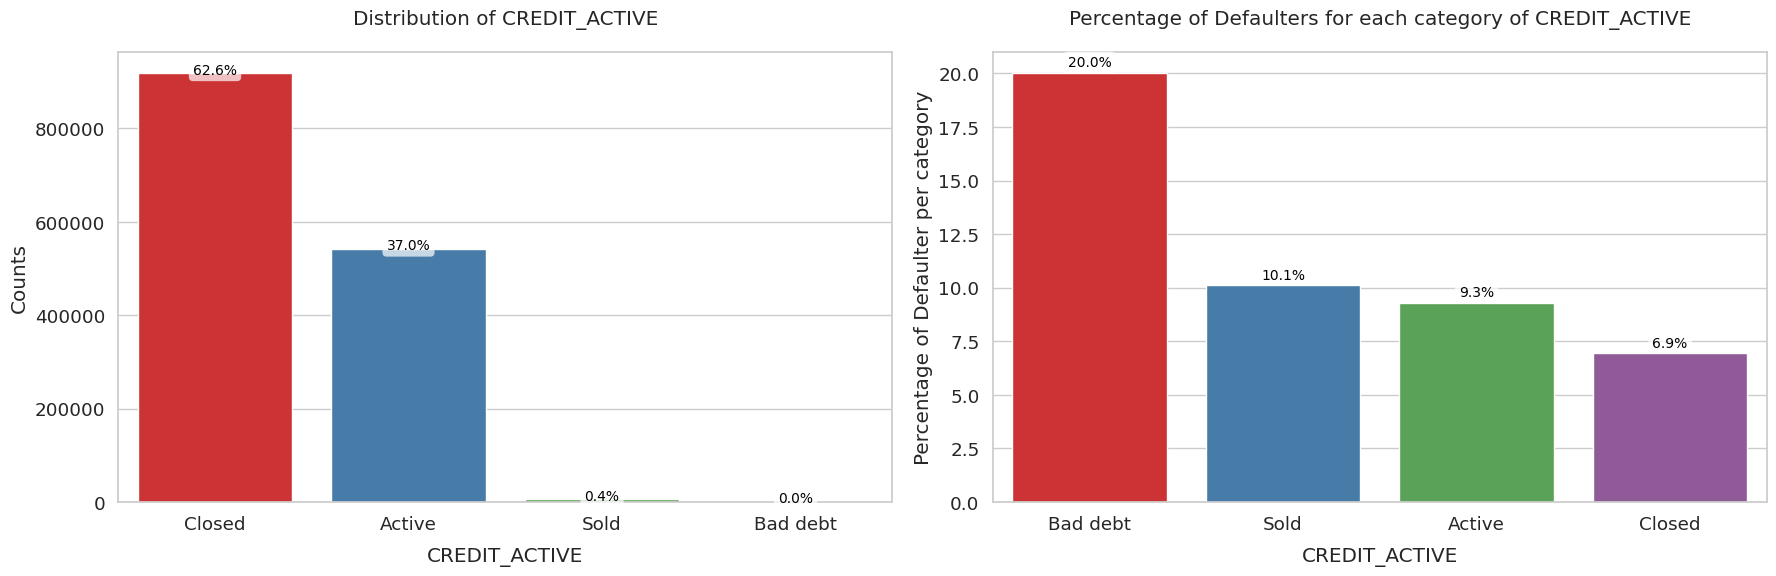

In [ ]:
print_unique_categories(bureau_merged, 'CREDIT_ACTIVE', show_counts = True)

# plotting the Bar Plot for the Column
plot_categorical_variables_bar(bureau_merged, column_name = 'CREDIT_ACTIVE', horizontal_adjust = 0.3, fontsize_percent = 'x-small')

Observations et Conclusions :

À partir du graphique ci-dessus, nous pouvons tirer les enseignements suivants :

Dans le premier sous-graphe, on observe que la majorité des anciens prêts contractés auprès d'autres institutions financières sont des prêts clôturés (62,63 %), suivis des prêts actifs (36,98 %). Les prêts vendus et les prêts douteux (Bad-Debt) sont très peu nombreux.

Si l'on examine le taux de défaut par catégorie, on constate qu’environ 20 % des personnes ayant un prêt douteux (Bad-Debt) sont en défaut de paiement — c’est le taux de défaut le plus élevé.

Cela est suivi par les prêts vendus puis les prêts actifs. Le taux de défaut le plus faible concerne les prêts clôturés, ce qui reflète une bonne historique de crédit pour le client.
Ainsi, le schéma observé ici est tout à fait logique et attendu.

##### Visualisation des variables numérique

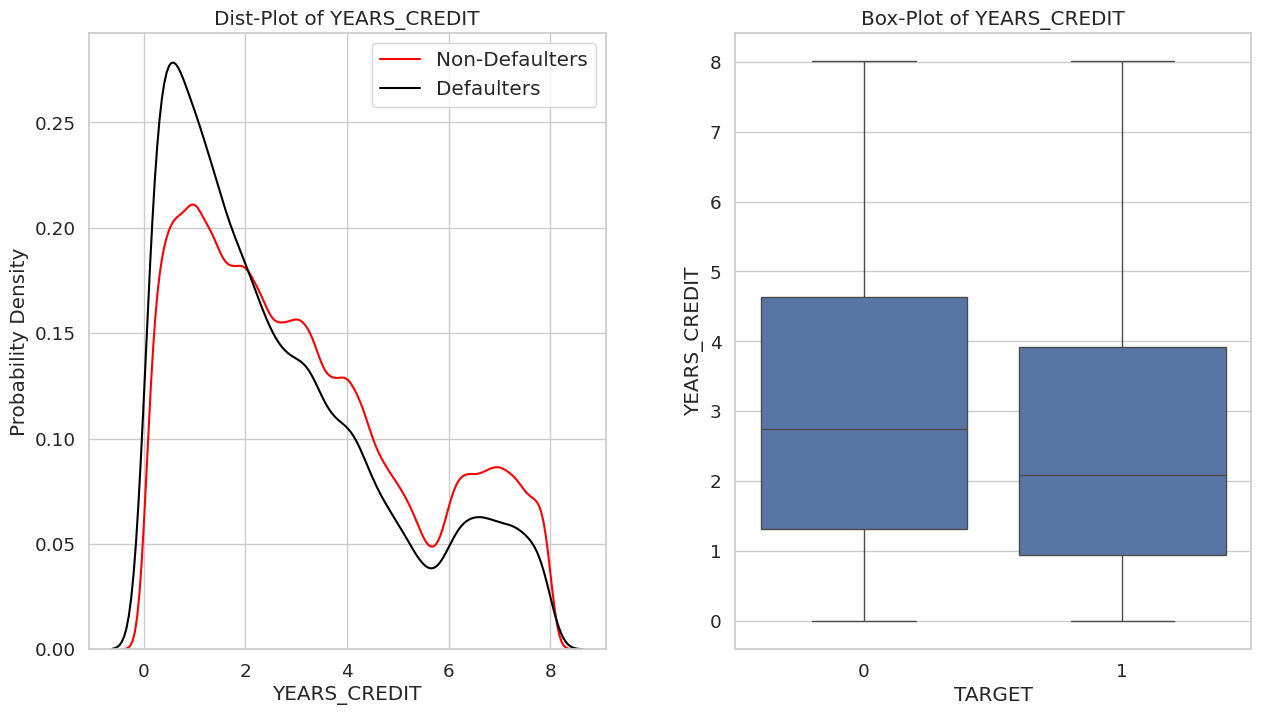

In [ ]:
bureau_merged['YEARS_CREDIT'] = bureau_merged['DAYS_CREDIT'] / -365
plot_continuous_variables(bureau_merged, 'YEARS_CREDIT', plots = ['distplot', 'box'], figsize = (15,8))
_ = bureau_merged.pop('YEARS_CREDIT')

Observations et Conclusions :

À partir des graphiques ci-dessus, nous pouvons observer les points suivants :

D'après la fonction de densité de probabilité (PDF), on constate que les défaillants ont tendance à présenter des pics plus élevés que les non-défaillants lorsque le nombre d'années est faible. Cela implique que les demandeurs ayant récemment sollicité des prêts auprès du Bureau de Crédit montrent une tendance plus marquée à défaut de paiement que ceux ayant fait une demande il y a longtemps. De plus, la PDF des défaillants est légèrement décalée vers la gauche par rapport à celle des non-défaillants.
En regardant également le box-plot, on observe que les défaillants avaient généralement moins d'années de crédit (YEARS_CREDIT) que les non-défaillants.

##### DAYS_CREDIT_ENDDATE

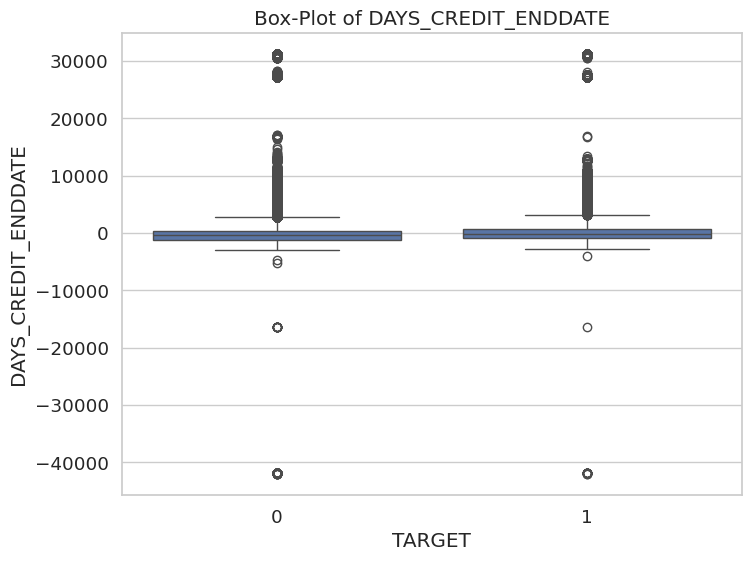

In [ ]:
plot_continuous_variables(bureau_merged, 'DAYS_CREDIT_ENDDATE', plots = ['box'], figsize = (8,6))


Observations et Conclusions :

En observant le box-plot, on constate qu'il semble y avoir une valeur erronée pour DAYS_CREDIT_ENDDATE, où la valeur du 0e percentile remonte à 42060 jours, soit environ 115 ans. Cela n'a pas beaucoup de sens, car cela implique que le prêt précédent du client remonte à 115 ans. Cela pourrait être un prêt hérité, mais nous ne pouvons pas en être certains. Nous essayerons de supprimer ces valeurs lors de la phase de prétraitement des données.

##### DAYS_CREDIT_UPDATE

- Cette variable indique le nombre de jours depuis la dernière mise à jour de crédit dans les bases du bureau de crédit.
- Les valeurs sont négatives, car elles comptent les jours par rapport à la date de demande de prêt (jour 0).
   - Ex. : -30 signifie "il y a 30 jours", -1000 signifie "il y a 1000 jours".

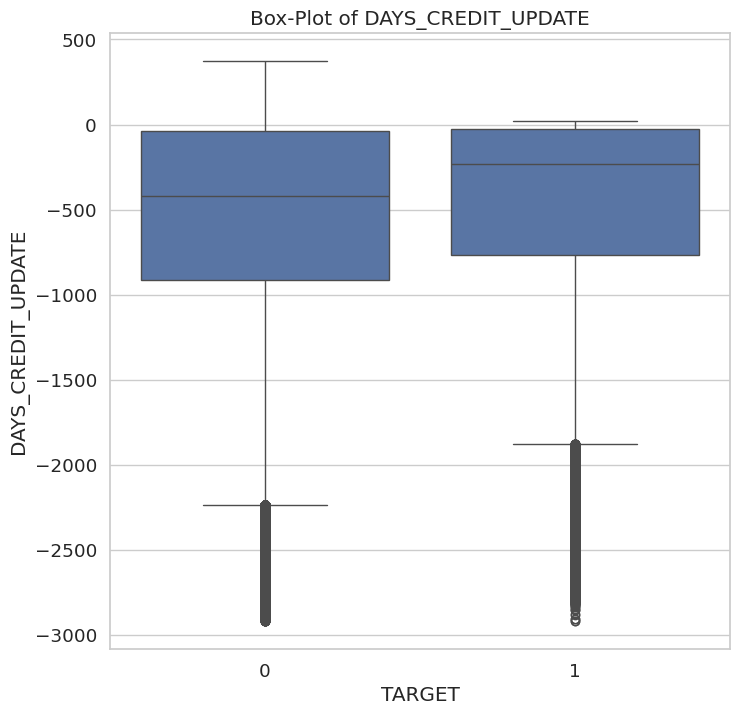

In [ ]:
plot_continuous_variables(bureau_merged, 'DAYS_CREDIT_UPDATE', plots = ['box'], figsize = (8,8), scale_limits = [-40000, 400])

Les emprunteurs défaillants ont des valeurs de DAYS_CREDIT_UPDATE plus proches de 0 que les non-défaillants, ce qui signifie que leur information de crédit a été mise à jour plus récemment.

##### Hypothèses explicatives:

1- Activité récente accrue dans le crédit :

- Les personnes en difficulté financière peuvent contacter leurs créanciers plus souvent, négocier, demander des reports, ou être suivies de près par les institutions de crédit.
→ Cela entraîne des mises à jour plus fréquentes dans les bases de données du bureau de crédit.

2- Surveillance accrue par les prêteurs :
- Lorsqu'un client présente des signes de risque, les institutions financières peuvent effectuer des contrôles plus fréquents ou déclencher des mises à jour automatiques.
- Cela génère une activité récente dans le dossier crédit, même si aucun nouveau crédit n’est pris.

3- Tentatives de refinancement ou de nouveaux crédits :
- Les emprunteurs en difficulté peuvent faire plus de demandes de crédit, ce qui génère des mises à jour dans le bureau de crédit.

4- Signal d’un comportement à risque :
- Des mises à jour très récentes pourraient refléter un comportement instable, comme de nombreux contacts avec différents créanciers, qui est souvent un prédicteur de défaut.


# Comparaison avec les non-défaillants

Les emprunteurs non défaillants ont des mises à jour plus anciennes :
- Ils sont probablement plus stables financièrement.
- Moins de contacts avec les institutions → moins de mises à jour nécessaires.



#### Bureau_balance.csv

In [ ]:
analyzer_bureau_balance = DataAnalyzer(bureau_balance, metadata_df=HomeCredit_columns_description)
numerical_bureau_balance, categorical_bureau_balance , booleans_bureau_balance= analyzer_bureau_balance.data_col_type()
summary_table_bureau_balance = analyzer_bureau_balance.global_description_table(df=bureau_balance[numerical_bureau_balance])

In [ ]:
print('-'*50,'quelques statistiques de Bureau_balance','-'*50)
display(analyzer_bureau_balance.Global_info())
print('-'*50,'quelques stats sur les colonnes numériques', '-'*50)
display(summary_table_bureau_balance.head())
print('-'*50,'quelques stats sur les colonnes catégories', '-'*50)
display(analyzer_bureau_balance.global_description_table(df=bureau_balance[categorical_bureau_balance]).head())

-------------------------------------------------- quelques statistiques de Bureau_balance --------------------------------------------------


[{'nombre de lignes': 27299925,
  'nombre de colonnes': 3,
  'nombre de doublons': 0,
  'nombre de colonnes constantes ': 0,
  'colonnes constantes': [],
  'Pourcentage de valeurs manquantes %': np.float64(0.0),
  'dtypes': {'nombre de variables catégorielles': 1,
   'nombre de variables numeriques': 2,
   'nombre de variables Booléennes': 0}}]

-------------------------------------------------- quelques stats sur les colonnes numériques --------------------------------------------------


colonne  nb_valeurs  valeurs_manquantes en %       moyenne      max  \
0    SK_ID_BUREAU    27299925                      0.0  6.036297e+06  6842888   
1  MONTHS_BALANCE    27299925                      0.0 -3.074169e+01        0   

       min                                    Col_Description  
0  5001709                           Description non trouvée.  
1      -96  Month of balance relative to application date ...

-------------------------------------------------- quelques stats sur les colonnes catégories --------------------------------------------------


colonne  nb_valeurs  valeurs_manquantes en %  nb_catégories_distinctes  \
0  STATUS    27299925                      0.0                         8   

                                 top_catégories en %  \
0  C (49.99), 0 (27.47), X (21.28), 1 (0.89), 5 (...   

                                     Col_Description  
0  Status of Credit Bureau loan during the month ...

Bilan:
Le fichier bureau_balance.csv contient environ 27,29 millions de lignes et 3 colonnes.
Ce tableau présente l'état mensuel de chaque prêt antérieur pour un demandeur particulier, tel que rapporté par le Département des Agences de Crédit.
Il existe 8 valeurs uniques pour le STATUT, chacune ayant une signification spécifique :

| Code | Signification                                                                 |
|------|-------------------------------------------------------------------------------|
| C    | Prêt clos (remboursé ou fermé)                                           |
| X    | Statut inconnu                                                           |
| 0    | Aucun retard de paiement (DPD = 0)                                        |
| 1    | Retard de 1 à 30 jours (DPD : Days Past Due)                             |
| 2    | Retard de 31 à 60 jours                                                |
| 3    | Retard de 61 à 90 jours                                                       |
| 4    | Retard de 91 à 120 jours                                                      |
| 5    | Retard de plus de 120 jours, ou prêt vendu ou radié                |

Le solde le plus ancien disponible correspond à un statut datant de 96 mois, offrant ainsi un historique de 8 ans pour les prêts concernés.



#### Previous_application.csv

In [ ]:
print(f'Le nombre d\'identifiants uniques SK_ID_PREV dans previous_application.csv est: {len(previous_application.SK_ID_PREV.unique())}')
print(f'Le nombre d\'identifiants uniques SK_ID_CURR in bureau.csv est: {len(previous_application.SK_ID_CURR.unique())}')
print(f'Le nombre d\'identifiants SK_ID_CURR communs entre application_train.csv et previous_application.csv est: {len(set(application_train.SK_ID_CURR.unique()).intersection(set(previous_application.SK_ID_CURR.unique())))}')
print(f'Le nombre d\'identifiants SK_ID_CURR communs entre application_test.csv et previous_application.csv est: {len(set(application_test.SK_ID_CURR.unique()).intersection(set(previous_application.SK_ID_CURR.unique())))}')
print('-'*100)
display(previous_application.head(5))

Le nombre d'identifiants uniques SK_ID_PREV dans previous_application.csv est: 1670214
Le nombre d'identifiants uniques SK_ID_CURR in bureau.csv est: 338857
Le nombre d'identifiants SK_ID_CURR communs entre application_train.csv et previous_application.csv est: 291057
Le nombre d'identifiants SK_ID_CURR communs entre application_test.csv et previous_application.csv est: 47800
----------------------------------------------------------------------------------------------------


SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
0     2030495      271877     Consumer loans     1730.430          17145.0   
1     2802425      108129         Cash loans    25188.615         607500.0   
2     2523466      122040         Cash loans    15060.735         112500.0   
3     2819243      176158         Cash loans    47041.335         450000.0   
4     1784265      202054         Cash loans    31924.395         337500.0   

   AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  \
0     17145.0               0.0          17145.0                   SATURDAY   
1    679671.0               NaN         607500.0                   THURSDAY   
2    136444.5               NaN         112500.0                    TUESDAY   
3    470790.0               NaN         450000.0                     MONDAY   
4    404055.0               NaN         337500.0                   THURSDAY   

   HOUR_APPR_PROCESS_START FLAG_LAST_APPL_PER_CONTRACT  \
0                       15                           Y   
1                       11                           Y   
2                       11                           Y   
3                        7                           Y   
4                        9                           Y   

   NFLAG_LAST_APPL_IN_DAY  RATE_DOWN_PAYMENT  RATE_INTEREST_PRIMARY  \
0                       1                0.0               0.182832   
1                       1                NaN                    NaN   
2                       1                NaN                    NaN   
3                       1                NaN                    NaN   
4                       1                NaN                    NaN   

   RATE_INTEREST_PRIVILEGED NAME_CASH_LOAN_PURPOSE NAME_CONTRACT_STATUS  \
0                  0.867336                    XAP             Approved   
1                       NaN                    XNA             Approved   
2                       NaN                    XNA             Approved   
3                       NaN                    XNA             Approved   
4                       NaN                Repairs              Refused   

   DAYS_DECISION      NAME_PAYMENT_TYPE CODE_REJECT_REASON  NAME_TYPE_SUITE  \
0            -73  Cash through the bank                XAP              NaN   
1           -164                    XNA                XAP    Unaccompanied   
2           -301  Cash through the bank                XAP  Spouse, partner   
3           -512  Cash through the bank                XAP              NaN   
4           -781  Cash through the bank                 HC              NaN   

  NAME_CLIENT_TYPE NAME_GOODS_CATEGORY NAME_PORTFOLIO NAME_PRODUCT_TYPE  \
0         Repeater              Mobile            POS               XNA   
1         Repeater                 XNA           Cash            x-sell   
2         Repeater                 XNA           Cash            x-sell   
3         Repeater                 XNA           Cash            x-sell   
4         Repeater                 XNA           Cash           walk-in   

              CHANNEL_TYPE  SELLERPLACE_AREA NAME_SELLER_INDUSTRY  \
0             Country-wide                35         Connectivity   
1           Contact center                -1                  XNA   
2  Credit and cash offices                -1                  XNA   
3  Credit and cash offices                -1                  XNA   
4  Credit and cash offices                -1                  XNA   

   CNT_PAYMENT NAME_YIELD_GROUP       PRODUCT_COMBINATION  DAYS_FIRST_DRAWING  \
0         12.0           middle  POS mobile with interest            365243.0   
1         36.0       low_action          Cash X-Sell: low            365243.0   
2         12.0             high         Cash X-Sell: high            365243.0   
3         12.0           middle       Cash X-Sell: middle            365243.0   
4         24.0             high         Cash Street: high                 NaN   

   D

In [ ]:
analyzer_previous_application = DataAnalyzer(previous_application, metadata_df=HomeCredit_columns_description)
numerical_previous_application, categorical_previous_application , booleans_previous_application= analyzer_previous_application.data_col_type()
summary_table_previous_application = analyzer_previous_application.global_description_table(df=previous_application[numerical_previous_application])

In [ ]:
print('-'*50,'quelques statistiques de previous_application','-'*50)
display(analyzer_previous_application.Global_info())
print('-'*50,'quelques stats sur les colonnes numériques', '-'*50)
display(summary_table_previous_application.head())

-------------------------------------------------- quelques statistiques de previous_application --------------------------------------------------


[{'nombre de lignes': 1670214,
  'nombre de colonnes': 37,
  'nombre de doublons': 0,
  'nombre de colonnes constantes ': 0,
  'colonnes constantes': [],
  'Pourcentage de valeurs manquantes %': np.float64(17.98),
  'dtypes': {'nombre de variables catégorielles': 16,
   'nombre de variables numeriques': 19,
   'nombre de variables Booléennes': 2}}]

-------------------------------------------------- quelques stats sur les colonnes numériques --------------------------------------------------


colonne  nb_valeurs  valeurs_manquantes en %  \
9      RATE_INTEREST_PRIMARY        5951                    99.64   
10  RATE_INTEREST_PRIVILEGED        5951                    99.64   
5           AMT_DOWN_PAYMENT      774370                    53.64   
8          RATE_DOWN_PAYMENT      774370                    53.64   
18          DAYS_TERMINATION      997149                    40.30   

         moyenne        max          min  \
9       0.188357        1.0     0.034781   
10      0.773503        1.0     0.373150   
5    6697.402139  3060045.0    -0.900000   
8       0.079637        1.0    -0.000015   
18  81992.343838   365243.0 -2874.000000   

                                      Col_Description  
9         Interest rate normalized on previous credit  
10        Interest rate normalized on previous credit  
5            Down payment on the previous application  
8     Down payment rate normalized on previous credit  
18  Relative to application date of current applic...

Number of columns With NaN values: 14 columns


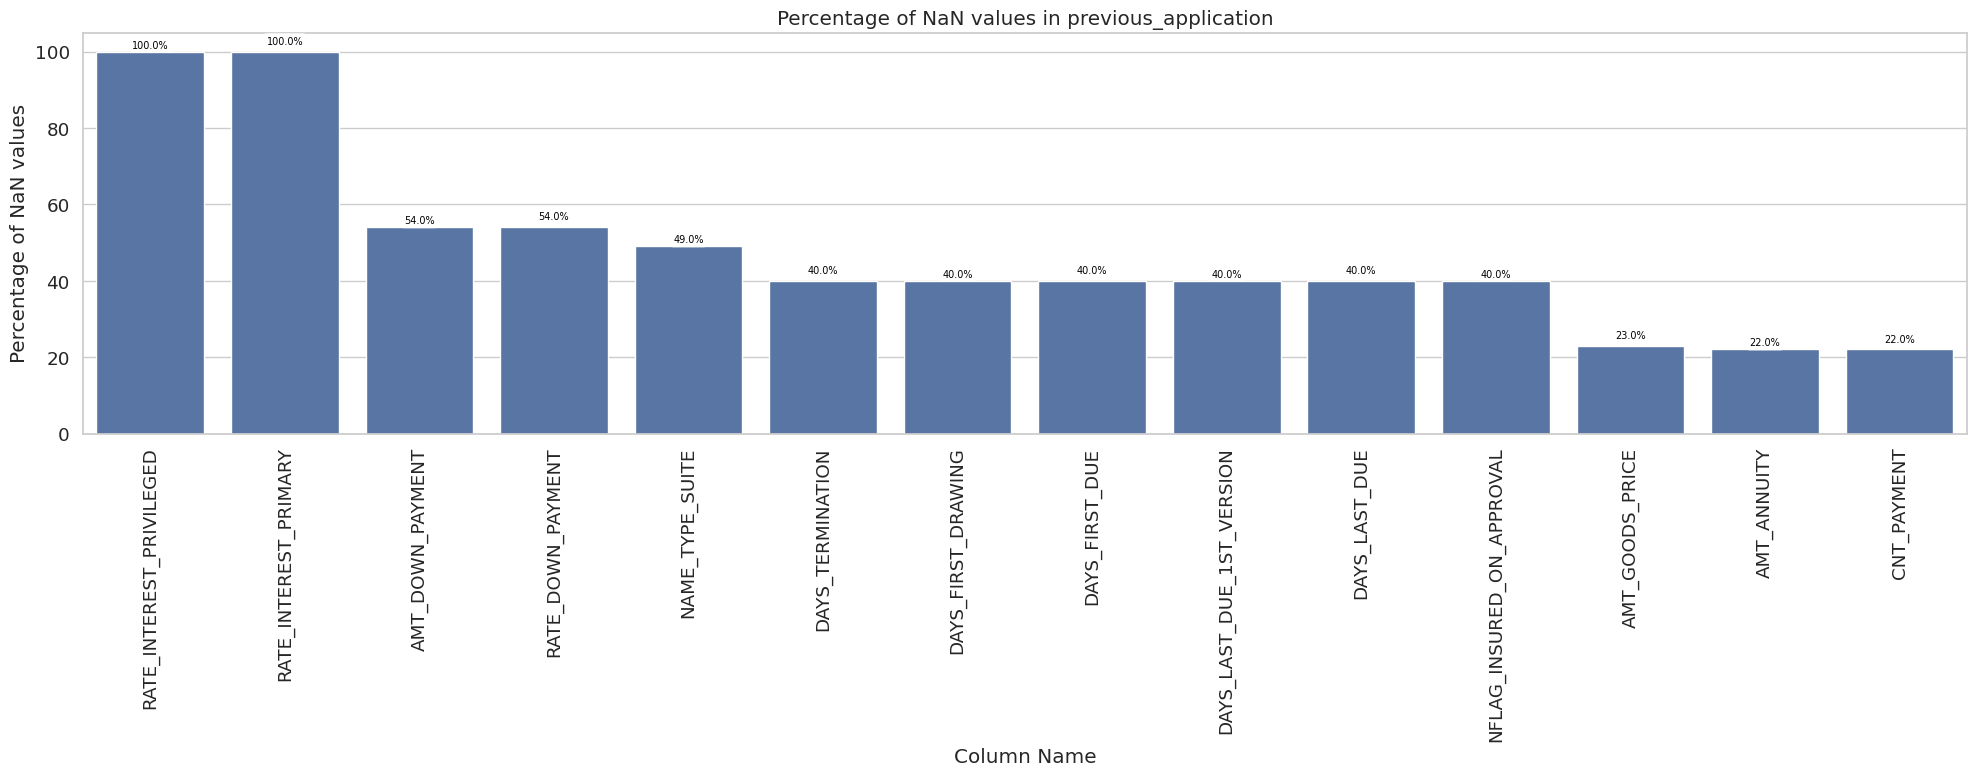

In [ ]:
plot_nan_percent(previous_application, 'previous_application',grid = False)


##### Merge Target to previous_application

In [ ]:
prev_merged = application_train.iloc[:,:2].merge(previous_application, on = 'SK_ID_CURR', how = 'left')

##### Phik matrix

----------------------------------------------------------------------------------------------------


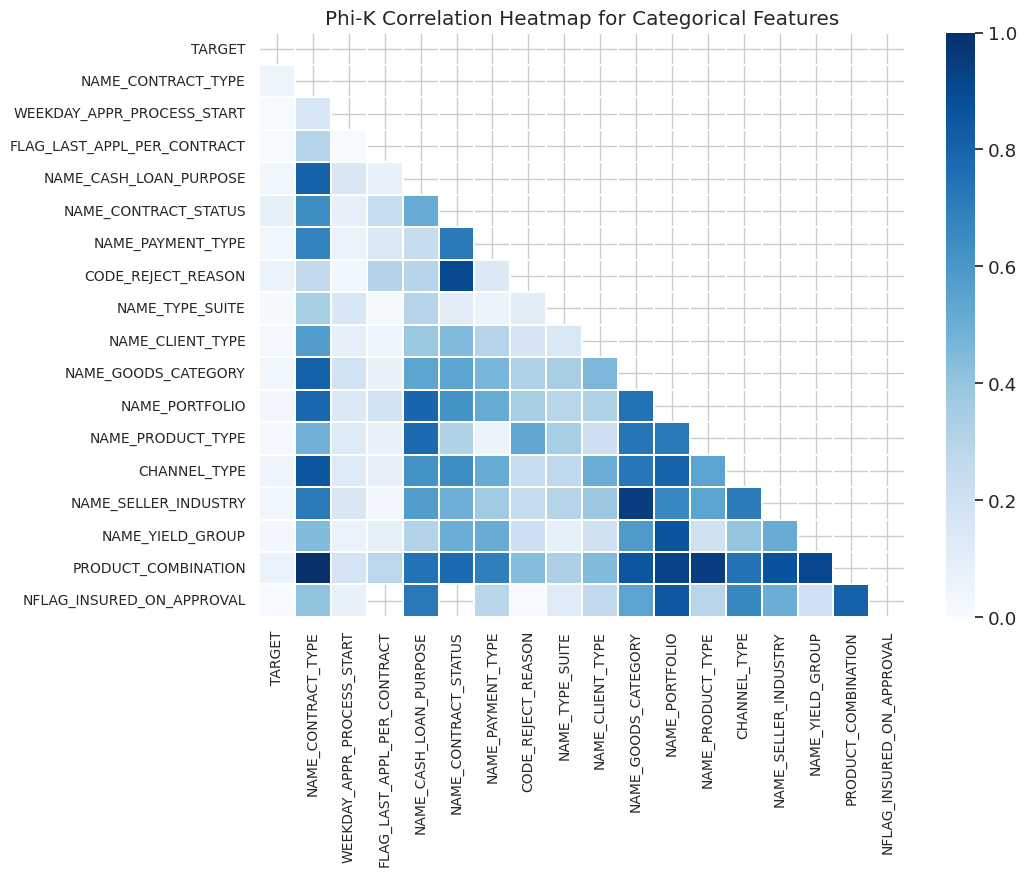

----------------------------------------------------------------------------------------------------
Categories with highest values of Phi-K Correlation value with Target Variable are:


Column Name  Phik-Correlation
4     NAME_CONTRACT_STATUS          0.088266
15     PRODUCT_COMBINATION          0.063839
6       CODE_REJECT_REASON          0.062771
0       NAME_CONTRACT_TYPE          0.050859
12            CHANNEL_TYPE          0.050302
9      NAME_GOODS_CATEGORY          0.042951
3   NAME_CASH_LOAN_PURPOSE          0.040305
5        NAME_PAYMENT_TYPE          0.039752
13    NAME_SELLER_INDUSTRY          0.038077
14        NAME_YIELD_GROUP          0.034626

----------------------------------------------------------------------------------------------------


In [ ]:
cols_for_phik = ['TARGET'] + prev_merged.dtypes[prev_merged.dtypes == 'object'].index.tolist() + ['NFLAG_INSURED_ON_APPROVAL']
plot_phik_matrix(prev_merged, cols_for_phik,  figsize = (11,9))

**Interprétation**

Le heatmap des valeurs du coefficient Phi-K pour les variables catégorielles, on observe:
- La variable PRODUCT_COMBINATION montre une association avec de nombreuses autres variables, telles que NAME_CONTRACT_TYPE,NAME_PORTFOLIO,  NAME_PRODUCT_TYPE, etc...
- La variable NAME_GOODS_CATEGORY est également fortement associée à NAME_SELLER_INDUSTRY.




##### Matrix de corrélation

----------------------------------------------------------------------------------------------------


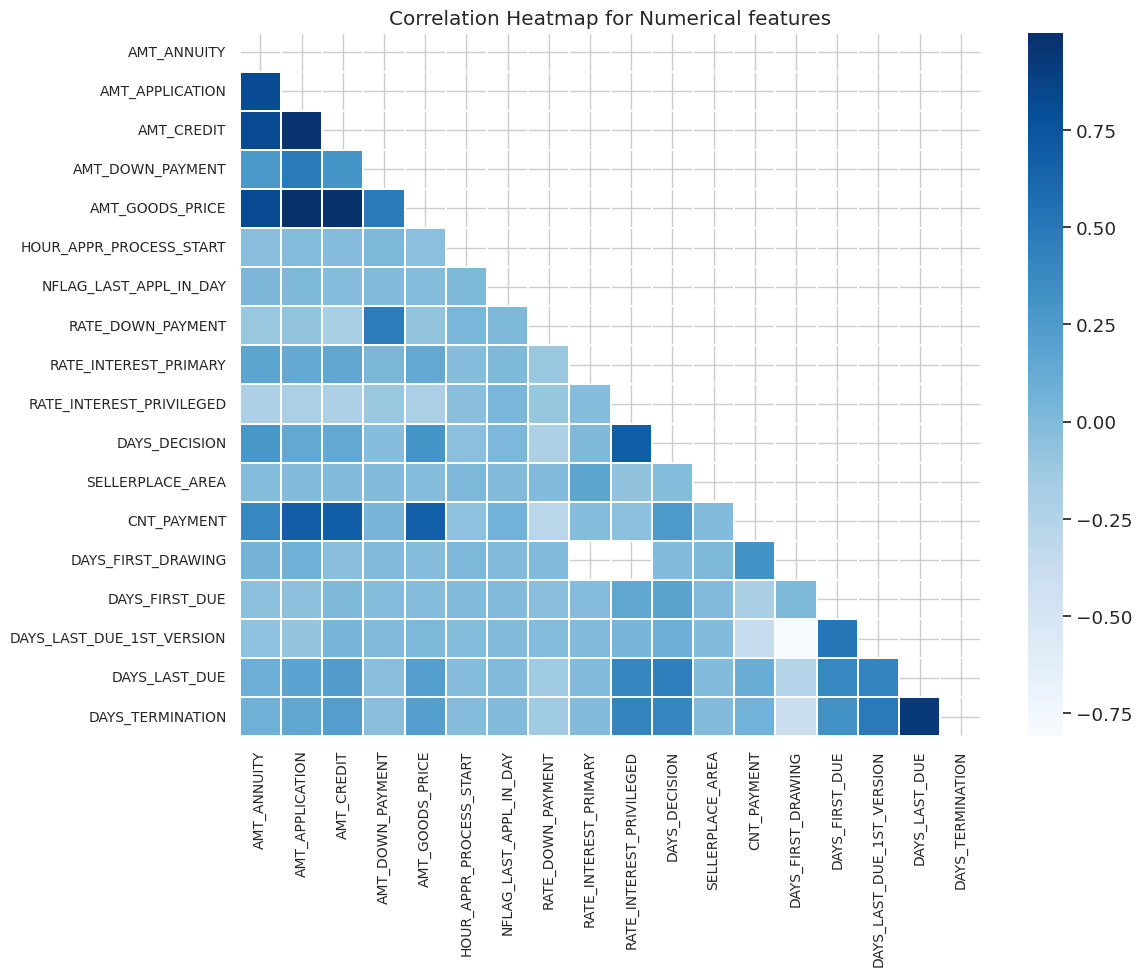

----------------------------------------------------------------------------------------------------


In [ ]:
corr_mat = correlation_matrix(prev_merged, ['SK_ID_PREV','SK_ID_CURR'] + cols_for_phik , cmap = 'Blues', figsize = (12,10))
corr_mat.plot_correlation_matrix()

In [ ]:
top_corr_target_df = corr_mat.target_top_corr()
print("-" * 100)
print("Columns with highest values of Phik-correlation with Target Variable are:")
display(top_corr_target_df)

interval columns not set, guessing: ['TARGET', 'AMT_ANNUITY']
interval columns not set, guessing: ['TARGET', 'AMT_APPLICATION']
interval columns not set, guessing: ['TARGET', 'AMT_CREDIT']
interval columns not set, guessing: ['TARGET', 'AMT_DOWN_PAYMENT']
interval columns not set, guessing: ['TARGET', 'AMT_GOODS_PRICE']
interval columns not set, guessing: ['TARGET', 'HOUR_APPR_PROCESS_START']
interval columns not set, guessing: ['TARGET', 'NFLAG_LAST_APPL_IN_DAY']
interval columns not set, guessing: ['TARGET', 'RATE_DOWN_PAYMENT']
interval columns not set, guessing: ['TARGET', 'RATE_INTEREST_PRIMARY']
interval columns not set, guessing: ['TARGET', 'RATE_INTEREST_PRIVILEGED']
interval columns not set, guessing: ['TARGET', 'DAYS_DECISION']
interval columns not set, guessing: ['TARGET', 'SELLERPLACE_AREA']
interval columns not set, guessing: ['TARGET', 'CNT_PAYMENT']
interval columns not set, guessing: ['TARGET', 'DAYS_FIRST_DRAWING']
interval columns not set, guessing: ['TARGET', 'DAYS_F

Column Name  Phik-Correlation
12                CNT_PAYMENT          0.056639
10              DAYS_DECISION          0.053695
13         DAYS_FIRST_DRAWING          0.048990
7           RATE_DOWN_PAYMENT          0.039592
5     HOUR_APPR_PROCESS_START          0.038121
9    RATE_INTEREST_PRIVILEGED          0.028204
15  DAYS_LAST_DUE_1ST_VERSION          0.027877
16              DAYS_LAST_DUE          0.027321
17           DAYS_TERMINATION          0.026480
0                 AMT_ANNUITY          0.013808

**Interprétation**

Le heatmap ci-dessus montre la corrélation  entre chaque variable de la table previous_application et le reste des variables.

A partir de cette carte, on peut observer certaines variables fortement corrélées, représentées par des couleurs plus foncées.

Une corrélation élevée est particulièrement visible entre les paires de variables suivantes:

- DAYS_TERMINATION et DAYS_LAST_DUE
- AMT_CREDIT et AMT_APPLICATION
- AMT_APPLICATION et AMT_GOODS_PRICE
- etc...

On peut également constater ces variables ne présentent pas de forte corrélation avec la variable cible (Target) ce qui implique qu'il n'existe pas de relaton linéaire directe significative entre la variable cible et les autres caractéristiques.

##### Analyse des variables catégorielles

###### Distribution de PRODUCT_COMBINATION

cette colonne donne des détails sur la combinaison de produits des demandes précédentes.

Total Number of unique categories of PRODUCT_COMBINATION = 18


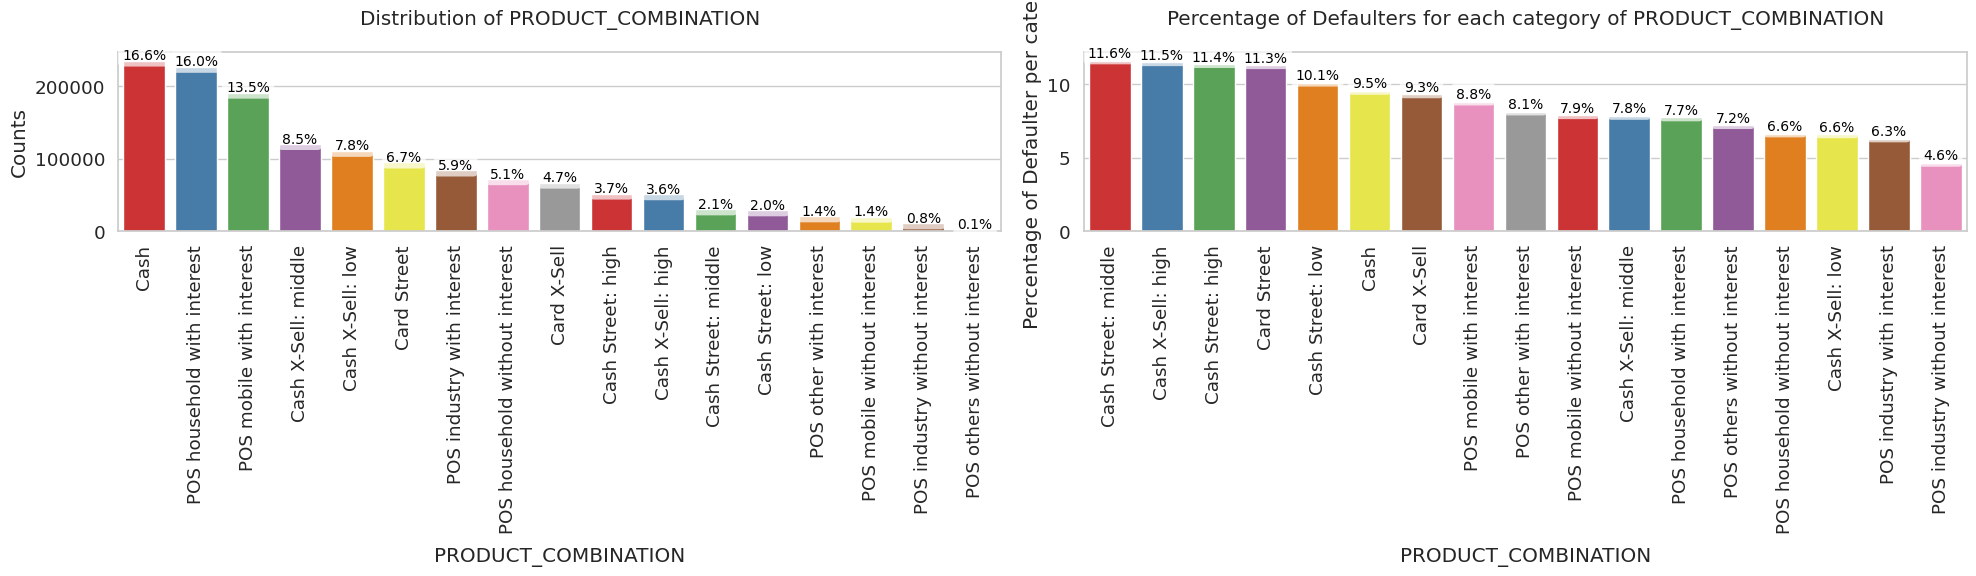

----------------------------------------------------------------------------------------------------


In [ ]:
plot_categorical_variables_bar(prev_merged, 'PRODUCT_COMBINATION', rotation = 90, figsize = (20, 6))
print('-'*100)

**Interpretation**

À partir de la distribution de la variable PRODUCT_COMBINATION, on peut dire:

- Les trois types les plus fréquents de combinaisons de produits sont Cash, POS household with interest et POS mobile with interest. À eux seuls, ils représentent environ 50 % de l’ensemble des demandes.

- En observant le taux de défaut par catégorie, on constate une tendance plus élevée au défaut parmi les catégories suivantes :
Cash Street: mobile, Cash X-sell: high, Cash Street: high et Card Street, avec un taux avoisinant 11 à 11,5 % de défauts par catégorie.

- Le taux de défaut le plus bas est observé dans la catégorie POS Industry without interest, avec environ 4,5 % de défauts.

###### Distribution de CODE_REJECT_REASON

Total Number of unique categories of CODE_REJECT_REASON = 10


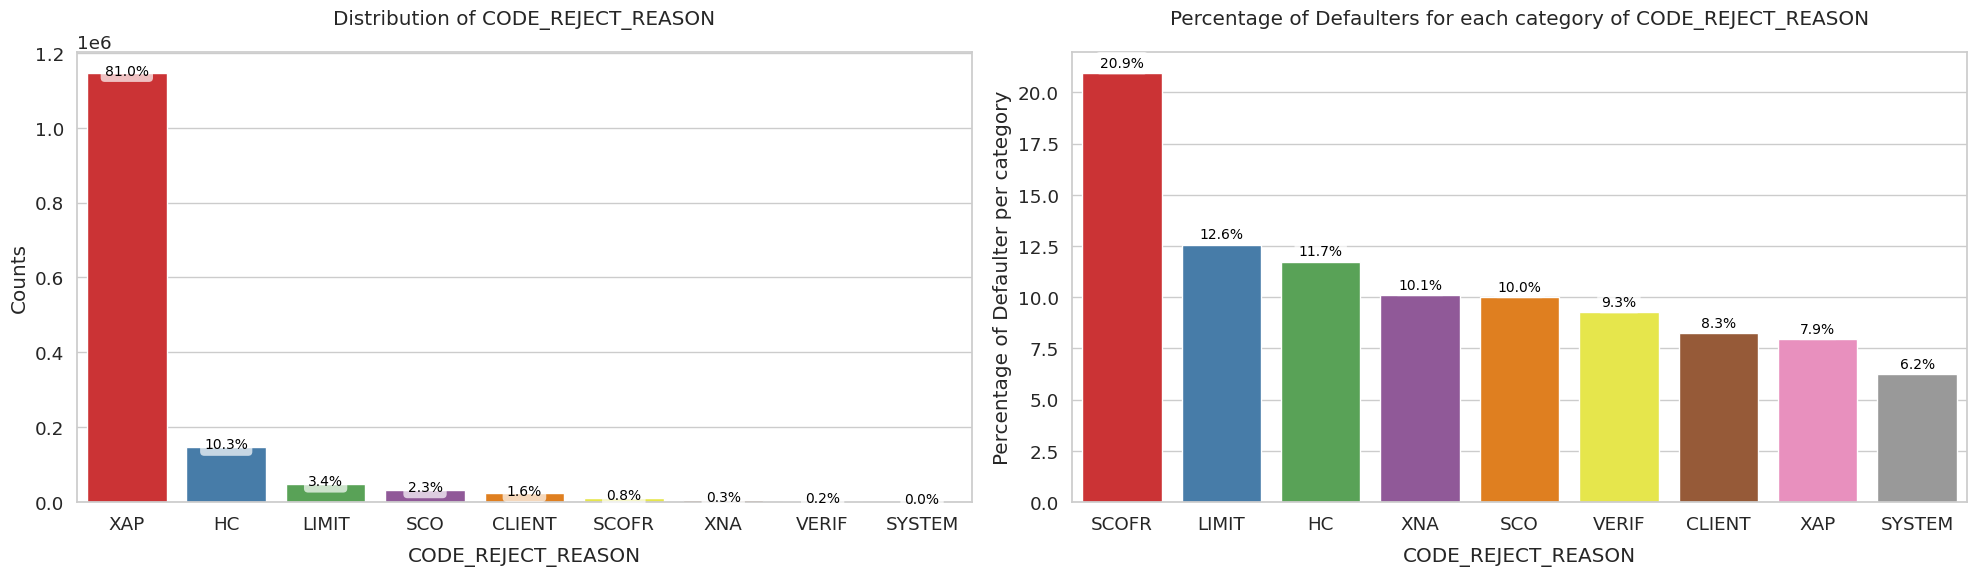

In [ ]:
plot_categorical_variables_bar(prev_merged, 'CODE_REJECT_REASON', horizontal_adjust = 0.18, figsize = (20, 6))

**Interprétation**

Le graphique ci-dessus montre la distribution de la variable catégorielle CODE_REJECT_REASON. on observe:

- Le motif de rejet le plus fréquent est XAP, qui représente environ 81 % des cas. Les autres motifs de rejet ne constituent qu’une faible proportion. Le second motif le plus fréquent est HC, avec seulement 10,33 % des occurrences.

- La répartition du pourcentage de défauts pour chaque catégorie de CODE_REJECT_REASON est assez intéressante. Les demandeurs dont la demande précédente a été rejetée avec le code SCOFR présentent le taux de défaut le plus élevé, soit environ 21 %. Ils sont suivis par les codes LIMIT et HC, qui affichent respectivement environ 12,6 % et 11,7 % de défauts.

- Le motif de rejet le plus courant, XAP, ne correspond qu’à 7,9 % des défauts, ce qui en fait le deuxième taux de défaut le plus faible, juste après le code SYSTEM.

##### Distribution des variables nimériques

###### Distribution de DAYS_DECISION

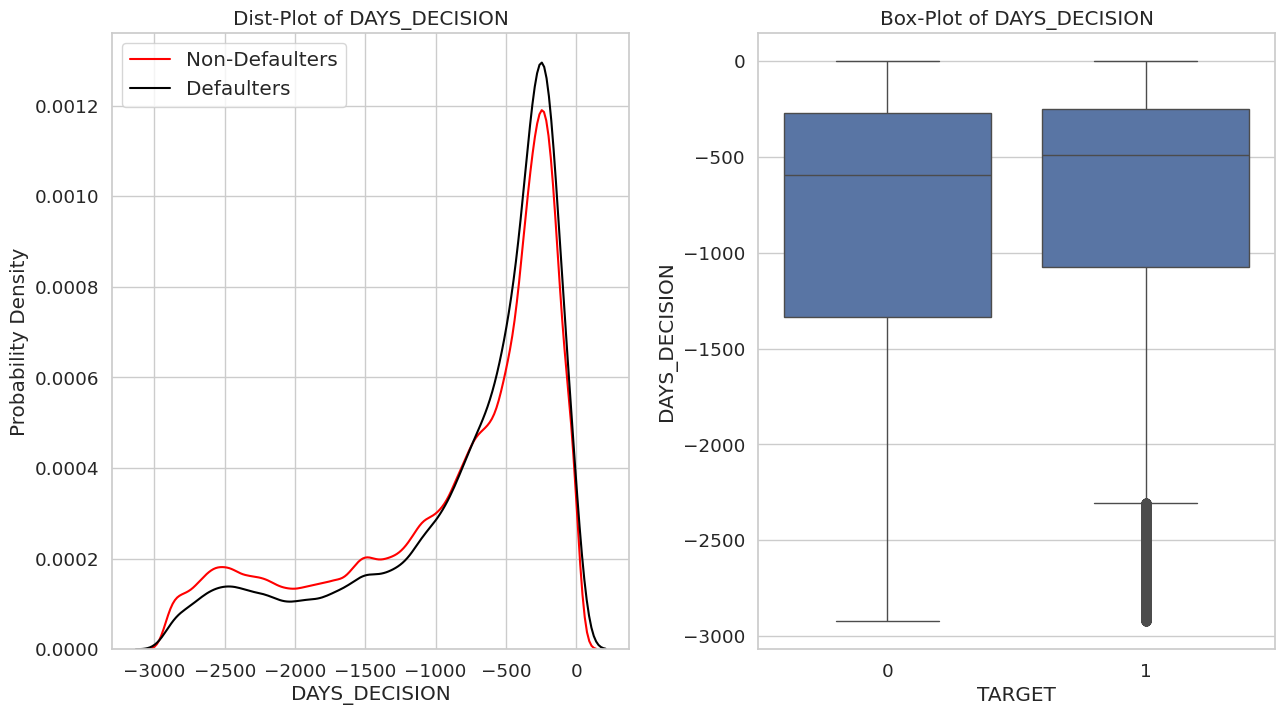

In [ ]:
plot_continuous_variables(prev_merged, 'DAYS_DECISION', plots = ['distplot', 'box'], figsize = (15,8))

**Interpretation**

- Les deux courbes sont très similaires, ce qui suggère que la variable DAYS_DECISION n’est pas fortement discriminante entre les deux groupes.

- Cependant, on observe un léger pic plus marqué pour les défaillants autour de -250 jours, ce qui pourrait être un signal faible dans un modèle de scoring.

- Une analyse statistique (ex. test de Kolmogorov-Smirnov) serait utile pour confirmer s’il existe une différence significative entre les distributions.


In [ ]:
# Séparer les groupes
defaulters = prev_merged[prev_merged['TARGET'] == 1]['DAYS_DECISION'].dropna()
non_defaulters = prev_merged[prev_merged['TARGET'] == 0]['DAYS_DECISION'].dropna()

In [ ]:
# Test de Kolmogorov-Smirnov
from scipy.stats import ks_2samp
ks_stat, p_value = ks_2samp(defaulters, non_defaulters)

print(f"Statistique KS : {ks_stat:.4f}")
print(f"P-value : {p_value:.4f}")

if p_value < 0.05:
    print("✅ La différence est significative (p < 0.05). -> rejet de H_0")
else:
    print("❌ Aucune différence significative (p ≥ 0.05).")

Statistique KS : 0.0666
P-value : 0.0000
✅ La différence est significative (p < 0.05). -> rejet de H_0


L’analyse du graphique montre que la décision concernant les demandes précédentes a été prise plus récemment pour les emprunteurs en défaut que pour ceux qui ne le sont pas. Cela suggère que les profils présentant un risque de défaut ont, en moyenne, des antécédents de crédit plus récents.

#### installments_payments.csv

In [ ]:
print(f'Le nombre d\'identifiants uniques SK_ID_PREV dans installments_payments.csv est: {len(installments_payments.SK_ID_PREV.unique())}')
print(f'Le nombre d\'identifiants uniques SK_ID_CURR dans installments_payments.csv est: {len(installments_payments.SK_ID_CURR.unique())}')
print('-'*100)
print(f'Le nombre d\'identifiants SK_ID_CURR communs entre application_train.csv et installments_payments.csv est: {len(set(application_train.SK_ID_CURR.unique()).intersection(set(installments_payments.SK_ID_CURR.unique())))}')
print(f'Le nombre d\'identifiants SK_ID_CURR communs entre application_test.csv et installments_payments.csv est: {len(set(application_test.SK_ID_CURR.unique()).intersection(set(installments_payments.SK_ID_CURR.unique())))}')

Le nombre d'identifiants uniques SK_ID_PREV dans installments_payments.csv est: 997752
Le nombre d'identifiants uniques SK_ID_CURR dans installments_payments.csv est: 339587
----------------------------------------------------------------------------------------------------
Le nombre d'identifiants SK_ID_CURR communs entre application_train.csv et installments_payments.csv est: 291643
Le nombre d'identifiants SK_ID_CURR communs entre application_test.csv et installments_payments.csv est: 47944


In [ ]:
analyzer_installments_payments = DataAnalyzer(installments_payments, metadata_df=HomeCredit_columns_description)
numerical_installments_payments, categorical_installments_payments , booleans_installments_payments = analyzer_installments_payments.data_col_type()
summary_table_installments_payments = analyzer_installments_payments.global_description_table(df=installments_payments[numerical_installments_payments])

In [ ]:
print('-'*50,'quelques statistiques de installments_payments','-'*50)
display(analyzer_installments_payments.Global_info())
print('-'*50,'quelques stats sur les colonnes numériques', '-'*50)
display(summary_table_installments_payments.head())

-------------------------------------------------- quelques statistiques de Bureau_balance --------------------------------------------------


[{'nombre de lignes': 13605401,
  'nombre de colonnes': 8,
  'nombre de doublons': 0,
  'nombre de colonnes constantes ': 0,
  'colonnes constantes': [],
  'Pourcentage de valeurs manquantes %': np.float64(0.01),
  'dtypes': {'nombre de variables catégorielles': 0,
   'nombre de variables numeriques': 8,
   'nombre de variables Booléennes': 0}}]

-------------------------------------------------- quelques stats sur les colonnes numériques --------------------------------------------------


colonne  nb_valeurs  valeurs_manquantes en %       moyenne  \
7            AMT_PAYMENT    13602496                     0.02  1.723822e+04   
5     DAYS_ENTRY_PAYMENT    13602496                     0.02 -1.051114e+03   
0             SK_ID_PREV    13605401                     0.00  1.903365e+06   
1             SK_ID_CURR    13605401                     0.00  2.784449e+05   
3  NUM_INSTALMENT_NUMBER    13605401                     0.00  1.887090e+01   

           max        min                                    Col_Description  
7  3771487.845        0.0  What the client actually paid on previous cred...  
5       -1.000    -4921.0  When was the installments of previous credit p...  
0  2843499.000  1000001.0                           Description non trouvée.  
1   456255.000   100001.0                           ID of loan in our sample  
3      277.000        1.0            On which installment we observe payment

**Merge Target avec installments_payments**

In [ ]:
installments_merged = application_train.iloc[:,:2].merge(installments_payments, on = 'SK_ID_CURR', how = 'left')

In [ ]:
installments_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 853344 entries, 1000001.0 to 2843499.0
Data columns (total 8 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   SK_ID_CURR              853344 non-null  float64
 1   TARGET                  853344 non-null  float64
 2   NUM_INSTALMENT_VERSION  853344 non-null  float64
 3   NUM_INSTALMENT_NUMBER   853344 non-null  float64
 4   DAYS_INSTALMENT         853344 non-null  float64
 5   DAYS_ENTRY_PAYMENT      853278 non-null  float64
 6   AMT_INSTALMENT          853344 non-null  float64
 7   AMT_PAYMENT             853278 non-null  float64
dtypes: float64(8)
memory usage: 58.6 MB


###### Matrice de corrélation

----------------------------------------------------------------------------------------------------


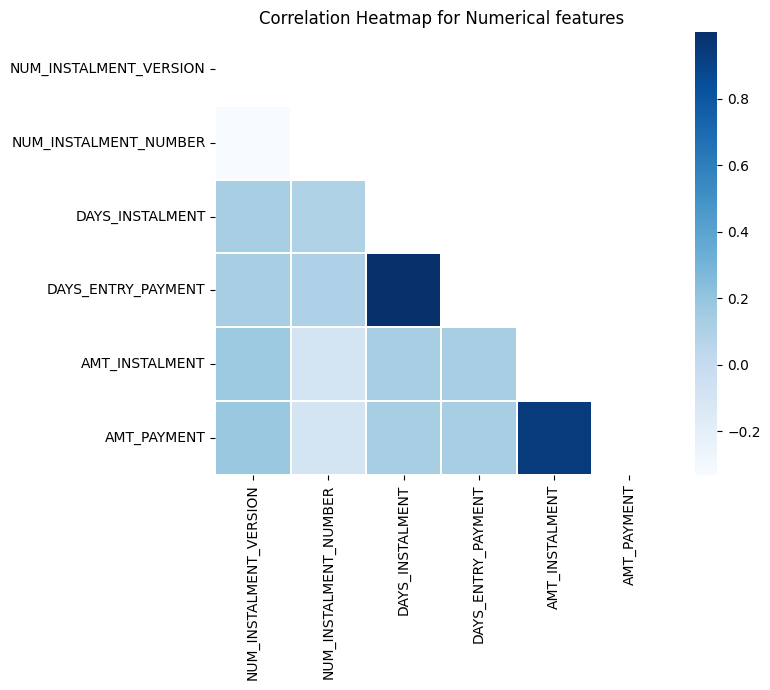

----------------------------------------------------------------------------------------------------


In [ ]:
corr_mat = correlation_matrix(installments_merged, ['SK_ID_CURR','SK_ID_PREV', 'TARGET'], figsize = (8,7))
corr_mat.plot_correlation_matrix()

In [ ]:
top_corr_target_df = corr_mat.target_top_corr()
print("-" * 100)
print("Columns with highest values of Phik-correlation with Target Variable are:")
display(top_corr_target_df)

interval columns not set, guessing: ['TARGET', 'NUM_INSTALMENT_VERSION']
interval columns not set, guessing: ['TARGET', 'NUM_INSTALMENT_NUMBER']
interval columns not set, guessing: ['TARGET', 'DAYS_INSTALMENT']
interval columns not set, guessing: ['TARGET', 'DAYS_ENTRY_PAYMENT']
interval columns not set, guessing: ['TARGET', 'AMT_INSTALMENT']
interval columns not set, guessing: ['TARGET', 'AMT_PAYMENT']
----------------------------------------------------------------------------------------------------
Columns with highest values of Phik-correlation with Target Variable are:


Column Name  Phik-Correlation
3      DAYS_ENTRY_PAYMENT          0.047231
2         DAYS_INSTALMENT          0.046815
1   NUM_INSTALMENT_NUMBER          0.022993
4          AMT_INSTALMENT          0.004125
5             AMT_PAYMENT          0.003084
0  NUM_INSTALMENT_VERSION          0.002198

**Interpretation**

Le heatmap ci-dessus montre la corrélation entre chaque variable de la table installments_payments et les autres variables.

D'après la matrice de corrélation, on observe quelques variables fortement corrélées, notamment :

- AMT_INSTALMENT et AMT_PAYMENT
- DAYS_INSTALMENT et DAYS_ENTRY_PAYMENT

Ces deux paires de variables corrélées sont compréhensibles, car elles reflètent respectivement la date prévue de paiement de l’échéance vs la date réelle de paiement, et le montant dû vs le montant réellement payé.

Ces variables seront utiles pour créer de nouveaux ensembles de variables totalement non corrélées.

La corrélation des variables avec la variable Target n’est pas significative, ce qui indique l’absence de relation linéaire entre ces variables et la variable cible.


##### Visualisation des variables continues

In [ ]:
installments_merged = installments_merged.groupby('SK_ID_PREV').mean()

**Distribution de la variable DAYS_INSTALMENT**

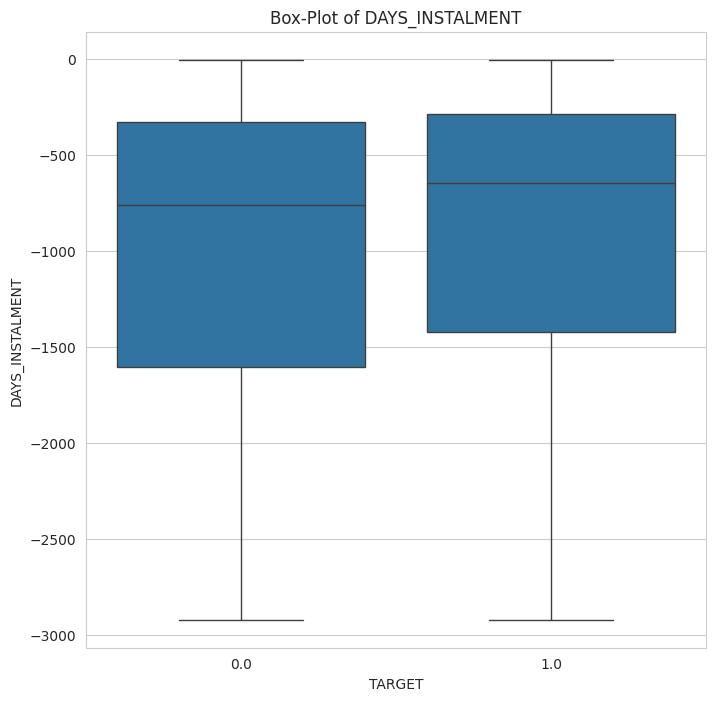

In [ ]:
plot_continuous_variables(installments_merged, 'DAYS_INSTALMENT', plots = ['box'], figsize = (8,8))

**Interprétation:**

les emprunteurs en défaut ont tendance à avoir un nombre de jours depuis leur dernier paiement plus faible, tandis que les emprunteurs non défaillants ont un nombre de jours plus élevé depuis leur dernier paiement.

Tous les quantiles des emprunteurs en défaut présentent des dates de paiement plus récentes que ceux des emprunteurs non défaillants. Ainsi, les emprunteurs non défaillants ont généralement un écart plus important entre leur dernier paiement et la date de la demande, comparé aux emprunteurs en défaut.

#### POS_CASH_balance.csv

In [ ]:
print(f'Le nombre d\'identifiants uniques SK_ID_PREV dans POS_CASH_balance.csv est: {len(POS_CASH_balance.SK_ID_PREV.unique())}')
print(f'Le nombre d\'identifiants uniques SK_ID_CURR dans POS_CASH_balance.csv est: {len(POS_CASH_balance.SK_ID_CURR.unique())}')
print('-'*100)
print(f'Le nombre d\'identifiants SK_ID_CURR communs entre application_train.csv et POS_CASH_balance.csv est: {len(set(application_train.SK_ID_CURR.unique()).intersection(set(POS_CASH_balance.SK_ID_CURR.unique())))}')
print(f'Le nombre d\'identifiants SK_ID_CURR communs entre application_test.csv et POS_CASH_balance.csv est: {len(set(application_test.SK_ID_CURR.unique()).intersection(set(POS_CASH_balance.SK_ID_CURR.unique())))}')

Le nombre d'identifiants uniques SK_ID_PREV dans POS_CASH_balance.csv est: 936325
Le nombre d'identifiants uniques SK_ID_CURR dans POS_CASH_balance.csv est: 337252
----------------------------------------------------------------------------------------------------
Le nombre d'identifiants SK_ID_CURR communs entre application_train.csv et POS_CASH_balance.csv est: 289444
Le nombre d'identifiants SK_ID_CURR communs entre application_test.csv et POS_CASH_balance.csv est: 47808


In [ ]:
analyzer_POS_CASH_balance = DataAnalyzer(POS_CASH_balance, metadata_df=HomeCredit_columns_description)
numerical_POS_CASH_balance, categorical_POS_CASH_balance , booleans_POS_CASH_balance = analyzer_POS_CASH_balance.data_col_type()
summary_table_POS_CASH_balance = analyzer_POS_CASH_balance.global_description_table(df=POS_CASH_balance[numerical_POS_CASH_balance])

In [ ]:
print('-'*50,'quelques statistiques de POS_CASH_balance','-'*50)
display(analyzer_POS_CASH_balance.Global_info())
print('-'*50,'quelques stats sur les colonnes numériques', '-'*50)
display(summary_table_POS_CASH_balance.head())

-------------------------------------------------- quelques statistiques dePOS_CASH_balance --------------------------------------------------


[{'nombre de lignes': 10001358,
  'nombre de colonnes': 8,
  'nombre de doublons': 0,
  'nombre de colonnes constantes ': 0,
  'colonnes constantes': [],
  'Pourcentage de valeurs manquantes %': np.float64(0.07),
  'dtypes': {'nombre de variables catégorielles': 1,
   'nombre de variables numeriques': 7,
   'nombre de variables Booléennes': 0}}]

-------------------------------------------------- quelques stats sur les colonnes numériques --------------------------------------------------


colonne  nb_valeurs  valeurs_manquantes en %       moyenne  \
3         CNT_INSTALMENT     9975287                     0.26  1.708965e+01   
4  CNT_INSTALMENT_FUTURE     9975271                     0.26  1.048384e+01   
0             SK_ID_PREV    10001358                     0.00  1.903217e+06   
2         MONTHS_BALANCE    10001358                     0.00 -3.501259e+01   
1             SK_ID_CURR    10001358                     0.00  2.784039e+05   

         max        min                                    Col_Description  
3       92.0        1.0     Term of previous credit (can change over time)  
4       85.0        0.0    Installments left to pay on the previous credit  
0  2843499.0  1000001.0                           Description non trouvée.  
2       -1.0      -96.0  Month of balance relative to application date ...  
1   456255.0   100001.0                           ID of loan in our sample

**Merge Target avec POS_CASH_balance**



In [ ]:
pos_cash_merged = application_train.iloc[:,:2].merge(POS_CASH_balance, on = 'SK_ID_CURR', how = 'left')

###### Matrice de corrélation

----------------------------------------------------------------------------------------------------


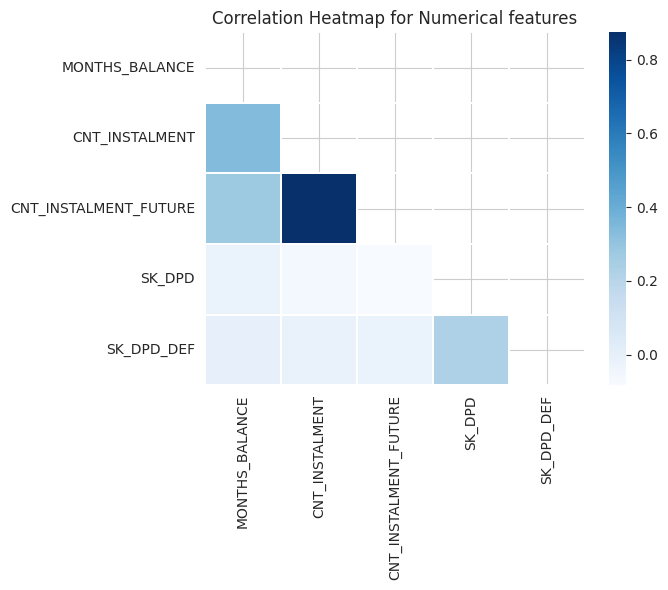

----------------------------------------------------------------------------------------------------


In [ ]:
corr_mat = correlation_matrix(pos_cash_merged, ['SK_ID_CURR','SK_ID_PREV','TARGET','NAME_CONTRACT_STATUS'], figsize = (7,6))
corr_mat.plot_correlation_matrix()

In [ ]:
top_corr_target_df = corr_mat.target_top_corr()
print("-" * 100)
print("Columns with highest values of Phik-correlation with Target Variable are:")
display(top_corr_target_df)

interval columns not set, guessing: ['TARGET', 'MONTHS_BALANCE']
interval columns not set, guessing: ['TARGET', 'CNT_INSTALMENT']
interval columns not set, guessing: ['TARGET', 'CNT_INSTALMENT_FUTURE']
interval columns not set, guessing: ['TARGET', 'SK_DPD']
interval columns not set, guessing: ['TARGET', 'SK_DPD_DEF']
----------------------------------------------------------------------------------------------------
Columns with highest values of Phik-correlation with Target Variable are:


Column Name  Phik-Correlation
2  CNT_INSTALMENT_FUTURE          0.033194
1         CNT_INSTALMENT          0.030947
0         MONTHS_BALANCE          0.027383
3                 SK_DPD          0.012773
4             SK_DPD_DEF          0.010539

**interpretation**

Sur ce heatmap, on identifie un ensemble de variables légèrement corrélés hormis CNT_INSTALMENT et CNT_INSTALMENT_FUTURE qui sont très fortement corrélées.

La corrélation des variables avec la variable Target est très faible, ce qui indique l'absence de relation linéaire entre ces variables et la variable cible.


##### Visualisation des variables continues

In [ ]:
pos_cash_merged_ = pos_cash_merged.drop(['SK_ID_CURR','NAME_CONTRACT_STATUS'], axis = 1).groupby('SK_ID_PREV').mean()

In [ ]:
pos_cash_merged_.head()

TARGET  MONTHS_BALANCE  CNT_INSTALMENT  CNT_INSTALMENT_FUTURE  \
SK_ID_PREV                                                                  
1000001.0      0.0            -9.0        8.666667               7.666667   
1000003.0      0.0            -2.5       12.000000              10.500000   
1000004.0      0.0           -25.5        9.625000               6.125000   
1000005.0      0.0           -51.0       10.000000               5.000000   
1000007.0      0.0            -3.0        6.000000               4.000000   

            SK_DPD  SK_DPD_DEF  
SK_ID_PREV                      
1000001.0      0.0         0.0  
1000003.0      0.0         0.0  
1000004.0      0.0         0.0  
1000005.0      0.0         0.0  
1000007.0      0.0         0.0

**Distribution de la variable CNT_INSTALMENT_FUTURE**

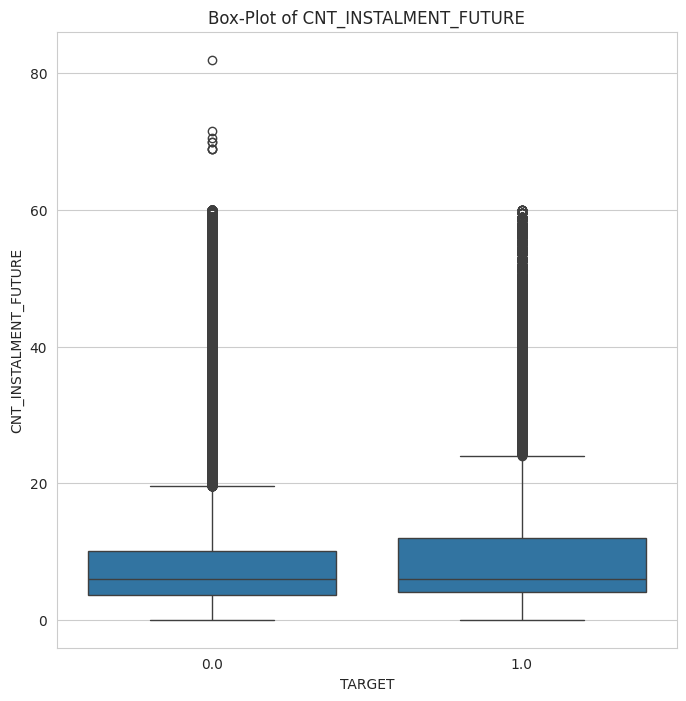

In [ ]:
plot_continuous_variables(pos_cash_merged_, 'CNT_INSTALMENT_FUTURE', plots = ['box'], figsize = (8,8))

**Interprétation**

En observant le box-plot ci-dessus pour CNT_INSTALMENT_FUTURE, on constate que les valeurs des percentiles supérieures à 50 % pour les emprunteurs en défaut sont généralement plus élevées que celles des emprunteurs non défaillants. Même la limite supérieure pour les emprunteurs en défaut est plus élevée que celle des non défaillants.

Cela suggère que les emprunteurs en défaut ont tendance à avoir un plus grand nombre d’échéances restantes sur leurs crédits précédents, comparativement aux emprunteurs non défaillants.

#### credit_card_balance.csv

In [16]:
print(f'Le nombre d\'identifiants uniques SK_ID_PREV dans credit_card_balance.csv est: {len(cc_balance.SK_ID_PREV.unique())}')
print(f'Le nombre d\'identifiants uniques SK_ID_CURR dans credit_card_balance.csv est: {len(cc_balance.SK_ID_CURR.unique())}')
print('-'*100)
print(f'Le nombre d\'identifiants SK_ID_CURR communs entre application_train.csv et credit_card_balance.csv est: {len(set(application_train.SK_ID_CURR.unique()).intersection(set(cc_balance.SK_ID_CURR.unique())))}')
print(f'Le nombre d\'identifiants SK_ID_CURR communs entre application_test.csv et credit_card_balance.csv est: {len(set(application_test.SK_ID_CURR.unique()).intersection(set(cc_balance.SK_ID_CURR.unique())))}')

Le nombre d'identifiants uniques SK_ID_PREV dans credit_card_balance.csv est: 104307
Le nombre d'identifiants uniques SK_ID_CURR dans credit_card_balance.csv est: 103558
----------------------------------------------------------------------------------------------------
Le nombre d'identifiants SK_ID_CURR communs entre application_train.csv et credit_card_balance.csv est: 86905
Le nombre d'identifiants SK_ID_CURR communs entre application_test.csv et credit_card_balance.csv est: 16653


In [15]:
cc_balance.head()

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  AMT_BALANCE  \
0     2562384      378907              -6       56.970   
1     2582071      363914              -1    63975.555   
2     1740877      371185              -7    31815.225   
3     1389973      337855              -4   236572.110   
4     1891521      126868              -1   453919.455   

   AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT  AMT_DRAWINGS_CURRENT  \
0                   135000                       0.0                 877.5   
1                    45000                    2250.0                2250.0   
2                   450000                       0.0                   0.0   
3                   225000                    2250.0                2250.0   
4                   450000                       0.0               11547.0   

   AMT_DRAWINGS_OTHER_CURRENT  AMT_DRAWINGS_POS_CURRENT  \
0                         0.0                     877.5   
1                         0.0                       0.0   
2                         0.0                       0.0   
3                         0.0                       0.0   
4                         0.0                   11547.0   

   AMT_INST_MIN_REGULARITY  AMT_PAYMENT_CURRENT  AMT_PAYMENT_TOTAL_CURRENT  \
0                 1700.325               1800.0                     1800.0   
1                 2250.000               2250.0                     2250.0   
2                 2250.000               2250.0                     2250.0   
3                11795.760              11925.0                    11925.0   
4                22924.890              27000.0                    27000.0   

   AMT_RECEIVABLE_PRINCIPAL  AMT_RECIVABLE  AMT_TOTAL_RECEIVABLE  \
0                     0.000          0.000                 0.000   
1                 60175.080      64875.555             64875.555   
2                 26926.425      31460.085             31460.085   
3                224949.285     233048.970            233048.970   
4                443044.395     453919.455            453919.455   

   CNT_DRAWINGS_ATM_CURRENT  CNT_DRAWINGS_CURRENT  CNT_DRAWINGS_OTHER_CURRENT  \
0                       0.0                     1                         0.0   
1                       1.0                     1                         0.0   
2                       0.0                     0                         0.0   
3                       1.0                     1                         0.0   
4                       0.0                     1                         0.0   

   CNT_DRAWINGS_POS_CURRENT  CNT_INSTALMENT_MATURE_CUM NAME_CONTRACT_STATUS  \
0                       1.0                       35.0               Active   
1                       0.0                       69.0               Active   
2                       0.0                       30.0               Active   
3                       0.0                       10.0               Active   
4                       1.0                      101.0               Active   

   SK_DPD  SK_DPD_DEF  
0       0           0  
1       0           0  
2       0           0  
3       0           0  
4       0           0

In [21]:
analyzer_cc_balance = DataAnalyzer(cc_balance, metadata_df=HomeCredit_columns_description)
numerical_cc_balance, categorical_cc_balance , booleans_cc_balance = analyzer_cc_balance.data_col_type()
summary_table_cc_balance = analyzer_cc_balance.global_description_table(df=cc_balance[numerical_cc_balance])

In [23]:
print('-'*50,'quelques statistiques de credit_card_balance','-'*50)
display(analyzer_cc_balance.Global_info())
print('-'*50,'quelques stats sur les colonnes numériques', '-'*50)
display(summary_table_cc_balance.head())

-------------------------------------------------- quelques statistiques de credit_card_balance --------------------------------------------------


[{'nombre de lignes': 3840312,
  'nombre de colonnes': 23,
  'nombre de doublons': 0,
  'nombre de colonnes constantes ': 0,
  'colonnes constantes': [],
  'Pourcentage de valeurs manquantes %': np.float64(6.65),
  'dtypes': {'nombre de variables catégorielles': 1,
   'nombre de variables numeriques': 22,
   'nombre de variables Booléennes': 0}}]

-------------------------------------------------- quelques stats sur les colonnes numériques --------------------------------------------------


colonne  nb_valeurs  valeurs_manquantes en %  \
10         AMT_PAYMENT_CURRENT     3072324                    20.00   
5     AMT_DRAWINGS_ATM_CURRENT     3090496                    19.52   
15    CNT_DRAWINGS_ATM_CURRENT     3090496                    19.52   
8     AMT_DRAWINGS_POS_CURRENT     3090496                    19.52   
7   AMT_DRAWINGS_OTHER_CURRENT     3090496                    19.52   

         moyenne          max      min  \
10  10280.537702  4289207.445     0.00   
5    5961.324822  2115000.000 -6827.31   
15      0.309449       51.000     0.00   
8    2968.804848  2239274.160     0.00   
7     288.169582  1529847.000     0.00   

                                      Col_Description  
10  How much did the client pay during the month o...  
5   Amount drawing at ATM during the month of the ...  
15  Number of drawings at ATM during this month on...  
8   Amount drawing or buying goods during the mont...  
7   Amount of other drawings during the month of t...

#####Merge Target avec credit_card_balance

In [34]:
cc_balance_merged = application_train.iloc[:,:2].merge(cc_balance, on = 'SK_ID_CURR', how = 'left')

##### Matrice de correlation

----------------------------------------------------------------------------------------------------


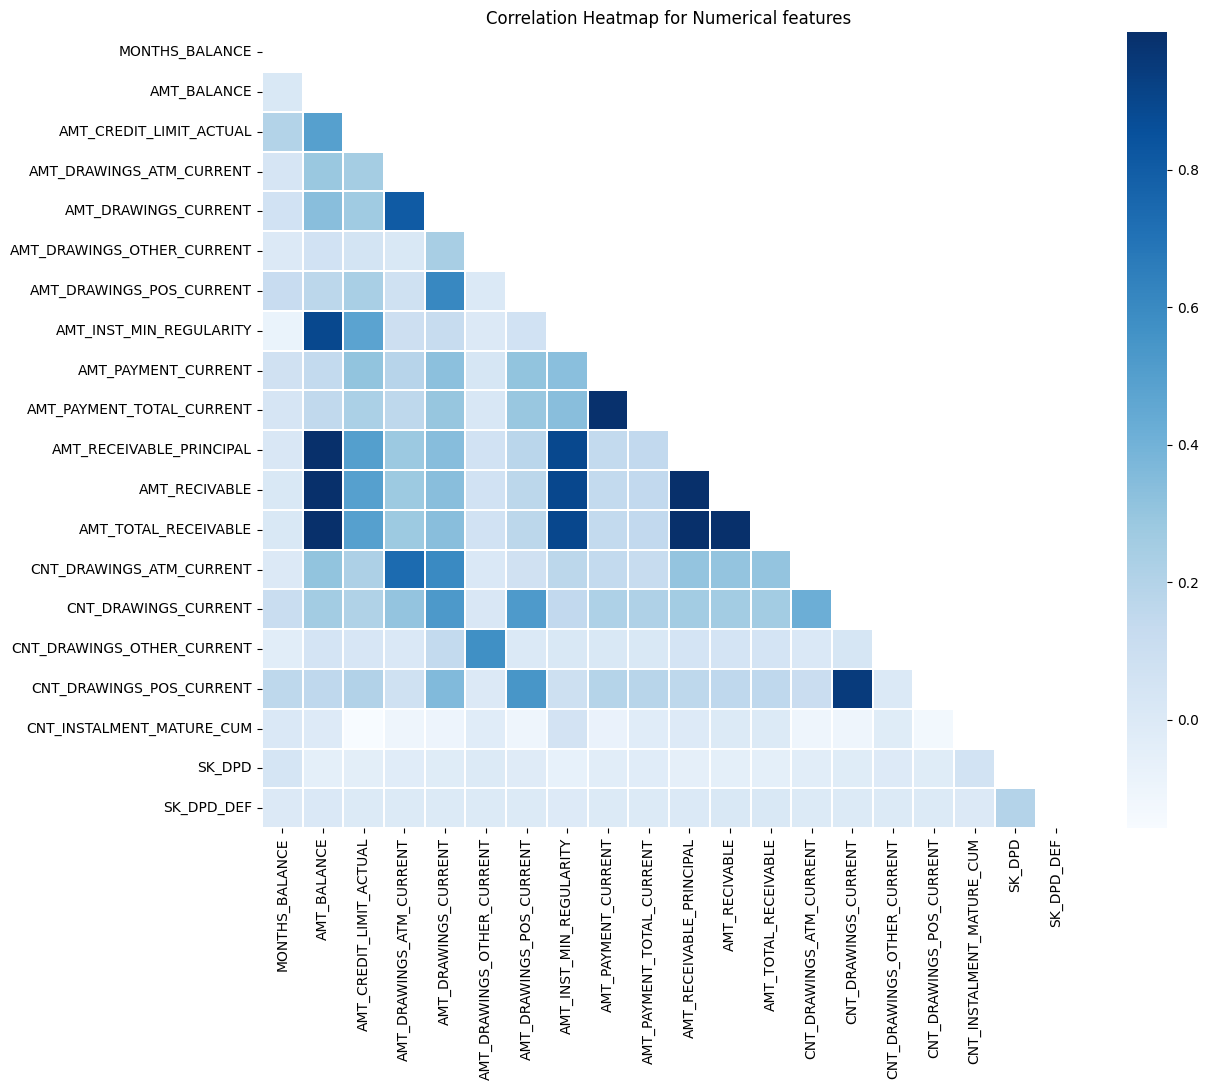

----------------------------------------------------------------------------------------------------


In [30]:
corr_mat = correlation_matrix(cc_balance_merged, ['SK_ID_CURR','SK_ID_PREV','NAME_CONTRACT_STATUS','TARGET'], figsize = (13,11))
corr_mat.plot_correlation_matrix()

In [31]:
top_corr_target_df = corr_mat.target_top_corr()
print("-" * 100)
print("Columns with highest values of Phik-correlation with Target Variable are:")
display(top_corr_target_df)

interval columns not set, guessing: ['TARGET', 'MONTHS_BALANCE']
interval columns not set, guessing: ['TARGET', 'AMT_BALANCE']
interval columns not set, guessing: ['TARGET', 'AMT_CREDIT_LIMIT_ACTUAL']
interval columns not set, guessing: ['TARGET', 'AMT_DRAWINGS_ATM_CURRENT']
interval columns not set, guessing: ['TARGET', 'AMT_DRAWINGS_CURRENT']
interval columns not set, guessing: ['TARGET', 'AMT_DRAWINGS_OTHER_CURRENT']
interval columns not set, guessing: ['TARGET', 'AMT_DRAWINGS_POS_CURRENT']
interval columns not set, guessing: ['TARGET', 'AMT_INST_MIN_REGULARITY']
interval columns not set, guessing: ['TARGET', 'AMT_PAYMENT_CURRENT']
interval columns not set, guessing: ['TARGET', 'AMT_PAYMENT_TOTAL_CURRENT']
interval columns not set, guessing: ['TARGET', 'AMT_RECEIVABLE_PRINCIPAL']
interval columns not set, guessing: ['TARGET', 'AMT_RECIVABLE']
interval columns not set, guessing: ['TARGET', 'AMT_TOTAL_RECEIVABLE']
interval columns not set, guessing: ['TARGET', 'CNT_DRAWINGS_ATM_CURREN

Column Name  Phik-Correlation
1                 AMT_BALANCE          0.059838
11              AMT_RECIVABLE          0.059311
12       AMT_TOTAL_RECEIVABLE          0.059288
10   AMT_RECEIVABLE_PRINCIPAL          0.058895
0              MONTHS_BALANCE          0.050330
7     AMT_INST_MIN_REGULARITY          0.042174
17  CNT_INSTALMENT_MATURE_CUM          0.037519
13   CNT_DRAWINGS_ATM_CURRENT          0.030052
2     AMT_CREDIT_LIMIT_ACTUAL          0.028752
14       CNT_DRAWINGS_CURRENT          0.027841

**Interprétation**

À partir de la matrice de corrélation, nous observons quelques paires de variables fortement corrélées. Il s'agit de :
- AMT_RECEIVABLE_PRINCIPLE, AMT_RECIVABLE, AMT_TOTAL_RECEIVABLE et AMT_BALANCE.
Nous constatons également une forte corrélation entre ces trois colonnes AMT_RECEIVABLE :
AMT_PAYMENT_TOTAL_CURRENT et AMT_PAYMENT_CURRENT.
- Les deuxièmes et troisièmes ensembles de variables corrélées sont compréhensibles, car elles décrivent à peu près les mêmes informations.

La corrélation entre les variables et la variable cible n’est pas significative, ce qui montre l’absence de relation linéaire entre les caractéristiques et la variable cible.

##### Visualisation des variables continues

In [36]:
cc_balance_merged = cc_balance_merged.drop(['NAME_CONTRACT_STATUS','SK_ID_CURR'], axis = 1).groupby('SK_ID_PREV').mean()

**Distribution de AMT_BALANCE**

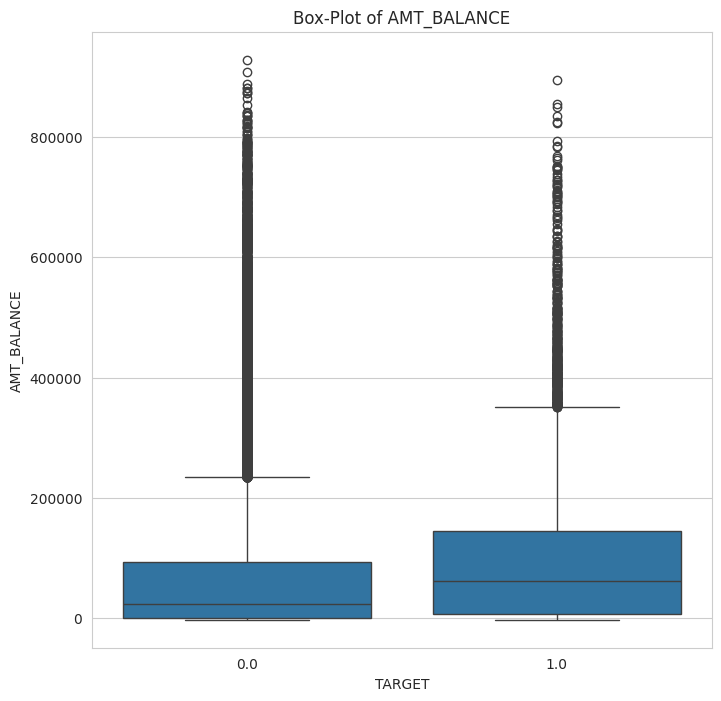

In [37]:
plot_continuous_variables(cc_balance_merged, 'AMT_BALANCE', plots = ['box'], figsize = (8,8))

À partir du graphique ci-dessus, on peut voir que les défaillants présentent une valeur plus élevée de AMT_BALANCE par rapport aux non-défaillants.
Ils affichent des valeurs plus élevées pour tous les quantiles ainsi que pour les extrémités.

Cela pourrait indiquer que le montant du crédit accordé aux défaillants est également relativement plus élevé que celui des non-défaillants.

#### Conclusions de l’analyse exploratoire des données (EDA)

À partir de l’analyse exploratoire exhaustive des données que nous avons réalisée, nous pouvons tirer quelques conclusions générales sur notre jeu de données.


Tout d’abord, l’ensemble des données devra être fusionné de manière ingénieuse afin que les données combinées aient un sens cohérent.
Certaines catégories permettent de bien différencier les défaillants des non-défaillants, ce qui pourrait s’avérer important pour la classification.
Il existe quelques variables numériques continues qui contiennent des valeurs erronées ; il faudra les traiter correctement.
Nous avons également identifié certaines variables fortement corrélées, qui ne font qu’augmenter la dimensionnalité des données sans apporter de réelle valeur ajoutée. Il serait donc pertinent de les éliminer.
De manière générale, le jeu de données est déséquilibré, et nous devrons mettre en œuvre des techniques pour gérer ce déséquilibre.
Dans le cadre de la prédiction du risque de défaut, les défaillants ont généralement des comportements atypiques. Par conséquent, nous ne pouvons pas simplement supprimer les valeurs aberrantes ou les points éloignés, car ils pourraient refléter des tendances importantes liées au défaut de paiement.


Avec tous ces éléments en tête, nous allons maintenant passer à l’étape de nettoyage des données et de construction des variables (Feature Engineering).